In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
#BASE_DIR= '/content/drive/MyDrive/DACON/Finance/reprocessed/'
BASE_DIR='/content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/'

# 설명

## Question - Answering with Retrieval

본 대회의 과제는 중앙정부 재정 정보에 대한 **검색 기능**을 개선하고 활용도를 높이는 질의응답 알고리즘을 개발하는 것입니다. <br>이를 통해 방대한 재정 데이터를 일반 국민과 전문가 모두가 쉽게 접근하고 활용할 수 있도록 하는 것이 목표입니다. <br><br>
베이스라인에서는 평가 데이터셋만을 활용하여 source pdf 마다 Vector DB를 구축한 뒤 langchain 라이브러리와 llama-2-ko-7b 모델을 사용하여 RAG 프로세스를 통해 추론하는 과정을 담고 있습니다. <br>( train_set을 활용한 훈련 과정은 포함하지 않으며, test_set  에 대한 추론만 진행합니다. )

## Mount/Login

구글 드라이브를 마운트하고 허깅페이스에 로그인
- 이때 허깅페이스 토큰은 kdt3 그룹에 대해 읽기/쓰기 권한이 있는 토큰이어야 함

## Download Library
필요/사용 라이브러리 다운로드
이때 버전 문제로 설치를 한 뒤 세션을 한번 재시작해줘야 합니다
<br>(그리고 세션 완전히 끊기면 다운로드 후 재시작을 다시 해줘야...)

## Import Library
한번 재시작했으면 위 과정 없이 Import만 실행해주면 됩니다

## Vector DB
문서를 여러 조각(chunk)로 나누고, 임베딩 유사도를 통해 관련 조각을 찾을 수 있게 DB화하는 함수들이 정의되어 있습니다.

## DB 생성
Vector DB에서 정의된 함수들로 문서 DB를 만들어줍니다.<br><br>
이때 Train과 Test를 한번에 하려고 하면 코랩이 터질 확률이 높으므로 Train하고 Create Dataset까지 실행해 업로드 한 뒤 재시작해서 램을 비우고 Test를 하는 것이 좋습니다.<br> 또한 문서 임베딩을 어떤 모델로 할지 인자로 넘겨줄 수 있습니다

## Create Dataset
DB 생성에서 만든 db와 데이터 dataframe을 사용해 HuggingFace 데이터셋 생성 후 업로드

## Fine-Tuning
학습 데이터셋으로 모델에 대한 파인튜닝 진행 후 Huggingface에 업로드<br>
4비트 양자화 LoRA로 파인튜닝<br>
기반 모델 또는 넣어줄때 사용할 프롬프트, 학습 관련 하이퍼파라미터 수정 가능

## Langchain 을 이용한 추론
모델을 사용한 추론


## 실행
### 기본
Mount/Login -> Download Library -> 재시작 (처음 1번)
Mount/Login -> Import Library (이후)

### 데이터셋 만들기
기본 -> Vector DB -> DB 생성 -> Create Dataset에서 첫 셀 + Train/Valid/Test 중 해당하는 셀

### 모델 학습하기
기본 -> Fine-Tuning(업로드할 위치, 데이터셋 위치, 모델 링크 확인 필수)

### 학습된 모델로 추론하기
기본 -> Langchain을 이용한 추론(모델 링크, 데이터셋 위치 확인) -> Submission(저장할 파일명 확인)

# Mount/Login

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ls {BASE_DIR}

241008_csv_checker.ipynb             gemma2_financeQA-finetune/  test_source/
combined_train_aug_v3.5_editted.csv  processed/                  train.csv
combined_train_aug_v3.csv            sample_submission.csv       train_source/
combined_train_aug_v3_editted.csv    sub/                        Untitled0.ipynb
data/                                temp/
eval/                                test.csv


In [5]:
import os

token_path = os.path.join(BASE_DIR,'data','token')
with open(token_path,'r') as f:
    master_token = f.readline().strip('\n')

In [6]:
from huggingface_hub import login

login(token=master_token, add_to_git_credential=True)

# Download Library

In [7]:
!apt-get install tesseract-ocr
!apt-get install poppler-utils

!pip install orjson==3.10.6

!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install transformers[torch] -U

!pip install datasets
!pip install langchain
!pip install langchain_community
!pip install langchain-teddynote
!pip install PyMuPDF
!pip install sentence-transformers
!pip install faiss-gpu
!pip install unstructured pdfminer.six
!pip install pillow-heif
!pip install pikepdf pypdf

!pip install pymupdf4llm

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.2 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

# Import Library

In [8]:
import os
import unicodedata
import torch
import pandas as pd
from tqdm.auto import tqdm
import fitz  # PyMuPDF

from langchain.document_loaders.parsers.pdf import PDFPlumberParser

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    pipeline,
    BitsAndBytesConfig
)
from accelerate import Accelerator

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter

# PDF 로딩/청크화 관련
from langchain.document_loaders.parsers.pdf import PDFPlumberParser
from langchain.document_loaders.pdf import PDFPlumberLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain_teddynote.retrievers import KiwiBM25Retriever
from langchain.retrievers import EnsembleRetriever, MultiQueryRetriever

from unstructured.cleaners.core import clean_extra_whitespace, clean, clean_non_ascii_chars

import pymupdf4llm
import pymupdf

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
# gpu memory 할당 해제
import gc, time

def free_cuda():
  mem = 1
  while mem > 0 :
    time.sleep(0.5)
    mem = gc.collect()
    torch.cuda.empty_cache()
    print("freed : ",mem)

# Vector DB

In [10]:
from operator import itemgetter
from langchain_text_splitters import RecursiveCharacterTextSplitter
from unstructured.cleaners.core import clean_extra_whitespace, clean, clean_non_ascii_chars


# 불릿포인트 제거용 함수
def remove_bulletpoints(text):
    cleaned_text = text
    for symbol in ['ㅇ','-','□', '※', '▸','∙','●','☞','■','','','·']:
        cleaned_text = cleaned_text.replace(symbol, f"-")
    return cleaned_text

def replace_sign_symbol(text):
    cleaned_text = text
    cleaned_text = cleaned_text.replace('△', "-")
    return cleaned_text


# 숫자 심볼 숫자로 변환
def replace_num_symbols_with_number(text):
    cleaned_text = text
    for idx, symbol in enumerate(['①', '②', '③', '④', '⑤', '⑥', '⑦', '⑧', '⑨', '⑩', '⑪', '⑫', '⑬', '⑭', '⑮']):
        cleaned_text = cleaned_text.replace(symbol, f"{idx+1})")
    return cleaned_text

def erase_unicode_chr(text):
  return re.sub(r'\\u[0-9a-fA-F]{4}','-',text)

In [11]:
def normalize_path(path):
    """경로 유니코드 정규화"""
    return unicodedata.normalize('NFC', path)

def process_path(base_dir,file_path):
  norm_path = normalize_path(file_path)
  if not os.path.isabs(norm_path):
    return os.path.normpath(os.path.join(base_dir, norm_path))
  else : return norm_path

def subpath_list(dir_path):
  return list(map(lambda x : os.path.join(dir_path,x),os.listdir(dir_path)))

def processed_path_matcher(dir_path,file_path):
  sub_list = subpath_list(dir_path)
  path_list = list()
  for sub in sub_list:
    path_list.extend(subpath_list(sub))
  prcssd_list =list(map(normalize_path,path_list))
  for real_path,prcssd_path in zip(path_list,prcssd_list) :
    if file_path == prcssd_path : return real_path
  else : return file_path

In [12]:
from operator import itemgetter
import re

def remove_table_spaces(text):
  text = re.sub(r'[ \t\r]+',' ',text)
  text = re.sub(r'[\n\v\f]+','\n',text)
  text = re.sub(r'\|:?[\-]+:?(?=[\|])','|-',text)
  return text


def clean_string(text):
    text_string = clean(text, dashes=True,trailing_punctuation=True, bullets=True)
    text_string = replace_num_symbols_with_number(text_string)
    text_string = remove_bulletpoints(text_string)
    return text_string

def clean_table(text_string):
#    text_string = remove_table_spaces(text_string)
    text_string = replace_num_symbols_with_number(text_string)
    text_string = replace_sign_symbol(text_string)
    text_string = remove_bulletpoints(text_string)
    return erase_unicode_chr(text_string)

# 전체 마크다운 처리
def process_pdf(file_path, chunk_size=256, chunk_overlap=32):
    """PDF 텍스트 추출 후 chunk 단위로 나누기"""
    # PDF 파일 열기
    doc = pymupdf4llm.to_markdown(file_path)

    headers_to_split_on = [
        ("#","Header 1"),
        ("##","Header 2"),
        ("###","Header 3"),
    ]

    md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
    md_chunks = md_splitter.split_text(doc)

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(md_chunks)

    return chunks


def create_vector_db(chunks, model_path="intfloat/multilingual-e5-small"):
    """FAISS DB 생성"""
    # 임베딩 모델 설정
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': True}
    embeddings = HuggingFaceEmbeddings(
        model_name=model_path,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    # FAISS DB 생성 및 반환
    db = FAISS.from_documents(chunks, embedding=embeddings)
    return db




In [13]:
import pickle

def check_and_mkdir(func):
    def wrapper(*args,**kwargs):
        if not os.path.exists(args[0]): os.makedirs(args[0])
        return func(*args,**kwargs)
    return wrapper

@check_and_mkdir
def save_pkl(save_dir,file_name,save_object):
    if not os.path.exists(save_dir): os.mkdir(save_dir)
    file_path = os.path.join(save_dir,file_name)
    with open(file_path,'wb') as f:
        pickle.dump(save_object,f)

def load_pkl(file_path):
    with open(file_path,'rb') as f:
        data = pickle.load(f)
    return data

# Preprocessing Tables

In [14]:
!pip install gmft
!pip install git+https://github.com/conjuncts/gmft_pymupdf.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 36.4 MB/s eta 0:00:00
  Cloning https://github.com/conjuncts/gmft_pymupdf.git to /tmp/pip-req-build-r5t8g5o0
  Running command git clone --filter=blob:none --quiet https://github.com/conjuncts/gmft_pymupdf.git /tmp/pip-req-build-r5t8g5o0
  Resolved https://github.com/conjuncts/gmft_pymupdf.git to commit ec63abcd8a6fd0564df765f72bc1e0009e8a5fdc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gmft_pymupdf: filename=gmft_pymupdf-0.0.1-py3-none-any.whl size=14799 sha256=af1dd56b8dae64b0029a3eed439a861dffb443d4746686351860bc1d06706150
  Stored in directory: /tmp/pip-ephem-wheel-cache-55nkw3lf/wheels/51/c5/90/0d40554960f02c258dda3fee906d2cbc776bc371eefe4c3d9e
Successfully built

In [15]:
import gmft.table_detection
import gmft
import markdown
from gmft.auto import CroppedTable, TableDetector, AutoTableFormatter, AutoFormatConfig
from gmft.auto import AutoTableDetector, TATRDetectorConfig
from gmft.pdf_bindings import PyPDFium2Document
from gmft_pymupdf import PyMuPDFPage
from collections import defaultdict
import copy

In [16]:
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


In [17]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from ipdb import set_trace

import matplotlib.pyplot as plt

def close_event():
    plt.close() #timer calls this function after 3 seconds and closes the window

fig = plt.figure()
timer = fig.canvas.new_timer(interval = 3000) #creating a timer object and setting an interval of 3000 milliseconds
timer.add_callback(close_event)

<function __main__.close_event()>

<Figure size 640x480 with 0 Axes>

## functions

### process info about page and box

In [18]:
'''
-height
8pt : 2.82mm , a4 : 210mm * 297mm
ratio : 2.82/297 ~ 0.0094
-width
same length as height : get height and use it
'''

def bound_page(box,page):
  x0 = min(max(box[0],page[0]),page[2])
  x1 = min(max(box[1],page[1]),page[3])
  x2 = max(min(box[2],page[2]),page[0])
  x3 = max(min(box[3],page[3]),page[1])
  return (x0,x1,x2,x3)

def check_exclusv_range(ran1,ran2,ths):
  flag1 = (ran1[0] - ran2[1] >= -ths)
  flag2 = (ran2[0] - ran1[1] >= -ths)
  return flag1 or flag2

def check_exclusive_box(box1,box2,ths):
  flag_horiz = check_exclusv_range((box1[0],box1[2]),(box2[0],box2[2]),ths)
  flag_verti = check_exclusv_range((box1[1],box1[3]),(box2[1],box2[3]),ths)
  return flag_horiz or flag_verti

def union_box(box1,box2):
  return min(box1[0],box2[0]),min(box1[1],box2[1]),max(box1[2],box2[2]),max(box1[3],box2[3])

def check_pairly_linked(ele_list,check_not_link,union_func):
  elements = copy.deepcopy(ele_list)
  for i0,e0 in enumerate(elements):
    for i1,e1 in enumerate(elements):
      if i0 >= i1 : continue
      if not check_not_link(e0,e1):
        elements.pop(i1)
        elements.pop(i0)
        new = union_func(e0,e1)
        elements.append(new)
    #    print(i0,i1,new,len(elements))
    #  else : print('=',i0,i1)
  return elements

import copy

def union_pairly_linked(ele_list,check_not_link,union_func):
  elements = ele_list
  cnt,bnd = 0,2**len(ele_list)
  while True :
    #print('-'*5,cnt,'-'*5)
    rslt = check_pairly_linked(elements,check_not_link,union_func)
    if len(rslt) == len(elements) or len(rslt) < 2 : break
    if cnt > bnd : break
    elements,cnt = rslt, cnt+1
  return rslt

def get_ths(page,ths_ratio=0.0094):
  return ths_ratio * (page[3]-page[1])

def organize_box(box_list,page,ths):
  box_list = list(map(lambda x : bound_page(x,page),box_list))
  check_exclusv = lambda x,y : check_exclusive_box(x,y,ths)
  return union_pairly_linked(box_list,check_exclusv,union_box)

def get_bbox(tables):
  return list(map(lambda x : x.bbox,list(tables)))

def get_page_size(page,ths=0):
  area = (0,0,page[2]-page[0],page[3]-page[1])
  return area

def expand_bbox_by_ths(bbox,area,ths=0):
  bbox =(bbox[0]-ths,bbox[1]-ths,bbox[2]+ths,bbox[3]+ths)
  return bound_page(bbox,area)

def larger_v_ths(area,ths=0):
  size = get_page_size(area)
  return (size[2]>=ths) and (size[3]>=ths)

def infer_bbox_pos(area,bbox):
  return bbox[0]+area[0],bbox[1]+area[1],bbox[2]+area[0],bbox[3]+area[1]

### process detector,formatter,tables

In [19]:
from gmft.auto import AutoTableDetector
from gmft_pymupdf import PyMuPDFPage


def get_ft_bbox(ft,page,ths=0):
  area = ft.rect.bbox
  rslt = organize_box(ft.fctn_results['boxes'],get_page_size(area),ths)[0]
  return infer_bbox_pos(area,rslt) #expand_bbox_by_ths(rslt,area,ths)

def define_formatter():
    config = AutoFormatConfig()
    config.semantic_spanning_cells=True
    config.semantic_hierarchical_left_fill='deep'
    config.enable_multi_header=False
    config.torch_device= device
    config.total_overlap_reject_threshold = 0.3
    config.large_table_assumption = True
    config.verbose = 2
    formatter = AutoTableFormatter(config=config)
    return formatter

def define_detector():
    config =TATRDetectorConfig()
    config.torch_device= device
    config.detector_base_threshold=0.80
#    config.detector_base_threshold=0.6
    detector = AutoTableDetector(config=config)
    return detector
import re

def erase_constant_rowcol(df,val):
  cols = range(len(df.columns))
  df_temp = df.set_axis(cols,axis=1)
  cond = df_temp == val
  target = list(filter(lambda col : np.sum(cond[col]) != len(cond),cols))
  df_temp, cond = df_temp[target], cond[target]
  cond2 = np.sum(cond,axis=1) != len(target)
  return df_temp[cond2]

def maybe_numeric_table(df,ths=0.35,line_ths=0.9):
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
  df_temp = erase_constant_rowcol(df_temp,'0')
  #df_temp = df.replace(r'(?:(\d+?)),(\d+?)',r'\1\2',regex=True)
  df_temp = df.replace(r'[△\,\(\)\-\+\.\s\%\[\]]','',regex=True)
  df_temp = df_temp[list(df_temp.columns)].apply(pd.to_numeric,errors='coerce')
  rslt = ~df_temp.isna()
  rowwise = rslt.apply(sum,axis=1)
  colwise = rslt.apply(sum,axis=0)
  if np.sum(rowwise * line_ths <= len(rslt)) > 0 : return True
  if np.sum(colwise * line_ths <= len(rslt.columns)) > 0 : return True
  if np.sum(rslt.values) > len(rslt)*len(rslt.columns)*ths : return True
  return False

def check_table_df_soundness(df,ths=0.45):
  if len(df) < 1 : return False
  if maybe_numeric_table(df) : return True
  df_temp = df.replace(to_replace=[None], value='PD_NONE')
  cols = list(df.columns.astype(np.string_))
  cols = list(map(lambda x : '' if x is None else str(x),cols))
  cols = list(map(lambda x : re.sub(r'[\s]*','',x),cols))
  null_named = list(filter(lambda x: len(x)<1,cols))
  if len(null_named) > len(cols) * ths : return False
  none_count = df_temp=='PD_NONE'
  if np.sum(none_count.values) > len(df)*len(cols)*ths : return False
  return True

def detect_sound_table(dt):
  if len(dt.text()) > 2 : return True
  return False

def find_tables(page,area,ths=0):
  detector,formatter = define_detector(),define_formatter()
  doc = PyMuPDFPage(page)
  dt_whole = detector.extract(doc)
  dt_whole = list(filter(detect_sound_table,dt_whole))
  gmft_bboxes = list(map(lambda x : x.bbox,dt_whole))
  searched = get_bbox(page.find_tables())
  searched.extend(gmft_bboxes)
  searched = list(filter(lambda x: larger_v_ths(x,ths),searched))
  return organize_box(searched,area,ths)
#  rslt = list(map(lambda x:make_table(x,doc,area,formatter,ths),searched))
#  return list(filter(lambda x : x is not None,searched))

def make_table(bbox,doc,area,formatter,ths=0):
  rect = gmft.common.Rect(expand_bbox_by_ths(bbox,area,ths))
  temp = gmft.table_detection.CroppedTable(doc,rect,0.80) #confidence level 조정이 표 인식에 영향 있을지도
  ft = formatter.extract(temp)
  #display(ft.rect.bbox,ft.visualize())
  try :
    tab_box = get_ft_bbox(ft,ths)
    caption = '\t'.join(ft.captions()) if 'captions' in ft.__dir__() else ''
    df_tab = ft.df()
    if not larger_v_ths(tab_box,ths) : raise Exception('too small area :',tab_box)
    if not check_table_df_soundness(df_tab) : raise Exception('table does not sound')
    #else : print('table sounds')
    table = {'content':df_tab,'bbox':tab_box,'caption':caption} #, 'ft':ft}
    return table
  except Exception as e:
    try :
      display(df_tab)
      df_tab.msg = e
      table = df_tab
    except : table = None
#    display(ft.visualize())
    print('exception : ',e)
    return table

### search in page

In [20]:
'''
if table found, search left and right
and then, the area will be colored
'''

def get_area(area,page,left):
  if left : return page[0],area[1],area[0],area[3]
  else : return area[2],area[1],page[2],area[3]


def get_blank(searched_row,page,ths=0):
  rslt,point = list(), page[1]
  searched_row = sorted(searched_row,key=lambda x: x[1])
  searched_row.append((page[0],page[3],page[2],page[3]))
  for row in searched_row[:-1]:
    if row[1] - point < ths : continue
    rslt.append((page[0],point,page[2],row[1]))
    point=row[3]
  return [bound_page(box,page) for box in rslt]


def extend_list_dict(a,b):
  rslt = defaultdict(list)
  for key,val in a.items():
    rslt[key].extend(val)
  for key,val in b.items():
    rslt[key].extend(val)
  return rslt

def search_page(page,area,ths=0,depth=0):
  rslt,searched = list(),list()
  if not larger_v_ths(area,ths) : return rslt
  if depth >=10 : raise Exception(depth)
#  print('depth : ',depth,'area : ',area)
  page.set_cropbox(area) #area : page에서 절대적 위치. cropbox를 하게 되면 상대적 위치로 바뀜
#  set_trace()
  detected = find_tables(page,get_page_size(area),ths)
  if len(detected)==0 : return rslt
  for target in detected:
#    if target is None : continue
#    if type(target) is not dict : rslt['errs'].append(target)
    rect = infer_bbox_pos(area,target)
    bbox = {'bbox':rect,'depth':depth}
    rslt.append(bbox)
#    print('detected:',rect,'\t at',area,f' in depth {depth}')

    left_area = get_area(rect,area,True)
    right_area = get_area(rect,area,False)
    if depth > 5 : print(f'left {left_area}\tright{right_area}')
    left = search_page(page,left_area,ths,depth+1)
    right = search_page(page,right_area,ths,depth+1)
    searched.append((area[0],rect[1],area[2],rect[3]))
    if depth > 5 : print(searched)
    rslt.extend(left+right)

  if len(rslt)==0 : return rslt
  searched = organize_box(searched,area,ths)
  blanks = get_blank(searched,area,ths)
  if depth >5 : print(f'in {area}\n\t',blanks)
  for row in blanks:
    detected = search_page(page,row,ths,depth+1)
    rslt.extend(detected)

#  rslt= organize_box(rslt,area,ths) : can't apply directly like this
#  print('in search page, err : ',len(rslt['errs']))
  page.set_cropbox(area)
  return rslt

### extract tables and reform pdfs

In [21]:
def replace_area_to_mark(mu_page,area,mark):
    mu_page.add_redact_annot(area)
    mu_page.apply_redactions()
    mu_page.draw_rect(area,color=(.0,0,0),fill=(.99,.99,.99))
    rc = mu_page.insert_htmlbox(area,mark,scale_low=0)
    return mu_page

def extract_tables_from_pdf(full_path,tab_word='[[TABLE_{0}]]'):
    pdf = pymupdf.open(full_path)
    chunks, tables_dict, cnt= list(), defaultdict(list),0
    err_dict = dict()
    if pdf is None : return None, tables_dict
    for pnum, page in enumerate(tqdm(pdf)):
      page_area = tuple(page.mediabox)
      ths = get_ths(page_area)

      detected = search_page(page,page_area,ths)
      bboxes = [dic['bbox'] for dic in detected]
      bboxes = organize_box(bboxes,page_area,ths)
      tables,errors,doc =list(),list(), PyMuPDFPage(page)
      formatter = define_formatter()
      for box in bboxes:
        table = make_table(box,doc,page_area,formatter,get_ths(page_area))
        if table is None :
          print('error : ',box)
          continue
        if type(table) is not dict : errors.append(table)
        else : tables.append(table)

      if len(errors)>0 :
        err_dict[pnum] = errors
        print(f'errs in p.{pnum}: ',len(errors))
      if len(tables) == 0 : continue
      print(f'detected in p.{pnum} :\t',len(tables),' tables')
      tables = sorted(tables,key=lambda x : (x['bbox'][1],x['bbox'][0]))
      for idx,tab in enumerate(tables):
        tab_mark = tab_word.format(cnt+idx)
        table_md = clean_table(tab['content'].to_markdown(index=False))
        tables_dict[pnum].append((tab_mark,table_md + f"\n{tab['caption']}"))

        try :
          area = tab['bbox']
          page.add_redact_annot(area)
          page.apply_redactions()
          page.draw_rect(area,color=(.0,0,0),fill=(.99,.99,.99))
          rc = page.insert_htmlbox(area,tab_mark,scale_low=0)
        except :
          print(page.mediabox)
          print(page.cropbox)
          print(tab['bbox'])
          display(tab['content'])
          print(table_md)

      cnt+=len(tables)

    print(cnt, len(tables_dict), sum([len(tables) for tables in tables_dict.values()]))
    return pdf, tables_dict,err_dict

def extract_table_and_pdf(pdf_path,base_path,save_dir):
    # 경로 정규화 및 절대 경로 생성
    norm_path = normalize_path(pdf_path)
    full_path = process_path(base_path,pdf_path)
    full_path = processed_path_matcher(base_path,full_path)
    pdf_name = os.path.basename(full_path)

    print(f"Processing {pdf_name}...")
    save_path = os.path.join(save_dir, norm_path)
    print(full_path,save_path)
    pdf_dir = os.path.dirname(save_path)
    if not os.path.exists(pdf_dir) : os.makedirs(pdf_dir)
    new_pdf,tab_list,err_list = extract_tables_from_pdf(full_path,tab_word)
    save_pkl(pdf_dir,pdf_name[:-4]+'.pkl',tab_list)
    save_pkl(pdf_dir,'err_'+pdf_name[:-4]+'.pkl',err_list)
    new_pdf.save(save_path,garbage=4,deflate=True)
    return tab_list,err_list

def reform_pdfs_from_df(df, base_path,save_dir,name='data'):
    """딕셔너리에 pdf명을 키로해서 DB, retriever 저장"""
    unique_paths = df['Source_path'].unique()
    tab_dict,err_dict = dict(), dict()
    for path in tqdm(unique_paths, desc="Processing PDFs"):
      print(path,base_path)
      tab_dict[path],err_dict[path]=extract_table_and_pdf(path,base_path,save_dir)
    save_pkl(os.path.join(save_dir,'tables'),f'tab_{name}.pkl',tab_dict)
    return tab_dict,err_dict

## read table marks

In [22]:
def convert_neg_idx(idxs,len_obj):
  rslt = deepcopy(idxs)
  for i in idxs:
    if i >= 0 : continue
    new_num = i + len_obj
    del rslt[i]
    rslt.append(new_num)
  return rslt

def add_escape(sent):
  idxs = list(filter(lambda x : sent[x] in ['[',']'],range(len(sent))))
  temp, idxs = list(sent), convert_neg_idx(idxs,len(sent))
  idxs = sorted(idxs)[::-1]
  for i in idxs:
    temp.insert(i,'\\')
  return ''.join(temp)

In [23]:
import re
from copy import deepcopy
from collections import defaultdict
from langchain_core.documents import Document as Doc

def get_former_idx(err_list):
  rslt = list()
  for i in err_list:
    cand = list(filter(lambda x : x not in err_list,range(i)))
    idx = max(cand) if cand else 0
    rslt.append(idx)
  return rslt

def get_latter_idx(err_list):
  rslt = list()
  for i in err_list:
    cand = list(filter(lambda x : x not in err_list,range(i,err_list[-1]+2)))
    idx = min(cand) if cand else err_list[-1]+1
    rslt.append(idx)
  return rslt

def make_table_page(content,tab_mark,table,tab_caption=None,th_len=100):
  if len(content)<len(tab_mark) : return None, None
  if tab_caption is None : tab_caption = tab_mark
  re_sep = '[\s\|]*'
  re_mark = insert_btwn_chr(tab_mark,re_sep)
  re_trgt = re.compile(re_mark)
  flag = list(re.finditer(re_trgt,content))
  if flag :
      front,end = flag[0].pos,flag[0].endpos
      start = min(0,front-th_len)
      new_page = content[start:front] + '\n' + table + f'\n{tab_caption}'
      #page = content[:front]+tab_caption+content[end:]
      page = content
  else : new_page, page = None, None
  return new_page,page

def get_insert_idx(former_idx,latter_idx,tab_page):
  rslt = list()
  for former,latter in zip(former_idx,latter_idx):
    pages = tab_page.values()
    first, last = 0,max(pages)
    i0 = tab_page[former] if former in tab_page else first
    i1 = tab_page[latter] if latter in tab_page else last
    rslt.append(int((i0+i1)/2))
  return rslt

def set_err_tab_page(new_pages,err_list,table_list,tab_page,tab_caption):
  if len(err_list) == 0 : return new_pages
  err_idx, err_tabs = zip(*err_list)
  if len(new_pages) == 0 : insert_idx = [-1 for _ in err_list]
  else :
    former_idx = get_former_idx(err_idx)
    latter_idx = get_latter_idx(err_idx)
    insert_idx = get_insert_idx(former_idx,latter_idx,tab_page)
  for page,i_tab,tab in zip(insert_idx,err_idx,err_tabs):
    content =tab +'\n'+ tab_caption.format(i_tab)
    new_pages[page].append(Doc(page_content=content))
  return new_pages

def convert_neg_num_page(page_dict,book_len):
  rslt = deepcopy(page_dict)
  for page,docs in page_dict.items():
    if page >= 0 : continue
    new_num = page+book_len
    del rslt[page]
    rslt[new_num] = docs
  return rslt

def insert_pages(doc_list,new_pages):
  new_pages = convert_neg_num_page(new_pages,len(doc_list))
  page_list = sorted(list(new_pages.keys()))[::-1]
  for page in page_list:
    if page >= len(doc_list) -1 : doc_list += new_pages[page]
    else : doc_list = doc_list[:page+1]+new_pages[page]+doc_list[page+1:]
  return doc_list

def get_table_page(num,doc_list,tab_mark,table):
    this_page = doc_list[num]['text']
    next_page = doc_list[num+1]['text'] if num+1 < len(doc_list) else ''
    both_page = this_page + next_page if next_page != '' else ''

    this_rslt,page0 = make_table_page(this_page,tab_mark,table)
    next_rslt,page1 = make_table_page(next_page,tab_mark,table)
    both_rslt,page2 = make_table_page(both_page,tab_mark,table)

    if this_rslt is not None : page_content,page = this_rslt, page0
    if next_rslt is not None : page_content,page,num = next_rslt, page1,num+1
    elif both_rslt is not None :
      page_content,page = both_rslt, page2[:len(this_page)+abs(len(both_page)-len(both_rslt))]
    else : page_content,page = None, this_page
    return page_content, page, num

def expand_pages(doc_list,new_pages):
  for page,tables in new_pages.items():
    content = doc_list[page]['text']+'\n'+'\n'.join(tables)
    doc_list[page]['text'] = content
  return doc_list

def insert_table_2_doc(doc_list,table_dict,tab_word='[[TABLE_{0}]]'):
  new_pages,cnt = defaultdict(list),0
  for num,table_info in table_dict.items():
    for tab_mark,table in table_info:
      table_page,page_adjst,page_num = get_table_page(num,doc_list,tab_mark,table)
      if table_page is not None:
        new_pages[page_num].append(table_page)
#        doc_list[page_num]['text'] = page_adjst
        cnt+=1
      else : new_pages[num].append(table+'\n'+tab_mark)

  doc_list = expand_pages(doc_list,new_pages)
  return doc_list, cnt/sum(map(len,table_dict.values()))

def insert_btwn_chr(sent,sep):
  c = list(add_escape(sent))
  d = c.copy()
  diff = (len(c)-len(sent))//2
  for i in range(2*diff+1,len(c)-diff*2+2)[::-1]:
    d.insert(i-1,sep)
  return ''.join(d)



In [24]:
import difflib

def union_strs(str0,str1):
    output_list = difflib.ndiff(str0, str1)
    return ''.join(map(lambda x : x[-1],output_list))

def pdf_2_chunck_w_table(file_path, tables, tab_word,chunk_size=256, chunk_overlap=32):
    """PDF 텍스트 추출 후 chunk 단위로 나누기"""
    # PDF 파일 열기
    doc = pymupdf4llm.to_markdown(file_path,page_chunks=True,table_strategy='lines')
    doc,rate = insert_table_2_doc(doc,tables,tab_word)
    doc0 = '\n'.join(map(lambda x : x['text'],doc))
#    doc1 = pymupdf4llm.to_markdown(file_path)
#    docs = union_strs(doc0,doc1)
    md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
    md_chunks = md_splitter.split_text(doc0)
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(md_chunks)
    print(file_path)
    print(f'table mark detect rate : {rate:.5f}')

    return chunks,rate

def make_chunk_dict_from_df(df, base_dir, table_dict, chunk_size=256):
    """딕셔너리에 pdf명을 키로해서 DB, retriever 저장"""
    unique_paths = df['Source_path'].unique()
    chunk_dict = dict()
    err_tab_dict = dict()

    for file_path in tqdm(unique_paths, desc="Processing PDFs"):
        # 경로 정규화 및 절대 경로 생성
        full_path = process_path(base_dir,file_path)
        full_path = processed_path_matcher(base_dir,full_path)
        pdf_title = os.path.basename(full_path)
        print(f"Processing {pdf_title}...")

        # PDF 처리 및 벡터 DB 생성
        chunk_dict[file_path]= pdf_2_chunck_w_table(full_path,table_dict[file_path],chunk_size)
    return chunk_dict

In [25]:
#앙상블
def process_pdfs_from_df(df, base_dir, table_dict, tab_word, chunk_size=256, model_path = "intfloat/multilingual-e5-small"):
    """딕셔너리에 pdf명을 키로해서 DB, retriever 저장"""
    pdf_databases = {}
    unique_paths = df['Source_path'].unique()
    rate_dict=dict()

    for file_path in tqdm(unique_paths, desc="Processing PDFs"):
        # 경로 정규화 및 절대 경로 생성
        full_path = process_path(base_dir,file_path)
        full_path = processed_path_matcher(base_dir,full_path)
        pdf_title = os.path.basename(full_path)
        print(f"Processing {pdf_title}...")

        # PDF 처리 및 벡터 DB 생성
        chunks,rate =pdf_2_chunck_w_table(full_path,table_dict[file_path],tab_word,chunk_size)
        db = create_vector_db(chunks, model_path=model_path)

        kiwi_bm25_retriever = KiwiBM25Retriever.from_documents(chunks)
        faiss_retriever = db.as_retriever()
        retriever = EnsembleRetriever(
            retrievers=[kiwi_bm25_retriever, faiss_retriever],
            weights=[0.5, 0.5],
            search_type="mmr",
        )

        # 결과 저장
        pdf_databases[pdf_title] = {
                'db': db,
                'retriever': retriever
        }
        rate_dict[pdf_title] = rate
    return pdf_databases, rate_dict

## run codes

In [26]:
headers_to_split_on = [
    ("#","Header 1"),
    ("##","Header 2"),
    ("###","Header 3"),
]

tab_word = '!표{0}!'

In [27]:
train_df = pd.read_csv(f'{BASE_DIR}train.csv')
test_df = pd.read_csv(f'{BASE_DIR}test.csv')

#### move files to runtime

In [28]:
ls {BASE_DIR}

241008_csv_checker.ipynb             gemma2_financeQA-finetune/  test_source/
combined_train_aug_v3.5_editted.csv  processed/                  train.csv
combined_train_aug_v3.csv            sample_submission.csv       train_source/
combined_train_aug_v3_editted.csv    sub/                        Untitled0.ipynb
data/                                temp/
eval/                                test.csv


In [29]:
src_dirs = ['train_source/','test_source/']
file_path = ' '.join([os.path.join(BASE_DIR,sub) for sub in src_dirs])
temp_path = '/content/src/'
if not os.path.exists(temp_path) : os.makedirs(temp_path)

In [30]:
for sub in src_dirs:
  src_path = os.path.join(BASE_DIR,sub)
  dst_path = os.path.join(temp_path,sub)
  if not os.path.exists(dst_path) : os.makedirs(dst_path)
  !rsync -rvzh {src_path} {dst_path} --bwlimit 4096000000000000 --progress

sending incremental file list
1-1 2024 주요 재정통계 1권.pdf
         12.79M 100%   17.55MB/s    0:00:00 (xfr#1, to-chk=15/17)
2024 나라살림 예산개요.pdf
          7.63M 100%    4.44MB/s    0:00:01 (xfr#2, to-chk=14/17)
2024년도 성과계획서(총괄편).pdf
          5.66M 100%    5.49MB/s    0:00:00 (xfr#3, to-chk=13/17)
고용노동부_내일배움카드(일반).pdf
        143.29K 100%  108.48kB/s    0:00:01 (xfr#4, to-chk=12/17)
고용노동부_조기재취업수당.pdf
        166.37K 100%  691.36kB/s    0:00:00 (xfr#5, to-chk=11/17)
고용노동부_청년일자리창출지원.pdf
        135.51K 100%  262.57kB/s    0:00:00 (xfr#6, to-chk=10/17)
국토교통부_민간임대(융자).pdf
        116.94K 100%  145.11kB/s    0:00:00 (xfr#7, to-chk=9/17)
국토교통부_소규모주택정비사업.pdf
        305.15K 100%  296.23kB/s    0:00:01 (xfr#8, to-chk=8/17)
국토교통부_전세임대(융자).pdf
        136.00K 100%  535.53kB/s    0:00:00 (xfr#9, to-chk=7/17)
보건복지부_노인일자리 및 사회활동지원.pdf
 

In [31]:
## caution to unicode normalize
display('1-1 2024 주요 재정통계 1권.pdf' == normalize_path('1-1 2024 주요 재정통계 1권.pdf'))
display('1-1 2024 주요 재정통계 1권.pdf' == '1-1 2024 주요 재정통계 1권.pdf')

True

False

In [32]:
PROCESSEDDIR = os.path.join(BASE_DIR,'processed')
if not os.path.exists(PROCESSEDDIR) : os.makedirs(PROCESSEDDIR)
ERRORDIR = os.path.join(PROCESSEDDIR,'ERRORS')
if not os.path.exists(ERRORDIR) : os.makedirs(ERRORDIR)

In [37]:
reform_pdfs_from_df(train_df, temp_path,PROCESSEDDIR,'trn')
reform_pdfs_from_df(test_df, temp_path,PROCESSEDDIR,'tst');

Processing PDFs:   0%|          | 0/16 [00:00<?, ?it/s]

./train_source/1-1 2024 주요 재정통계 1권.pdf /content/src/
Processing 1-1 2024 주요 재정통계 1권.pdf...
/content/src/train_source/1-1 2024 주요 재정통계 1권.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/1-1 2024 주요 재정통계 1권.pdf


  0%|          | 0/137 [00:00<?, ?it/s]

Filling in gap at top of table
detected in p.5 :	 1  tables
detected in p.6 :	 1  tables
detected in p.7 :	 1  tables
detected in p.9 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.12 :	 1  tables
detected in p.15 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.16 :	 7  tables
detected in p.17 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.18 :	 5  tables
detected in p.19 :	 3  tables
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Empty DataFrame
Columns: [, ]
Index: []

exception :  table does not sound
errs in p.20:  1
detected in p.20 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.21 :	 8  tables
detected in p.23 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.24 :	 4  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 122.40% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
exception :  The identified boxes have significant overlap: 33.31% of area is overlapping (Max is 30.00%)
error :  (64.27757263183594, 98.44635772705078, 483.2125244140625, 157.75360107421875)
detected in p.28 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 122.40% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.30 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 72.95% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.31 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.33 :	 2  tables


Empty DataFrame
Columns: [, , , , , , , , 세외수입]
Index: []

exception :  table does not sound
exception :  The identified boxes have significant overlap: 54.05% of area is overlapping (Max is 30.00%)
error :  (11.504044532775879, 96.1129035949707, 85.45462799072266, 115.78001022338867)
exception :  No rows or columns detected
error :  (518.9035415649414, 109.80732727050781, 528.7214813232422, 188.01011657714844)
errs in p.34:  1
detected in p.34 :	 3  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 97.65% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.35 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.36 :	 2  tables
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 36.37% of area is overlapping (Max is 30.00%)
error :  (100.88123321533203, 87.66973280906677, 489.254150390625, 193.9076385498047)
detected in p.37 :	 2  tables
detected in p.38 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 81.49% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.39 :	 1  tables
exception :  No rows or columns detected
error :  (516.5375938415527, 87.823974609375, 528.846321105957, 626.5369873046875)
detected in p.40 :	 1  tables
exception :  The identified boxes have significant overlap: 84.87% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.41 :	 2  tables
detected in p.42 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 133.

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.45 :	 1  tables
exception :  No rows or columns detected
error :  (517.2333755493164, 279.4853820800781, 526.5295486450195, 372.8176574707031)
detected in p.46 :	 3  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 71.57% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.47 :	 1  tables
detected in p.48 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.49 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.50 :	 3  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 49.58% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.51 :	 1  tables
Filling in gap at top of table
detected in p.53 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  min() arg is an empty sequence
error :  (514.5090560913086, 575.754638671875, 527.0344429016113, 642.9046783447266)
detected in p.54 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.55 :	 1  tables
detected in p.56 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.57 :	 1  tables
detected in p.58 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 96.65% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.59 :	 1  tables
exception :  No rows or columns detected
error :  (514.2398681640625, 87.823974609375, 528.817138671875, 530.6631774902344)
detected in p.60 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 60.31% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.61 :	 1  tables
detected in p.62 :	 4  tables
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 31.24% of area is overlapping (Max is 30.00%)
error :  (93.2326431274414, 89.08004522323608, 483.4903564453125, 239.27699279785156)
detected in p.63 :	 2  tables
detected in p.64 :	 3  tables
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.65 :	 3  tables
detected in p.66 :	 2  tables
exception :  The identified boxes have significant overlap: 60.71% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.67 :	 2  tables
detected in p.68 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 58.96% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.69 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 107.07% of area is overlapping (Max is 30.00%)
error :  (482.1209616661072, 281.8659418821335, 551.3917694091797, 294.47827911376953)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 83.98% of area is overlapping (Max is 30.00%)
error :  (495.2099199295044, 138.85107278823853, 547.6303024291992, 251.2835235595703)
detected in p.70 :	 5  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 55.03% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.71 :	 1  tables
detected in p.72 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 143.90% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.73 :	 1  tables
detected in p.74 :	 2  tables
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.75 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (515.109037399292, 116.95180320739746, 526.1426811218262, 176.42874145507812)
detected in p.76 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 101.38% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.77 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.78 :	 4  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 93.87% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
exception :  The identified boxes have significant overlap: 43.72% of area is overlapping (Max is 30.00%)
error :  (143.1801300048828, 164.61092376708984, 490.989013671875, 248.66993713378906)
detected in p.79 :	 1  tables
exception :  list index out of range
error :  (515.8946800231934, 170.35848331451416, 523.6598587036133, 399.03196716308594)
detected in p.80 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 105.67% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.81 :	 1  tables
detected in p.82 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.87 :	 1  tables
detected in p.88 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 143.31% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.89 :	 1  tables
exception :  No rows or columns detected
error :  (515.3197326660156, 261.26587677001953, 526.9953155517578, 587.9543151855469)
exception :  No rows or columns detected
error :  (518.3789024353027, 113.20984840393066, 528.1741333007812, 174.12249755859375)
detected in p.90 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 89.50% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.91 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.93 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.94 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 72.33% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
exception :  No rows or columns detected
error :  (516.0554275512695, 101.44034576416016, 530.2446098327637, 497.20618438720703)
detected in p.96 :	 1  tables
exception :  The identified boxes have significant overlap: 84.87% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.97 :	 1  tables
exception :  No rows or columns detected
error :  (489.25205421447754, 444.7302360534668, 550.1385192871094, 646.9729614257812)
detected in p.98 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 95.50% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.32397460

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.101 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.102 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 138.31% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.103 :	 1  tables
exception :  No rows or columns detected
error :  (514.216064453125, 87.823974609375, 528.1532363891602, 519.4490356445312)
detected in p.104 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 95.10% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.105 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.107 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.108 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 76.61% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.110 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 150.24% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.111 :	 1  tables
exception :  list index out of range
error :  (513.7666397094727, 266.1406555175781, 523.1020812988281, 428.9111022949219)
detected in p.112 :	 1  tables
exception :  The identified boxes have significant overlap: 84.87% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.113 :	 2  tables
exception :  No rows or columns detected
error :  (517.2129936218262, 218.78892135620117, 525.0948905944824, 602.3929748535156)
detected in p.114 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 68.23% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.115 :	 1  tables
detected in p.116 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 128.06% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.117 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 176.99% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.119 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.120 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 74.08% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.121 :	 2  tables
exception :  list index out of range
error :  (511.7950668334961, 270.4377746582031, 525.1206436157227, 570.4132690429688)
detected in p.122 :	 1  tables
exception :  The identified boxes have significant overlap: 148.79% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.125 :	 1  tables
detected in p.126 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 131.18% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.127 :	 1  tables
detected in p.128 :	 2  tables
exception :  The identified boxes have significant overlap: 148.79% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  list index out of range
error :  (513.1953582763672, 108.42400360107422, 525.8393249511719, 424.3361129760742)
detected in p.130 :	 1  tables
Filling in gap at top of table
detected in p.131 :	 1  tables
detected in p.132 :	 1  tables
exception :  The identified boxes have significant overlap: 148.79% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)
detected in p.133 :	 1  tables
detected in p.134 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 65.41% of area is overlapping (Max is 30.00%)
error :  (70.6999994913737, 48.28399658203125, 555.6000366210938, 86.323974609375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.135 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (516.1014671325684, 579.8780136108398, 527.2107925415039, 638.8219146728516)
detected in p.136 :	 1  tables
198 112 198
./train_source/2024 나라살림 예산개요.pdf /content/src/
Processing 2024 나라살림 예산개요.pdf...
/content/src/train_source/2024 나라살림 예산개요.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/2024 나라살림 예산개요.pdf


  0%|          | 0/314 [00:00<?, ?it/s]

exception :  The identified boxes have significant overlap: 63.35% of area is overlapping (Max is 30.00%)
error :  (63.54349899291992, 72.28399658203125, 212.22889709472656, 99.42401123046875)
detected in p.2 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.8 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.9 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 32.91% of area is overlapping (Max is 30.00%)
error :  (87.54232788085938, 106.93522644042969, 390.3876953125, 593.4742431640625)
detected in p.10 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.11 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 35.18% of area is overlapping (Max is 30.00%)
error :  (86.49810791015625, 107.37834167480469, 408.60101318359375, 653.53759765625)
detected in p.12 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.13 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 33.75% of area is overlapping (Max is 30.00%)
error :  (87.30848693847656, 99.87483215332031, 395.31964111328125, 636.7579956054688)
detected in p.14 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.15 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 33.93% of area is overlapping (Max is 30.00%)
error :  (87.88396453857422, 110.99243927001953, 380.96063232421875, 636.5990600585938)
detected in p.16 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 30.33% of area is overlapping (Max is 30.00%)
error :  (69.76456451416016, 111.05584716796875, 361.8029479980469, 660.1060180664062)
detected in p.17 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 36.27% of area is overlapping (Max is 30.00%)
error :  (87.2939682006836, 98.10095977783203, 405.5224304199219, 654.5616455078125)
detected in p.18 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.19 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.20 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.21 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 35.02% of area is overlapping (Max is 30.00%)
error :  (88.63143157958984, 109.3316879272461, 362.5763854980469, 572.2259521484375)
detected in p.22 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.23 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.24 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.27 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.28 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 32.25% of area is overlapping (Max is 30.00%)
error :  (71.053466796875, 115.78262329101562, 451.9217529296875, 644.6980590820312)
detected in p.29 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 33.36% of area is overlapping (Max is 30.00%)
error :  (89.48455810546875, 109.81551361083984, 333.3411560058594, 592.1912231445312)
detected in p.30 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.31 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.32 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 32.29% of area is overlapping (Max is 30.00%)
error :  (71.98658752441406, 128.1224365234375, 280.93603515625, 604.6610717773438)
detected in p.33 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 32.09% of area is overlapping (Max is 30.00%)
error :  (87.44975280761719, 109.15190124511719, 365.9813232421875, 582.2437744140625)
detected in p.34 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.35 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.36 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.42 :	 7  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.43 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.44 :	 1  tables
detected in p.45 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.46 :	 2  tables
detected in p.47 :	 5  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.48 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.49 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.50 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.51 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.52 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.53 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.54 :	 1  tables
detected in p.55 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (503.44915771484375, 145.06382274627686, 519.9147529602051, 286.55455017089844)
detected in p.56 :	 2  tables
detected in p.61 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.62 :	 1  tables
detected in p.63 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.64 :	 1  tables
detected in p.65 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.66 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.67 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.68 :	 3  tables
detected in p.69 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 39.36% of area is overlapping (Max is 30.00%)
error :  (84.8046646118164, 123.58252716064453, 467.9774475097656, 660.6497802734375)
detected in p.70 :	 1  tables
detected in p.71 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 42.92% of area is overlapping (Max is 30.00%)
error :  (103.95384216308594, 134.76963806152344, 469.3848571777344, 643.466552734375)
detected in p.72 :	 1  tables
detected in p.73 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.74 :	 4  tables
detected in p.75 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.76 :	 1  tables
detected in p.77 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.78 :	 5  tables
detected in p.79 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.80 :	 2  tables
detected in p.81 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.82 :	 1  tables
detected in p.83 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.84 :	 5  tables
detected in p.85 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 133.31% of area is overlapping (Max is 30.00%)
error :  (83.02499389648438, 275.0494689941406, 476.8163757324219, 300.8705596923828)
detected in p.86 :	 2  tables
detected in p.87 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.88 :	 1  tables
exception :  The identified boxes have significant overlap: 32.21% of area is overlapping (Max is 30.00%)
error :  (70.86605507986886, 426.8550754123264, 453.5429992675781, 606.0963134765625)
detected in p.89 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.90 :	 4  tables
detected in p.91 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.92 :	 1  tables
exception :  The identified boxes have significant overlap: 48.74% of area is overlapping (Max is 30.00%)
error :  (70.86595764160157, 127.13201904296875, 453.54310607910156, 295.03448486328125)
detected in p.93 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.94 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.95 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.96 :	 1  tables
detected in p.97 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.98 :	 1  tables
detected in p.99 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.100 :	 1  tables
detected in p.101 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.102 :	 1  tables
detected in p.103 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.104 :	 1  tables
detected in p.105 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.106 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.107 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.108 :	 1  tables
detected in p.109 :	 1  tables
detected in p.113 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.114 :	 2  tables
detected in p.115 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 54.44% of area is overlapping (Max is 30.00%)
error :  (83.30099487304688, 115.39175033569336, 467.65911865234375, 303.55645751953125)
exception :  No rows or columns detected
error :  (499.9344253540039, 137.2101821899414, 524.2155075073242, 287.45710372924805)
detected in p.116 :	 2  tables
detected in p.117 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.118 :	 2  tables
Filling in gap at top of table
detected in p.119 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.120 :	 1  tables
detected in p.121 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.122 :	 1  tables
detected in p.123 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.124 :	 5  tables
detected in p.125 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.126 :	 2  tables
detected in p.127 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.128 :	 4  tables
detected in p.129 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.130 :	 2  tables
detected in p.131 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.132 :	 4  tables
detected in p.133 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.134 :	 2  tables
detected in p.135 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.136 :	 1  tables
detected in p.137 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.138 :	 3  tables
detected in p.139 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.140 :	 2  tables
detected in p.141 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.142 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.143 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (509.2938117980957, 210.55177307128906, 516.6074981689453, 409.9053497314453)
detected in p.144 :	 5  tables
detected in p.145 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.146 :	 4  tables
detected in p.147 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.148 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.149 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.150 :	 1  tables
exception :  The identified boxes have significant overlap: 40.79% of area is overlapping (Max is 30.00%)
error :  (70.94535827636719, 132.78717041015625, 454.7890930175781, 661.2700805664062)
detected in p.151 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.152 :	 1  tables
detected in p.153 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.154 :	 2  tables
detected in p.155 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.156 :	 2  tables
detected in p.157 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 35.07% of area is overlapping (Max is 30.00%)
error :  (86.5031967163086, 137.6669464111328, 468.25897216796875, 632.3745727539062)
detected in p.158 :	 1  tables
detected in p.159 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (502.7995071411133, 314.11870765686035, 522.930591583252, 424.62950134277344)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.160 :	 4  tables
detected in p.161 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.162 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.163 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.164 :	 3  tables
detected in p.165 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.166 :	 1  tables
detected in p.167 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.168 :	 1  tables
detected in p.169 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.170 :	 1  tables
detected in p.171 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.172 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.173 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.174 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.175 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (506.0665740966797, 338.5453872680664, 516.4892921447754, 473.3643341064453)
detected in p.176 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.177 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.178 :	 1  tables
detected in p.179 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.180 :	 1  tables
detected in p.181 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.182 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.183 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.184 :	 2  tables
detected in p.185 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (504.6490173339844, 219.44612312316895, 523.1163673400879, 365.55859565734863)


Empty DataFrame
Columns: [, , ]
Index: []

exception :  table does not sound
errs in p.186:  1
detected in p.186 :	 4  tables
exception :  The identified boxes have significant overlap: 70.07% of area is overlapping (Max is 30.00%)
error :  (70.27904510498047, 315.69696044921875, 454.4823913574219, 648.8812866210938)
detected in p.187 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.188 :	 2  tables
detected in p.189 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.190 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.191 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.192 :	 1  tables
exception :  The identified boxes have significant overlap: 36.15% of area is overlapping (Max is 30.00%)
error :  (71.86873626708984, 139.53826904296875, 455.1239929199219, 646.860107421875)
detected in p.193 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.194 :	 5  tables
exception :  The identified boxes have significant overlap: 37.64% of area is overlapping (Max is 30.00%)
error :  (71.2598648071289, 142.86129760742188, 455.1363830566406, 659.7640991210938)
detected in p.195 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (494.48936653137207, 124.50141143798828, 523.4510917663574, 243.40231323242188)
detected in p.196 :	 4  tables
detected in p.197 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.198 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.199 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  list index out of range
error :  (513.053783416748, 461.8957633972168, 523.5150985717773, 621.2659606933594)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.200 :	 4  tables
detected in p.201 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.202 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.203 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.204 :	 1  tables
detected in p.205 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.206 :	 2  tables
detected in p.207 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.208 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.209 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.210 :	 1  tables
detected in p.211 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.212 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.213 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.214 :	 3  tables
detected in p.215 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.216 :	 3  tables
detected in p.217 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.218 :	 1  tables
detected in p.219 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (503.46559143066406, 227.13198852539062, 526.7622413635254, 424.4872283935547)
detected in p.220 :	 2  tables
detected in p.221 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.222 :	 4  tables
detected in p.223 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.224 :	 3  tables
detected in p.225 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.226 :	 3  tables
exception :  The identified boxes have significant overlap: 35.66% of area is overlapping (Max is 30.00%)
error :  (70.72733306884766, 127.88114929199219, 454.19512939453125, 550.8694458007812)
detected in p.227 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.228 :	 2  tables
detected in p.229 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (503.4036064147949, 138.65754508972168, 523.7765312194824, 284.08653259277344)
detected in p.230 :	 2  tables
exception :  The identified boxes have significant overlap: 32.64% of area is overlapping (Max is 30.00%)
error :  (70.86594772338867, 412.3050897771662, 453.5429992675781, 651.43701171875)
detected in p.231 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.232 :	 1  tables
exception :  The identified boxes have significant overlap: 36.14% of area is overlapping (Max is 30.00%)
error :  (70.64855194091797, 133.9530029296875, 453.991455078125, 570.23388671875)
detected in p.233 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (509.1952133178711, 128.05208659172058, 517.1124534606934, 368.60523986816406)
detected in p.234 :	 2  tables
detected in p.235 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.236 :	 3  tables
detected in p.237 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (495.7056007385254, 132.13142490386963, 522.1070518493652, 264.14813232421875)
detected in p.238 :	 2  tables
detected in p.239 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.240 :	 3  tables
detected in p.241 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 54.48% of area is overlapping (Max is 30.00%)
error :  (489.41406440734863, 171.25162506103516, 520.7733039855957, 204.68748092651367)
detected in p.242 :	 4  tables
detected in p.248 :	 1  tables
Filling in gap at top of table
detected in p.249 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.250 :	 3  tables
detected in p.251 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.252 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.253 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 91.24% of area is overlapping (Max is 30.00%)
error :  (54.02522659301758, 111.34354400634766, 494.0057678222656, 280.03929443359374)
exception :  No rows or columns detected
error :  (515.138463973999, 132.43353462219238, 522.8454914093018, 280.03929443359374)
detected in p.254 :	 2  tables
detected in p.255 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.256 :	 2  tables
detected in p.257 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.258 :	 2  tables
detected in p.259 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.260 :	 2  tables
detected in p.261 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.262 :	 2  tables
detected in p.263 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.264 :	 2  tables
detected in p.265 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.266 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.267 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.268 :	 2  tables
detected in p.269 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.270 :	 2  tables
detected in p.271 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.272 :	 2  tables
detected in p.273 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.274 :	 2  tables
detected in p.275 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.276 :	 2  tables
detected in p.277 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.278 :	 2  tables
detected in p.279 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.280 :	 2  tables
Filling in gap at top of table
detected in p.281 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.282 :	 2  tables
detected in p.283 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.284 :	 2  tables
detected in p.285 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.286 :	 2  tables
detected in p.287 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 81.41% of area is overlapping (Max is 30.00%)
error :  (41.04081726074219, 96.84329605102539, 491.8348693847656, 212.93478393554688)
exception :  No rows or columns detected
error :  (511.81798934936523, 125.1995964050293, 522.6256694793701, 212.93478393554688)
detected in p.288 :	 2  tables
detected in p.289 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.290 :	 3  tables
detected in p.291 :	 1  tables
detected in p.294 :	 1  tables
detected in p.295 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.296 :	 3  tables
detected in p.297 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.298 :	 2  tables
detected in p.299 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.300 :	 2  tables
detected in p.301 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.302 :	 2  tables
detected in p.303 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.304 :	 2  tables
detected in p.308 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.309 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.310 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.311 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.312 :	 2  tables
529 282 529
./train_source/재정통계해설.pdf /content/src/
Processing 재정통계해설.pdf...
/content/src/train_source/재정통계해설.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/재정통계해설.pdf


  0%|          | 0/164 [00:00<?, ?it/s]

detected in p.5 :	 1  tables
detected in p.6 :	 1  tables
exception :  The identified boxes have significant overlap: 35.93% of area is overlapping (Max is 30.00%)
error :  (150.79518127441406, 96.15399932861328, 445.3193054199219, 688.7105712890625)
detected in p.8 :	 1  tables
Filling in gap at top of table
detected in p.11 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.12 :	 1  tables
detected in p.14 :	 1  tables
detected in p.15 :	 1  tables
detected in p.16 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.18 :	 4  tables
detected in p.19 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.21 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.22 :	 1  tables
detected in p.24 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.25 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 33.02% of area is overlapping (Max is 30.00%)
error :  (18.09145736694336, 173.60659217834473, 118.98979949951172, 284.2811813354492)
detected in p.26 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.27 :	 2  tables
detected in p.28 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.29 :	 2  tables
detected in p.30 :	 1  tables
detected in p.34 :	 1  tables
detected in p.35 :	 1  tables
detected in p.38 :	 1  tables
detected in p.39 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.42 :	 1  tables
exception :  The identified boxes have significant overlap: 34.78% of area is overlapping (Max is 30.00%)
error :  (103.7074966430664, 122.05320739746094, 476.9069519042969, 129.9100799560547)
detected in p.44 :	 2  tables
exception :  The identified boxes have significant overlap: 31.46% of area is overlapping (Max is 30.00%)
error :  (72.08040618896484, 249.06427001953125, 442.2311706542969, 642.630126953125)
detected in p.46 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.48 :	 2  tables


Empty DataFrame
Columns: [, , ]
Index: []

exception :  table does not sound
errs in p.50:  1
exception :  The identified boxes have significant overlap: 42.48% of area is overlapping (Max is 30.00%)
error :  (128.23186747233072, 150.55276997884116, 438.364013671875, 336.50262451171875)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.52 :	 2  tables
exception :  The identified boxes have significant overlap: 78.35% of area is overlapping (Max is 30.00%)
error :  (132.26629638671875, 150.6323445638021, 434.5353088378906, 337.9776306152344)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.54 :	 2  tables
detected in p.55 :	 1  tables
detected in p.56 :	 1  tables
Filling in gap at top of table
detected in p.57 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.58 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.60 :	 1  tables
exception :  The identified boxes have significant overlap: 32.73% of area is overlapping (Max is 30.00%)
error :  (132.610595703125, 151.61193629673548, 435.7705993652344, 339.1396077473958)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.62 :	 3  tables
exception :  The identified boxes have significant overlap: 75.77% of area is overlapping (Max is 30.00%)
error :  (127.66990152994792, 148.36602783203125, 442.9591064453125, 336.8013174874442)
detected in p.66 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 51.02% of area is overlapping (Max is 30.00%)
error :  (124.74098205566406, 430.0545349121094, 408.615473820613, 576.5590083681304)
detected in p.68 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.70 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.71 :	 4  tables
exception :  The identified boxes have significant overlap: 35.06% of area is overlapping (Max is 30.00%)
error :  (128.44578552246094, 177.29241943359375, 249.85736083984375, 330.90930938720703)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.72 :	 1  tables
Filling in gap at top of table
detected in p.73 :	 1  tables
detected in p.74 :	 2  tables
Filling in gap at top of table
detected in p.75 :	 1  tables
detected in p.76 :	 1  tables
detected in p.78 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.79 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.80 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.81 :	 3  tables
Filling in gap at top of table
detected in p.83 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.84 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.86 :	 3  tables
detected in p.87 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.88 :	 3  tables
exception :  The identified boxes have significant overlap: 34.09% of area is overlapping (Max is 30.00%)
error :  (97.44766235351562, 442.41082763671875, 400.45361328125, 570.1387285505023)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.89 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.91 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.92 :	 1  tables
exception :  The identified boxes have significant overlap: 32.96% of area is overlapping (Max is 30.00%)
error :  (75.55181884765625, 272.70562744140625, 440.5657958984375, 644.5565185546875)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 40.19% of area is overlapping (Max is 30.00%)
error :  (19.609663009643555, 155.43800449371338, 124.21686553955078, 233.68407440185547)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 39.28% of area is overlapping (Max is 30.00%)
error :  (476.9305820465088, 116.39571967720985, 515.2591857910156, 137.10382080078125)
detected in p.94 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 128.96% of area is overlapping (Max is 30.00%)
error :  (477.6399745941162, 113.90115249156952, 511.6917724609375, 136.214506149292)
detected in p.96 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.97 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.98 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Empty DataFrame
Columns: [보통세, 목적세]
Index: []

exception :  table does not sound
errs in p.99:  1
detected in p.99 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

exception :  The identified boxes have significant overlap: 133.60% of area is overlapping (Max is 30.00%)
error :  (82.06884002685547, 118.35929107666016, 471.6270751953125, 137.0267333984375)
exception :  The identified boxes have significant overlap: 74.72% of area is overlapping (Max is 30.00%)
error :  (478.0839424133301, 118.6102289557457, 514.3915061950684, 136.22663116455078)
detected in p.100 :	 5  tables
exception :  The identified boxes have significant overlap: 74.83% of area is overlapping (Max is 30.00%)
error :  (132.1271337890625, 129.496337890625, 444.6964111328125, 357.1891589694553)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.102 :	 1  tables
Filling in gap at top of table
detected in p.103 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.104 :	 3  tables
exception :  The identified boxes have significant overlap: 64.36% of area is overlapping (Max is 30.00%)
error :  (132.22431182861328, 150.48096407376804, 437.4440002441406, 357.5479905870226)
detected in p.106 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.110 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.111 :	 2  tables
exception :  The identified boxes have significant overlap: 49.13% of area is overlapping (Max is 30.00%)
error :  (127.74163564046223, 173.95712280273438, 441.0277913411458, 397.65198486328126)


Empty DataFrame
Columns: []
Index: []

exception :  table does not sound
errs in p.114:  1
detected in p.114 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.116 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.117 :	 1  tables
detected in p.119 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.120 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.121 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.122 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.127 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.128 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  No rows or columns detected
error :  (445.0937252044678, 152.77867794036865, 460.89745330810547, 398.1828155517578)
detected in p.130 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.131 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.134 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.138 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.142 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.145 :	 3  tables
detected in p.146 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.148 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.150 :	 1  tables
detected in p.151 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.152 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.153 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 30.45% of area is overlapping (Max is 30.00%)
error :  (122.88529968261719, 358.577861439098, 439.3013000488281, 484.0532625638522)
detected in p.154 :	 2  tables
detected in p.155 :	 1  tables
detected in p.156 :	 1  tables
detected in p.157 :	 1  tables
detected in p.158 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.159 :	 2  tables
exception :  The identified boxes have significant overlap: 33.00% of area is overlapping (Max is 30.00%)
error :  (96.26421356201172, 87.35616302490234, 343.2818908691406, 595.5680541992188)
163 95 163
./train_source/국토교통부_전세임대(융자).pdf /content/src/
Processing 국토교통부_전세임대(융자).pdf...
/content/src/train_source/국토교통부_전세임대(융자).pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/국토교통부_전세임대(융자).pdf


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.0 :	 6  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.1 :	 2  tables
detected in p.2 :	 1  tables
detected in p.3 :	 1  tables
10 4 10
./train_source/고용노동부_청년일자리창출지원.pdf /content/src/
Processing 고용노동부_청년일자리창출지원.pdf...
/content/src/train_source/고용노동부_청년일자리창출지원.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/고용노동부_청년일자리창출지원.pdf


  0%|          | 0/3 [00:00<?, ?it/s]

Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.0 :	 4  tables
detected in p.1 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.2 :	 1  tables
7 3 7
./train_source/고용노동부_내일배움카드(일반).pdf /content/src/
Processing 고용노동부_내일배움카드(일반).pdf...
/content/src/train_source/고용노동부_내일배움카드(일반).pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/고용노동부_내일배움카드(일반).pdf


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 4  tables
exception :  The identified boxes have significant overlap: 34.89% of area is overlapping (Max is 30.00%)
error :  (61.94015121459961, 150.27529907226562, 529.6835327148438, 777.010986328125)
detected in p.2 :	 1  tables
5 2 5
./train_source/보건복지부_노인일자리 및 사회활동지원.pdf /content/src/
Processing 보건복지부_노인일자리 및 사회활동지원.pdf...
/content/src/train_source/보건복지부_노인일자리 및 사회활동지원.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/보건복지부_노인일자리 및 사회활동지원.pdf


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 3  tables
detected in p.2 :	 1  tables
4 2 4
./train_source/중소벤처기업부_창업사업화지원.pdf /content/src/
Processing 중소벤처기업부_창업사업화지원.pdf...
/content/src/train_source/중소벤처기업부_창업사업화지원.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/중소벤처기업부_창업사업화지원.pdf


  0%|          | 0/2 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 4  tables
detected in p.1 :	 1  tables
5 2 5
./train_source/보건복지부_생계급여.pdf /content/src/
Processing 보건복지부_생계급여.pdf...
/content/src/train_source/보건복지부_생계급여.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/보건복지부_생계급여.pdf


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.0 :	 4  tables
exception :  The identified boxes have significant overlap: 41.01% of area is overlapping (Max is 30.00%)
error :  (75.60346221923828, 107.61894226074219, 535.3604125976562, 642.8907470703125)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.3 :	 2  tables
6 2 6
./train_source/국토교통부_소규모주택정비사업.pdf /content/src/
Processing 국토교통부_소규모주택정비사업.pdf...
/content/src/train_source/국토교통부_소규모주택정비사업.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/국토교통부_소규모주택정비사업.pdf


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 30.10% of area is overlapping (Max is 30.00%)
error :  (57.916744232177734, 354.9320068359375, 536.0185614691841, 419.5108337402344)
detected in p.0 :	 4  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.1 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.3 :	 2  tables
8 3 8
./train_source/국토교통부_민간임대(융자).pdf /content/src/
Processing 국토교통부_민간임대(융자).pdf...
/content/src/train_source/국토교통부_민간임대(융자).pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/국토교통부_민간임대(융자).pdf


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.0 :	 5  tables
Filling in gap at top of table
Filling in gap at top of table
detected in p.1 :	 2  tables
exception :  The identified boxes have significant overlap: 34.89% of area is overlapping (Max is 30.00%)
error :  (87.87300109863281, 648.8499755859375, 536.611328125, 757.8109741210938)
detected in p.2 :	 1  tables
8 3 8


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


./train_source/고용노동부_조기재취업수당.pdf /content/src/
Processing 고용노동부_조기재취업수당.pdf...
/content/src/train_source/고용노동부_조기재취업수당.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/고용노동부_조기재취업수당.pdf


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 33.04% of area is overlapping (Max is 30.00%)
error :  (59.088199361165366, 334.5539855957031, 536.4157267252605, 366.1990051269531)
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 4  tables
detected in p.1 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.2 :	 6  tables
11 3 11
./train_source/2024년도 성과계획서(총괄편).pdf /content/src/
Processing 2024년도 성과계획서(총괄편).pdf...
/content/src/train_source/2024년도 성과계획서(총괄편).pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/2024년도 성과계획서(총괄편).pdf


  0%|          | 0/345 [00:00<?, ?it/s]

detected in p.4 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.7 :	 1  tables
detected in p.9 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.10 :	 1  tables
detected in p.11 :	 1  tables
detected in p.12 :	 1  tables
detected in p.13 :	 1  tables
detected in p.14 :	 1  tables
detected in p.17 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.18 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.19 :	 1  tables
Filling in gap at top of table
detected in p.20 :	 2  tables
Filling in gap at top of table
detected in p.21 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.22 :	 1  tables
Filling in gap at top of table
detected in p.23 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.24 :	 1  tables
Filling in gap at top of table
detected in p.25 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.26 :	 1  tables
Filling in gap at top of table
detected in p.27 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.28 :	 1  tables
detected in p.29 :	 1  tables
detected in p.30 :	 1  tables
Filling in gap at top of table
detected in p.31 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.32 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.33 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.34 :	 1  tables
detected in p.35 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.36 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.37 :	 1  tables
detected in p.38 :	 1  tables
detected in p.39 :	 2  tables
detected in p.40 :	 1  tables
detected in p.41 :	 1  tables
detected in p.42 :	 2  tables
detected in p.43 :	 1  tables
detected in p.44 :	 1  tables
detected in p.45 :	 2  tables
Filling in gap at top of table
detected in p.46 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.47 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.48 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.49 :	 1  tables
detected in p.50 :	 1  tables
detected in p.51 :	 2  tables
detected in p.52 :	 1  tables
detected in p.53 :	 1  tables
detected in p.54 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.55 :	 1  tables
detected in p.56 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.57 :	 2  tables
detected in p.58 :	 1  tables
detected in p.59 :	 1  tables
detected in p.60 :	 2  tables
detected in p.61 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.62 :	 1  tables
detected in p.63 :	 1  tables
Filling in gap at top of table
detected in p.64 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.65 :	 1  tables
detected in p.66 :	 1  tables
detected in p.67 :	 2  tables
detected in p.68 :	 1  tables
detected in p.69 :	 1  tables
detected in p.70 :	 1  tables
Filling in gap at top of table
detected in p.71 :	 1  tables
Filling in gap at top of table
detected in p.72 :	 1  tables
Filling in gap at top of table
detected in p.73 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.74 :	 1  tables
detected in p.75 :	 1  tables
detected in p.76 :	 2  tables
detected in p.77 :	 1  tables
detected in p.78 :	 1  tables
detected in p.79 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.80 :	 1  tables
Filling in gap at top of table
detected in p.81 :	 1  tables
Filling in gap at top of table
detected in p.82 :	 1  tables
Filling in gap at top of table
detected in p.83 :	 1  tables
Filling in gap at top of table
detected in p.84 :	 1  tables
Filling in gap at top of table
detected in p.85 :	 1  tables
Filling in gap at top of table
detected in p.86 :	 1  tables
Filling in gap at top of table
detected in p.87 :	 1  tables
Filling in gap at top of table
detected in p.88 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.89 :	 1  tables
detected in p.90 :	 1  tables
detected in p.91 :	 2  tables
detected in p.92 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.93 :	 1  tables
detected in p.94 :	 1  tables
detected in p.95 :	 1  tables
detected in p.96 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.97 :	 2  tables
detected in p.98 :	 1  tables
detected in p.99 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.100 :	 1  tables
detected in p.101 :	 1  tables
detected in p.102 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.103 :	 1  tables
detected in p.104 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.105 :	 1  tables
detected in p.106 :	 1  tables
detected in p.107 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.108 :	 1  tables
detected in p.109 :	 1  tables
Filling in gap at top of table
detected in p.110 :	 1  tables
detected in p.111 :	 1  tables
detected in p.112 :	 1  tables
detected in p.113 :	 2  tables
detected in p.114 :	 1  tables
detected in p.115 :	 1  tables
detected in p.116 :	 1  tables
Filling in gap at top of table
detected in p.117 :	 1  tables
Filling in gap at top of table
detected in p.118 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.119 :	 1  tables
detected in p.120 :	 1  tables
detected in p.121 :	 1  tables
detected in p.122 :	 2  tables
detected in p.123 :	 1  tables
detected in p.124 :	 1  tables
detected in p.125 :	 1  tables
detected in p.126 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.127 :	 2  tables
detected in p.128 :	 1  tables
detected in p.129 :	 1  tables
detected in p.130 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.131 :	 1  tables
Filling in gap at top of table
detected in p.132 :	 1  tables
Filling in gap at top of table
detected in p.133 :	 1  tables
Filling in gap at top of table
detected in p.134 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.135 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.136 :	 1  tables
detected in p.137 :	 1  tables
detected in p.138 :	 2  tables
detected in p.139 :	 1  tables
detected in p.140 :	 1  tables
detected in p.141 :	 1  tables
Filling in gap at top of table
detected in p.142 :	 1  tables
Filling in gap at top of table
detected in p.143 :	 1  tables
Filling in gap at top of table
detected in p.144 :	 1  tables
Filling in gap at top of table
detected in p.145 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.146 :	 1  tables
detected in p.147 :	 1  tables
detected in p.148 :	 2  tables
detected in p.149 :	 1  tables
detected in p.150 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.151 :	 1  tables
detected in p.152 :	 1  tables
Filling in gap at top of table
detected in p.153 :	 1  tables
Filling in gap at top of table
detected in p.154 :	 1  tables
Filling in gap at top of table
detected in p.155 :	 1  tables
Filling in gap at top of table
detected in p.156 :	 1  tables
Filling in gap at top of table
detected in p.157 :	 1  tables
Filling in gap at top of table
detected in p.158 :	 1  tables
detected in p.159 :	 1  tables
detected in p.160 :	 2  tables
detected in p.161 :	 1  tables
detected in p.162 :	 1  tables
detected in p.163 :	 1  tables
Filling in gap at top of table
detected in p.164 :	 1  tables
Filling in gap at top of table
detected in p.165 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.166 :	 1  tables
Filling in gap at top of table
detected in p.167 :	 1  tables
Filling in gap at top of table
detected in p.168 :	 1  tables
detected in p.169 :	 1  tables
detected in p.170 :	 1  tables
detected in p.171 :	 2  tables
detected in p.172 :	 1  tables
detected in p.173 :	 1  tables
detected in p.174 :	 1  tables
Filling in gap at top of table
detected in p.175 :	 1  tables
Filling in gap at top of table
detected in p.176 :	 1  tables
Filling in gap at top of table
detected in p.177 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table
detected in p.178 :	 1  tables
detected in p.179 :	 1  tables
detected in p.180 :	 1  tables
detected in p.181 :	 2  tables
detected in p.182 :	 1  tables
Filling in gap at top of table
detected in p.183 :	 1  tables
Filling in gap at top of table
detected in p.184 :	 1  tables
Filling in gap at top of table
detected in p.185 :	 1  tables
Filling in gap at top of table
detected in p.186 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.187 :	 1  tables
detected in p.188 :	 1  tables
detected in p.189 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.190 :	 1  tables
detected in p.191 :	 1  tables
detected in p.192 :	 1  tables
detected in p.193 :	 1  tables
detected in p.194 :	 2  tables
detected in p.195 :	 1  tables
detected in p.196 :	 1  tables
detected in p.197 :	 1  tables
Filling in gap at top of table
detected in p.198 :	 1  tables
Filling in gap at top of table
detected in p.199 :	 1  tables
Filling in gap at top of table
detected in p.200 :	 1  tables
Filling in gap at top of table
detected in p.201 :	 1  tables
Filling in gap at top of table
detected in p.202 :	 1  tables
Filling in gap at top of table
detected in p.203 :	 1  tables
Filling in gap at top of table
detected in p.204 :	 1  tables
detected in p.205 :	 1  tables
detected in p.206 :	 1  tables
detected in p.207 :	 2  tables
detected in p.208 :	 1  tables
detected in p.209 :	 1  tables
Filling in gap at top of table
detected in p.210 :	 1  tables
Filling in gap at top of table
detected in p.211 :	 1  tables
Filling in gap at top of table
detected

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.214 :	 1  tables
detected in p.215 :	 1  tables
detected in p.216 :	 2  tables
detected in p.217 :	 1  tables
detected in p.218 :	 1  tables
Filling in gap at top of table
detected in p.219 :	 1  tables
Filling in gap at top of table
detected in p.220 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.221 :	 1  tables
detected in p.222 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.223 :	 2  tables
detected in p.224 :	 1  tables
detected in p.225 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.226 :	 1  tables
detected in p.227 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.228 :	 2  tables
detected in p.229 :	 1  tables
detected in p.230 :	 1  tables
detected in p.231 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.232 :	 1  tables
detected in p.233 :	 1  tables
detected in p.234 :	 1  tables
detected in p.235 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.236 :	 2  tables
detected in p.237 :	 1  tables
detected in p.238 :	 1  tables
detected in p.239 :	 2  tables
detected in p.240 :	 1  tables
detected in p.241 :	 1  tables
detected in p.242 :	 2  tables
detected in p.243 :	 1  tables
detected in p.244 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.245 :	 2  tables
detected in p.246 :	 1  tables
detected in p.247 :	 1  tables
detected in p.248 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.249 :	 2  tables
Filling in gap at top of table
detected in p.250 :	 1  tables
detected in p.251 :	 1  tables
detected in p.252 :	 2  tables
detected in p.253 :	 1  tables
detected in p.254 :	 1  tables
detected in p.255 :	 1  tables
detected in p.256 :	 1  tables
detected in p.257 :	 2  tables
Filling in gap at top of table
detected in p.258 :	 1  tables
detected in p.259 :	 1  tables
detected in p.260 :	 2  tables
detected in p.261 :	 1  tables
detected in p.262 :	 1  tables
detected in p.263 :	 2  tables
detected in p.264 :	 1  tables
detected in p.265 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.266 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.267 :	 1  tables
Filling in gap at top of table
detected in p.268 :	 1  tables
detected in p.269 :	 1  tables
detected in p.270 :	 1  tables
detected in p.271 :	 2  tables
detected in p.272 :	 1  tables
detected in p.273 :	 1  tables
detected in p.274 :	 1  tables
detected in p.275 :	 2  tables
detected in p.276 :	 1  tables
detected in p.277 :	 1  tables
detected in p.278 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.279 :	 1  tables
detected in p.280 :	 1  tables
detected in p.281 :	 1  tables
detected in p.282 :	 2  tables
detected in p.283 :	 1  tables
detected in p.284 :	 1  tables
detected in p.285 :	 2  tables
Filling in gap at top of table
detected in p.286 :	 1  tables
detected in p.287 :	 1  tables
detected in p.288 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.289 :	 1  tables
detected in p.290 :	 1  tables
detected in p.291 :	 1  tables
detected in p.292 :	 2  tables
detected in p.293 :	 1  tables
detected in p.294 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.295 :	 1  tables
detected in p.296 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.297 :	 2  tables
Filling in gap at top of table
detected in p.298 :	 1  tables
detected in p.299 :	 1  tables
exception :  The identified boxes have significant overlap: 34.39% of area is overlapping (Max is 30.00%)
error :  (70.30360058375767, 308.4312438964844, 470.9706298828125, 672.3192138671875)
detected in p.300 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.301 :	 1  tables
detected in p.302 :	 1  tables
detected in p.303 :	 1  tables
detected in p.304 :	 1  tables
detected in p.305 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.306 :	 1  tables
detected in p.307 :	 1  tables
detected in p.308 :	 1  tables
detected in p.309 :	 1  tables
detected in p.310 :	 2  tables
detected in p.311 :	 1  tables
detected in p.312 :	 1  tables
Filling in gap at top of table
detected in p.313 :	 1  tables
detected in p.314 :	 1  tables
detected in p.315 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.316 :	 2  tables
Filling in gap at top of table
detected in p.317 :	 1  tables
detected in p.318 :	 1  tables
detected in p.319 :	 2  tables
detected in p.320 :	 1  tables
detected in p.321 :	 1  tables
Filling in gap at top of table
detected in p.322 :	 1  tables
detected in p.323 :	 1  tables
detected in p.324 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.325 :	 2  tables
detected in p.326 :	 1  tables
detected in p.327 :	 1  tables
detected in p.328 :	 1  tables
detected in p.329 :	 1  tables
detected in p.330 :	 2  tables
detected in p.331 :	 1  tables
detected in p.332 :	 1  tables
detected in p.333 :	 2  tables
detected in p.334 :	 1  tables
detected in p.335 :	 1  tables
detected in p.336 :	 2  tables
detected in p.337 :	 1  tables
detected in p.338 :	 1  tables


Empty DataFrame
Columns: [1, 성과관리대상, 사업의, 재정현황, , , , , ]
Index: []

exception :  table does not sound
errs in p.339:  1
detected in p.339 :	 1  tables
detected in p.340 :	 2  tables
detected in p.341 :	 1  tables
detected in p.342 :	 1  tables
detected in p.343 :	 2  tables
detected in p.344 :	 1  tables
398 336 398
./train_source/「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf /content/src/
Processing 「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf...
/content/src/train_source/「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf


  0%|          | 0/9 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 1  tables
exception :  The identified boxes have significant overlap: 88.23% of area is overlapping (Max is 30.00%)
error :  (648.3499755859375, 87.0240478515625, 1133.707763671875, 104.03204345703125)
exception :  The identified boxes have significant overlap: 246.45% of area is overlapping (Max is 30.00%)
error :  (49.88999938964844, 326.47998046875, 532.7463175455729, 342.97154744466144)
exception :  No rows or columns detected
error :  (56.692923651801216, 387.8587646484375, 95.84809875488281, 400.5350036621094)
exception :  The identified boxes have significant overlap: 38.63% of area is overlapping (Max is 30.00%)
error :  (653.6786346435547, 518.2035369873047, 1133.2464599609375, 708.6362609863281)
exception :  The identified boxes have significant overlap: 88.18% of area is overlapping (Max is 30.00%)
error :  (14.198342323303223, 171.970208466053, 88.56851196289062, 229.4767837524414)
detected in p.1 :	 2  tables
Filling in gap at top of table
exception :  T

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.3 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.4 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.5 :	 2  tables
detected in p.6 :	 2  tables
exception :  The identified boxes have significant overlap: 127.84% of area is overlapping (Max is 30.00%)
error :  (49.180999755859375, 84.59503173828125, 532.4129028320312, 107.16900634765625)
exception :  The identified boxes have significant overlap: 33.28% of area is overlapping (Max is 30.00%)
error :  (55.01682662963867, 180.15443420410156, 541.056884765625, 664.446044921875)
detected in p.7 :	 1  tables
exception :  The identified boxes have significant overlap: 269.77% of area is overlapping (Max is 30.00%)
error :  (49.180999755859375, 82.77203369140625, 532.2738850911459, 99.780029296875)
exception :  The identified boxes have significant overlap: 32.51% of area is overlapping (Max is 30.00%)
error :  (53.2352180480957, 161.2685546875, 530.3106689453125, 376.365234375)
15 8 15
./train_source/「FIS 이슈 & 포커스」 22-3호 《재정융자사업》.pdf /content/src/
Processing 「FIS 이슈 & 포커스」 22-3호 《재정융자사업》.pdf...
/content/src/trai

  0%|          | 0/9 [00:00<?, ?it/s]

exception :  The identified boxes have significant overlap: 34.65% of area is overlapping (Max is 30.00%)
error :  (0.0, 0.0003458658854166667, 595.2750040690104, 841.8900146484375)
exception :  The identified boxes have significant overlap: 55.54% of area is overlapping (Max is 30.00%)
error :  (648.3499755859375, 87.0240478515625, 1133.707763671875, 104.03204345703125)
exception :  The identified boxes have significant overlap: 248.88% of area is overlapping (Max is 30.00%)
error :  (49.88999938964844, 329.31500244140625, 532.5529581705729, 345.80645751953125)
exception :  No rows or columns detected
error :  (56.65414123535156, 390.6930236816406, 95.84809875488281, 403.3692626953125)


Empty DataFrame
Columns: []
Index: []

exception :  table does not sound
errs in p.1:  1
detected in p.1 :	 3  tables
detected in p.2 :	 2  tables
exception :  The identified boxes have significant overlap: 35.92% of area is overlapping (Max is 30.00%)
error :  (501.1772766113281, 125.80333709716797, 1148.1904296875, 377.19879150390625)
detected in p.3 :	 1  tables
exception :  The identified boxes have significant overlap: 85.50% of area is overlapping (Max is 30.00%)
error :  (49.180999755859375, 82.06304931640625, 532.7634521484375, 99.071044921875)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.4 :	 7  tables
detected in p.5 :	 1  tables
exception :  The identified boxes have significant overlap: 149.38% of area is overlapping (Max is 30.00%)
error :  (50.597999572753906, 478.6470031738281, 532.4129028320312, 501.22100830078125)
Filling in gap at top of table
detected in p.6 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 259.27% of area is overlapping (Max is 30.00%)
error :  (651.5430297851562, 82.77203369140625, 1133.3577880859375, 99.780029296875)
detected in p.8 :	 1  tables
18 7 18
./train_source/월간 나라재정 2023년 12월호.pdf /content/src/
Processing 월간 나라재정 2023년 12월호.pdf...
/content/src/train_source/월간 나라재정 2023년 12월호.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./train_source/월간 나라재정 2023년 12월호.pdf


  0%|          | 0/68 [00:00<?, ?it/s]

detected in p.1 :	 1  tables
detected in p.3 :	 1  tables
detected in p.4 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.5 :	 2  tables
detected in p.6 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.10 :	 3  tables
exception :  The identified boxes have significant overlap: 40.34% of area is overlapping (Max is 30.00%)
error :  (80.59806060791016, 159.69189453125, 437.76580810546875, 669.1950073242188)
detected in p.13 :	 1  tables
detected in p.14 :	 2  tables
exception :  The identified boxes have significant overlap: 37.95% of area is overlapping (Max is 30.00%)
error :  (84.6445083618164, 130.43661499023438, 439.0238952636719, 668.4926147460938)
detected in p.16 :	 1  tables
detected in p.17 :	 1  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 38.91% of area is overlapping (Max is 30.00%)
error :  (101.2316665649414, 123.69889831542969, 453.60418701171875, 636.9751586914062)
detected in p.22 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.25 :	 2  tables
detected in p.26 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.28 :	 1  tables
detected in p.29 :	 1  tables
detected in p.30 :	 1  tables
detected in p.32 :	 1  tables
detected in p.34 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.35 :	 3  tables
detected in p.36 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.38 :	 2  tables
detected in p.39 :	 2  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 34.86% of area is overlapping (Max is 30.00%)
error :  (84.382568359375, 105.16039276123047, 439.1070861816406, 586.9134521484375)
exception :  The identified boxes have significant overlap: 35.22% of area is overlapping (Max is 30.00%)
error :  (103.1087875366211, 94.54312896728516, 453.6887512207031, 698.438232421875)
detected in p.43 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.45 :	 1  tables
detected in p.47 :	 2  tables
detected in p.48 :	 1  tables
detected in p.49 :	 2  tables
detected in p.50 :	 2  tables
exception :  The identified boxes have significant overlap: 35.46% of area is overlapping (Max is 30.00%)
error :  (59.54658889770508, 121.0304946899414, 238.71678161621094, 461.6348876953125)
detected in p.53 :	 2  tables
detected in p.54 :	 1  tables
detected in p.55 :	 1  tables
detected in p.56 :	 1  tables
detected in p.57 :	 5  tables
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
(40.83092534790039, 342.2429927612305, 251.11061513671876, 468.60963094482423)


0       리라 생각하고 가벼운 마음으로 사용자 정보를 확인하던
1  중 기관명이 눈에 띄었다. 기관명부터 ‘대머리****’이라니.
2      사용자와 대면하여 상담을 진행하진 않지만, 고객님의 헤
3       어스타일을 자연스레 상상하며 혼자 실소를 한차례 터트
4                    린 뒤 원격상담을 진행하였다.
5      원격 프로그램을 연결하던 중 고객님이 생각보다 컴퓨터를
6      다루는데 익숙하지 않으셔서 차분하게 연결 경로에 대해서
7    안내를 해드렸지만, 상담을 시작한 지 20분이 지난 뒤에도

|                                                         |
|:--------------------------------------------------------|
| 리라 생각하고 가벼운 마음으로 사용자 정보를 확인하던    |
| 중 기관명이 눈에 띄었다. 기관명부터 ‘대머리****’이라니. |
| 사용자와 대면하여 상담을 진행하진 않지만, 고객님의 헤   |
| 어스타일을 자연스레 상상하며 혼자 실소를 한차례 터트    |
| 린 뒤 원격상담을 진행하였다.                            |
| 원격 프로그램을 연결하던 중 고객님이 생각보다 컴퓨터를  |
| 다루는데 익숙하지 않으셔서 차분하게 연결 경로에 대해서  |
| 안내를 해드렸지만, 상담을 시작한 지 20분이 지난 뒤에도  |
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
(271.664444329834, 347.5496219421387, 482.2104114318848, 450.41221201171874)


0     끝내 진행하지 못했다. 이후 원격 프로그램을 연결하지
1     은 상태로 해당 업무를 도와드리기 시작했다. 고객님은
2    화하는 내내 너무 미안해서 어떻게 하냐며 죄스러운 마음
3   을 갖고 있으신 듯했다. 설상가상으로 사용하시는 노트북도
4  굉장히 오래된 것인지, 업무 진행 속도가 매우 느리게 진행
5    됐다. 그날은 집행요청까지만 진행할 수 있었고, 다음날
6  시 통화를 진행하여 2건의 이체를 함께 완료할 수 있었다.

|                                                         |
|:--------------------------------------------------------|
| 끝내 진행하지 못했다. 이후 원격 프로그램을 연결하지     |
| 은 상태로 해당 업무를 도와드리기 시작했다. 고객님은     |
| 화하는 내내 너무 미안해서 어떻게 하냐며 죄스러운 마음   |
| 을 갖고 있으신 듯했다. 설상가상으로 사용하시는 노트북도 |
| 굉장히 오래된 것인지, 업무 진행 속도가 매우 느리게 진행 |
| 됐다. 그날은 집행요청까지만 진행할 수 있었고, 다음날    |
| 시 통화를 진행하여 2건의 이체를 함께 완료할 수 있었다.  |
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
(42.424923303222656, 456.91059339294435, 252.30043828735353, 615.8304630493164)


0   안내를 해드렸지만, 상담을 시작한 지 20분이 지난 뒤에도
1    연결에 어려움을 느끼시는 듯했다. 고객님께서는 이내 울먹
2    거리시며, 도저히 연결을 못 하겠다며 눈물 섞인 목소리로
3   “저 그냥 보조금 안 받을래요. 못하겠어요”라고 말씀하시고
4                     상담을 포기하려고 하셨다.
5    너무나도 안타까웠다. e나라도움의 보조금 집행 과정이 어
6    려워서 보조금을 포기하신다니. 자영업자 아버지를 둔 나는
7  자영업자에게 한 푼 한 푼이 얼마나 아까운 것인지, 그 돈을
8     벌기 위해 얼마나 피땀을 흘리시는지 백번 이해하고 있었
9   다. 그런데 그 보조금을 포기하시겠다는 말씀에 ‘얼마나 답

|                                                          |
|:---------------------------------------------------------|
| 안내를 해드렸지만, 상담을 시작한 지 20분이 지난 뒤에도   |
| 연결에 어려움을 느끼시는 듯했다. 고객님께서는 이내 울먹  |
| 거리시며, 도저히 연결을 못 하겠다며 눈물 섞인 목소리로   |
| “저 그냥 보조금 안 받을래요. 못하겠어요”라고 말씀하시고  |
| 상담을 포기하려고 하셨다.                                |
| 너무나도 안타까웠다. e나라도움의 보조금 집행 과정이 어   |
| 려워서 보조금을 포기하신다니. 자영업자 아버지를 둔 나는  |
| 자영업자에게 한 푼 한 푼이 얼마나 아까운 것인지, 그 돈을 |
| 벌기 위해 얼마나 피땀을 흘리시는지 백번 이해하고 있었    |
| 다. 그런데 그 보조금을 포기하시겠다는 말씀에 ‘얼마나 답  |
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
(272.6848291183472, 480.72879636535646, 481.78870904693605, 583.2792800689697)


0     사의 행동인 건지, 통화 시간이 길어져 나의 동료들에게
1     해를 주는 좋지 않은 행동이었는지는 관점에 따라 달라질
2  수 있다고 생각하지만, 이날은 ‘끝까지 진행할 수 있게 안내
3         를 해드려야 되겠다’라는 생각밖에 들지 않았다.
4      이제 이 고객님은 더 이상 원격지원을 요청하지 않으실
5    도 있다. 하지만 다시 우리 센터에 인입이 된다면 2건의
6     체 처리를 끝까지 진행해 준 상담사를 떠올리면서 조금은

|                                                          |
|:---------------------------------------------------------|
| 사의 행동인 건지, 통화 시간이 길어져 나의 동료들에게     |
| 해를 주는 좋지 않은 행동이었는지는 관점에 따라 달라질    |
| 수 있다고 생각하지만, 이날은 ‘끝까지 진행할 수 있게 안내 |
| 를 해드려야 되겠다’라는 생각밖에 들지 않았다.            |
| 이제 이 고객님은 더 이상 원격지원을 요청하지 않으실      |
| 도 있다. 하지만 다시 우리 센터에 인입이 된다면 2건의     |
| 체 처리를 끝까지 진행해 준 상담사를 떠올리면서 조금은    |
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
Rect(0.0, 0.0, 538.5830078125, 737.0079956054688)
(42.10197103271484, 605.3375533843994, 250.27533757934572, 683.3069881225586)


0  다. 그런데 그 보조금을 포기하시겠다는 말씀에 ‘얼마나 답
1    답하셨으면 그런 말씀을 하셨을까? 이분이 원격 프로그램
2   연결이 되지 않는다고 상담을 그냥 마치게 되면 다시 우리
3  에게 상담할 기회는 있는 걸까?’라는 생각에 마음이 먹먹해
4                               졌다.

|                                                         |
|:--------------------------------------------------------|
| 다. 그런데 그 보조금을 포기하시겠다는 말씀에 ‘얼마나 답 |
| 답하셨으면 그런 말씀을 하셨을까? 이분이 원격 프로그램   |
| 연결이 되지 않는다고 상담을 그냥 마치게 되면 다시 우리  |
| 에게 상담할 기회는 있는 걸까?’라는 생각에 마음이 먹먹해 |
| 졌다.                                                   |
52 33 52


Processing PDFs:   0%|          | 0/9 [00:00<?, ?it/s]

./test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf /content/src/
Processing 중소벤처기업부_혁신창업사업화자금(융자).pdf...
/content/src/test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 3  tables
detected in p.2 :	 1  tables
4 2 4
./test_source/보건복지부_부모급여(영아수당) 지원.pdf /content/src/
Processing 보건복지부_부모급여(영아수당) 지원.pdf...
/content/src/test_source/보건복지부_부모급여(영아수당) 지원.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/보건복지부_부모급여(영아수당) 지원.pdf


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 3  tables
detected in p.2 :	 1  tables
4 2 4
./test_source/보건복지부_노인장기요양보험 사업운영.pdf /content/src/
Processing 보건복지부_노인장기요양보험 사업운영.pdf...
/content/src/test_source/보건복지부_노인장기요양보험 사업운영.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/보건복지부_노인장기요양보험 사업운영.pdf


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 3  tables
exception :  The identified boxes have significant overlap: 32.55% of area is overlapping (Max is 30.00%)
error :  (77.05265808105469, 313.14373779296875, 521.5955810546875, 752.0121459960938)
detected in p.2 :	 1  tables
exception :  The identified boxes have significant overlap: 135.80% of area is overlapping (Max is 30.00%)
error :  (70.02588653564453, 156.28433227539062, 530.239990234375, 175.46719360351562)
detected in p.3 :	 1  tables
5 3 5
./test_source/산업통상자원부_에너지바우처.pdf /content/src/
Processing 산업통상자원부_에너지바우처.pdf...
/content/src/test_source/산업통상자원부_에너지바우처.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/산업통상자원부_에너지바우처.pdf


  0%|          | 0/11 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.0 :	 6  tables
Filling in gap at top of table
detected in p.1 :	 2  tables
detected in p.2 :	 1  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.4 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.5 :	 1  tables
detected in p.6 :	 2  tables
detected in p.8 :	 1  tables
Filling in gap at top of table
detected in p.9 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.10 :	 2  tables
20 9 20
./test_source/국토교통부_행복주택출자.pdf /content/src/
Processing 국토교통부_행복주택출자.pdf...
/content/src/test_source/국토교통부_행복주택출자.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/국토교통부_행복주택출자.pdf


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)
<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-i

detected in p.0 :	 7  tables
detected in p.1 :	 1  tables


Empty DataFrame
Columns: [연도 \n사업비, 사업비(예산액기준, \n1,267,123, 사업비(예산액기준, \n2020 \n1,267,123, 사업비(예산액기준, \n1,267,123, 사업비(예산액기준, \n1,105,291, 사업비(예산액기준, \n2021 \n1,105,291 \n등, 사업비(예산액기준, \n1,105,291, , , 추경편성한 \n계속사업 추진, 2022 \n775,293, 연도에는 추경포함), 연도에는 추경포함) \n2023 \n684,607, 연도에는 추경포함) \n2024 \n528,783]
Index: []

exception :  table does not sound
errs in p.2:  1
detected in p.2 :	 1  tables
9 3 9
./test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》.pdf /content/src/
Processing 「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》.pdf...
/content/src/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》.pdf


  0%|          | 0/9 [00:00<?, ?it/s]

detected in p.0 :	 1  tables
exception :  The identified boxes have significant overlap: 174.63% of area is overlapping (Max is 30.00%)
error :  (49.88999938964844, 327.55328369140625, 532.5529581705729, 364.1004180908203)


Empty DataFrame
Columns: [, , ]
Index: []

exception :  table does not sound
exception :  The identified boxes have significant overlap: 30.31% of area is overlapping (Max is 30.00%)
error :  (61.31631851196289, 476.6036720275879, 529.070556640625, 616.7486572265625)
exception :  The identified boxes have significant overlap: 53.94% of area is overlapping (Max is 30.00%)
error :  (648.3499755859375, 87.1324234008789, 709.8619995117188, 104.03204345703125)
exception :  No rows or columns detected
error :  (56.69294128417969, 390.6930389404297, 96.58819580078125, 403.36927795410156)
errs in p.1:  1
detected in p.1 :	 2  tables
detected in p.2 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.3 :	 2  tables
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 37.11% of area is overlapping (Max is 30.00%)
error :  (645.0704803466797, 333.65381881769963, 1134.8592529296875, 478.4664332586176)
detected in p.4 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.5 :	 3  tables
detected in p.6 :	 4  tables
exception :  The identified boxes have significant overlap: 36.46% of area is overlapping (Max is 30.00%)
error :  (74.91841888427734, 148.7096710205078, 517.70263671875, 561.2881469726562)
exception :  The identified boxes have significant overlap: 39.53% of area is overlapping (Max is 30.00%)
error :  (662.8665924072266, 220.3097686767578, 1135.8846435546875, 437.27171325683594)
detected in p.7 :	 1  tables
exception :  The identified boxes have significant overlap: 36.21% of area is overlapping (Max is 30.00%)
error :  (56.52921676635742, 114.9989242553711, 530.9229736328125, 723.6557006835938)
19 8 19
./test_source/「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》.pdf /content/src/
Processing 「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》.pdf...
/content/src/test_source/「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/「FIS 이슈 & 포커스」 23-2호 

  0%|          | 0/11 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 1  tables
exception :  The identified boxes have significant overlap: 53.64% of area is overlapping (Max is 30.00%)
error :  (648.3499755859375, 87.0240478515625, 1133.707763671875, 104.03204345703125)
exception :  The identified boxes have significant overlap: 231.28% of area is overlapping (Max is 30.00%)
error :  (49.88999938964844, 381.80499267578125, 532.7463175455729, 402.781005859375)
exception :  No rows or columns detected
error :  (56.69292640686035, 435.4590148925781, 95.84809875488281, 448.1350555419922)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 33.27% of area is overlapping (Max is 30.00%)
error :  (77.70502471923828, 153.23243808746338, 525.1642456054688, 275.34710693359375)
detected in p.1 :	 3  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.2 :	 2  tables
exception :  The identified boxes have significant overlap: 98.55% of area is overlapping (Max is 30.00%)
error :  (49.055999755859375, 81.78303527832031, 532.2879028320312, 99.071044921875)
exception :  list index out of range
error :  (56.567828785289414, 145.77178955078125, 102.70159912109375, 163.34718322753906)
detected in p.4 :	 1  tables
exception :  No rows or columns detected
error :  (657.998984596946, 82.03269449869792, 704.1452026367188, 98.36249033610027)
Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


exception :  The identified boxes have significant overlap: 36.55% of area is overlapping (Max is 30.00%)
error :  (57.10041427612305, 183.55295181274414, 533.2406616210938, 374.0185546875)
detected in p.5 :	 2  tables


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.6 :	 2  tables
exception :  No rows or columns detected
error :  (657.6376731178977, 81.36378479003906, 703.7713623046875, 98.36249033610027)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


Filling in gap at top of table


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.7 :	 4  tables
exception :  The identified boxes have significant overlap: 123.72% of area is overlapping (Max is 30.00%)
error :  (651.5430297851562, 82.39152526855469, 1133.3577880859375, 99.07625325520833)
exception :  No rows or columns detected
error :  (365.43798828125, 581.5521087646484, 376.7760009765625, 624.5918579101562)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.8 :	 3  tables
detected in p.9 :	 1  tables
exception :  The identified boxes have significant overlap: 37.00% of area is overlapping (Max is 30.00%)
error :  (55.72203063964844, 109.3692855834961, 531.0164184570312, 338.3819580078125)
19 9 19
./test_source/「FIS 이슈&포커스」 22-2호 《재정성과관리제도》.pdf /content/src/
Processing 「FIS 이슈&포커스」 22-2호 《재정성과관리제도》.pdf...
/content/src/test_source/「FIS 이슈&포커스」 22-2호 《재정성과관리제도》.pdf /content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/./test_source/「FIS 이슈&포커스」 22-2호 《재정성과관리제도》.pdf


  0%|          | 0/9 [00:00<?, ?it/s]

exception :  The identified boxes have significant overlap: 37.05% of area is overlapping (Max is 30.00%)
error :  (0.0, 0.0003458658854166667, 595.2750040690104, 841.8900146484375)
exception :  The identified boxes have significant overlap: 47.23% of area is overlapping (Max is 30.00%)
error :  (648.3499755859375, 87.0240478515625, 1133.707763671875, 104.03204345703125)
exception :  The identified boxes have significant overlap: 248.35% of area is overlapping (Max is 30.00%)
error :  (49.88999938964844, 308.3389892578125, 532.5529581705729, 324.83030192057294)
exception :  No rows or columns detected
error :  (56.59600067138672, 369.7169647216797, 95.84809875488281, 382.39300537109375)
detected in p.1 :	 1  tables


Empty DataFrame
Columns: [재정성과관리 Performance Management \n성과계획서와 보고서, 재정성과관리 Performance Management \n연간 성과지표와 목표치 관리]
Index: []

exception :  table does not sound
Filling in gap at top of table
errs in p.2:  1
detected in p.2 :	 2  tables
exception :  The identified boxes have significant overlap: 99.39% of area is overlapping (Max is 30.00%)
error :  (50.597999572753906, 83.48004150390625, 532.7646728515625, 100.488037109375)
detected in p.3 :	 2  tables
detected in p.4 :	 4  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 158.16% of area is overlapping (Max is 30.00%)
error :  (651.5430297851562, 87.9970703125, 1133.3577880859375, 110.571044921875)
detected in p.5 :	 3  tables
detected in p.6 :	 2  tables
exception :  The identified boxes have significant overlap: 198.12% of area is overlapping (Max is 30.00%)
error :  (651.5430221557617, 82.79526774088542, 1133.3577880859375, 102.47300211588542)
detected in p.7 :	 1  tables
detected in p.8 :	 1  tables
16 8 16
./test_source/「FIS 이슈 & 포커스」(신규) 통권 제1호 《우발부채》.pdf /content/src/
Processing 「FIS 이슈 & 포커스」(신규

  0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.0 :	 1  tables
exception :  The identified boxes have significant overlap: 236.16% of area is overlapping (Max is 30.00%)
error :  (49.88999938964844, 289.05999755859375, 532.7463175455729, 306.0679931640625)


Empty DataFrame
Columns: []
Index: []

exception :  table does not sound
exception :  The identified boxes have significant overlap: 37.48% of area is overlapping (Max is 30.00%)
error :  (56.4267463684082, 381.8480529785156, 531.3833618164062, 765.0139770507812)
errs in p.1:  1
exception :  The identified boxes have significant overlap: 91.90% of area is overlapping (Max is 30.00%)
error :  (52.7239990234375, 87.02301025390625, 538.0380655924479, 104.031005859375)
detected in p.2 :	 2  tables
exception :  The identified boxes have significant overlap: 34.26% of area is overlapping (Max is 30.00%)
error :  (62.98292922973633, 99.30909729003906, 534.731689453125, 432.9668273925781)
detected in p.3 :	 1  tables
exception :  The identified boxes have significant overlap: 38.22% of area is overlapping (Max is 30.00%)
error :  (66.7747802734375, 87.12460327148438, 540.0075073242188, 309.45758056640625)
detected in p.4 :	 1  tables
exception :  The identified boxes have significant overlap: 180.42% of area is overlapping (Max is 

<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.8 :	 4  tables
Filling in gap at top of table
exception :  The identified boxes have significant overlap: 131.72% of area is overlapping (Max is 30.00%)
error :  (50.77000045776367, 83.48004150390625, 532.5848999023438, 100.488037109375)


<ipython-input-34-c7278a3ac61c>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp = df.replace(to_replace=[None], value=0).fillna('').astype(str)


detected in p.10 :	 1  tables
detected in p.13 :	 2  tables
exception :  The identified boxes have significant overlap: 258.21% of area is overlapping (Max is 30.00%)
error :  (56.268001556396484, 245.10699462890625, 538.0822143554688, 262.114990234375)
detected in p.14 :	 1  tables
detected in p.15 :	 1  tables
21 12 21


# Dataset Config

In [ ]:
tab_ver = 'tab_v3.1'
model_dict = {
'large':"intfloat/multilingual-e5-large",
'base':"intfloat/multilingual-e5-base",
}

if tab_ver == 'tab_v0' : file_dir =BASE_DIR
else : file_dir = os.path.join(BASE_DIR,'processed',tab_ver)

model_option = 'large'
#model_option = 'base'
model_path = model_dict[model_option]
chunk_size = 512 #256
split_ver = 'split.2'

In [ ]:
aug_type = "AugGPT"

In [ ]:
aug_type= 'AugAEDA'

In [ ]:
aug_type= 'GPTOnly'

In [ ]:
aug_type= 'NoAug'

In [ ]:
db_config = {
    'model' : model_option,
    'tab_process' : tab_ver,
    'aug' : aug_type,
    'chunck_size' : chunk_size,
    'split_ver' : split_ver
}

In [ ]:
db_name = "{model}-ensemble-{tab_process}.{split_ver}-{chunck_size}".format(**db_config)

## Split train/valid

In [ ]:
data_df = pd.read_csv(os.path.join(BASE_DIR,'train.csv'))
test_df = pd.read_csv(os.path.join(BASE_DIR,'test.csv'))

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

#fig,ax=plt.subplots()
#sns.histplot(data_df['Source'],ax=ax)
#a = len(data_df['Source'].unique())
#ax.plot(range(a),len(data_df)*0.2*np.ones(a),color='#112155')
#ax.plot(range(a),len(data_df)*0.225*np.ones(a),color='#115175')
#ax.plot(range(a),len(data_df)*0.175*np.ones(a),color='#115175')
#pass

In [ ]:
import numpy as np

def check_split_possible(dist,ratio,err_ths):
  n_all = dist.sum()
  if dist.iloc[-1] > n_all * (ratio+err_ths) : return False
  cond = dist > n_all * (ratio+err_ths)
  if dist[cond].sum() > n_all*(1-ratio+err_ths) : return False
  else : return True

def split_by_files(data:pd.DataFrame,col,test_size,random_state,err_ths=0.025):
  if col not in data.columns : return False
  nprnd = np.random.RandomState(random_state)
  n_all = len(data)
  dist = data[col].value_counts().sort_values(ascending=False)
  if not check_split_possible(dist,test_size,err_ths): return False
  train_cond = dist > n_all*(test_size-err_ths)
  while dist[train_cond].sum() < n_all*(1-test_size-err_ths):
    cand = nprnd.choice(dist[~train_cond].index,1)[0]
    if dist[train_cond].sum()+dist.loc[cand] > n_all*(1-test_size+err_ths) : continue
    else : train_cond = (dist.index == cand) | train_cond
    # have to make hedge for infinite loop
  train_files,test_files = dist[train_cond].index, dist[~train_cond].index
  print(f'size : {dist[train_cond].sum()}, ratio : {dist[train_cond].sum()/n_all:.4f}, n_files : {len(train_files)}')
  print(f'size : {dist[~train_cond].sum()}, ratio : {dist[~train_cond].sum()/n_all:.4f}, n_files : {len(test_files)}')
  train_cond = data[col].isin(train_files)
  return data[train_cond], data[~train_cond]

In [ ]:
from sklearn.model_selection import train_test_split

if split_ver == 'split.0' : train_df, valid_df = data_df, pd.DataFrame(columns=data_df.columns)
elif split_ver == 'split.1' :train_df,valid_df = train_test_split(data_df,test_size=0.2,stratify=data_df.Source,random_state=801)
elif split_ver == 'split.2' :train_df,valid_df = split_by_files(data_df,'Source',test_size=0.2,random_state=801)

size : 396, ratio : 0.7984, n_files : 11
size : 100, ratio : 0.2016, n_files : 5


## Apply Augmentation

In [ ]:
ls {BASE_DIR}

241008_csv_checker.ipynb             gemma2_financeQA-finetune/  test_source/
combined_train_aug_v3.5_editted.csv  processed/                  train.csv
combined_train_aug_v3.csv            sample_submission.csv       train_source/
combined_train_aug_v3_editted.csv    sub/                        Untitled0.ipynb
data/                                temp/
eval/                                test.csv


In [ ]:
refine_option = False
filter_option = False

file_config = {
    'refined' : refine_option,
    'filter' : filter_option,
}

In [ ]:
if refine_option : aug_file,sep = 'combined_train_aug_v3.5_editted.csv','\tab'
else  : aug_file,sep = 'combined_train_aug_v3_editted.csv','|'
#aug_file = 'combined_train_aug_v3.csv'
aug_path = os.path.join(BASE_DIR,aug_file)

In [ ]:
ques_dict={
    'NoAug' : 'Question',
    'AugGPT' : 'Question_aug_GPT',
    'AugAEDA' : 'AEDA_Question',
    'GPTOnly' : 'Question_aug_GPT',
}
ans_dict = {
    'NoAug' : 'Answer',
    'AugGPT' : 'Answer',
    'AugAEDA' : 'Answer',
    'GPTOnly' : 'Answer',
}

In [ ]:
key_col = 'SAMPLE_ID'
info_col = ['Source', 'Source_path']
ques_base = ques_dict['NoAug']
ans_base = ans_dict['NoAug']
ques_col = ques_dict[aug_type]
ans_col = ans_dict[aug_type]

In [ ]:
filter_list = ['TRAIN_451', 'TRAIN_452', 'TRAIN_453', 'TRAIN_454', 'TRAIN_455', 'TRAIN_456']

In [ ]:
aug_df = pd.read_csv(aug_path,sep=sep)
aug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   SAMPLE_ID         496 non-null    object
 1   Source            496 non-null    object
 2   Source_path       496 non-null    object
 3   Question          496 non-null    object
 4   Answer            496 non-null    object
 5   Question_aug_GPT  496 non-null    object
 6   Answer_aug_GPT    496 non-null    object
 7   AEDA_Question     496 non-null    object
 8   AEDA_Answer       496 non-null    object
dtypes: object(9)
memory usage: 35.0+ KB


In [ ]:
import numpy as np
train_id = train_df[key_col].values
#print(pd.Series(filter_list).isin(train_id))
cond = (aug_df[key_col].isin(train_id))
if filter_option : cond = cond & (~(aug_df[key_col].isin(filter_list)))
display(aug_df.columns), len(train_id), np.sum(cond)

Index(['SAMPLE_ID', 'Source', 'Source_path', 'Question', 'Answer',
       'Question_aug_GPT', 'Answer_aug_GPT', 'AEDA_Question', 'AEDA_Answer'],
      dtype='object')

(None, 396, 396)

In [ ]:
col_list = [key_col]+info_col+[ques_base,ans_base]
train_adjst = aug_df.loc[cond,col_list]
train_df= train_adjst.rename(columns = {ques_col : "Question", ans_col : "Answer"})

In [ ]:
if aug_type != 'NoAug':
  col_list = [key_col]+info_col+[ques_col,ans_col]
  aug_train = aug_df.loc[cond,col_list]
  aug_train = aug_train.rename(columns = {ques_col : "Question", ans_col : "Answer"})
  if 'Only' in aug_type : train_augged=aug_train
  else : train_augged= pd.concat([train_df,aug_train])
  train_augged.info()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396 entries, 50 to 478
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SAMPLE_ID    396 non-null    object
 1   Source       396 non-null    object
 2   Source_path  396 non-null    object
 3   Question     396 non-null    object
 4   Answer       396 non-null    object
dtypes: object(5)
memory usage: 18.6+ KB


In [ ]:
valid_id = valid_df[key_col].values
cond = (aug_df[key_col].isin(valid_id))
if filter_option : cond = cond & (~(aug_df[key_col].isin(filter_list)))
col_list = [key_col]+info_col+[ques_base,ans_base]
valid_adjst = aug_df.loc[cond,col_list]
valid_df= valid_adjst.rename(columns = {ques_col : "Question", ans_col : "Answer"})

In [ ]:
free_cuda()

freed :  30
freed :  0


# DB 생성

In [ ]:
temp_path = '/content/processed/src/'
file_dir, os.listdir(file_dir)

('/content/drive/MyDrive/kdt-EST-AI/project/dacon_fis/src/processed/tab_v3.1',
 ['train_source', 'tables', 'test_source'])

In [ ]:
src_dirs = list(filter(lambda x : x != 'pdf_db',os.listdir(file_dir)))
file_path = ' '.join([os.path.join(file_dir,sub) for sub in src_dirs])
if not os.path.exists(temp_path) : os.makedirs(temp_path)

In [ ]:
!rsync -rvzh {file_path} {temp_path} --bwlimit 4096000000000000 --progress

sending incremental file list
tables/
tables/tab_trn.pkl
          3.21M 100%  168.29MB/s    0:00:00 (xfr#1, to-chk=76/80)
tables/tab_tst.pkl
        250.27K 100%  253.27kB/s    0:00:00 (xfr#2, to-chk=75/80)
test_source/
test_source/err_국토교통부_행복주택출자.pkl
          1.09K 100%    0.00kB/s    0:00:00 (xfr#3, to-chk=74/80)
test_source/err_보건복지부_노인장기요양보험 사업운영.pkl
              5 100%    0.01kB/s    0:00:00 (xfr#4, to-chk=73/80)
test_source/err_보건복지부_부모급여(영아수당) 지원.pkl
              5 100%    0.00kB/s    0:00:00 (xfr#5, to-chk=72/80)
test_source/err_산업통상자원부_에너지바우처.pkl
              5 100%    0.00kB/s    0:00:01 (xfr#6, to-chk=71/80)
test_source/err_중소벤처기업부_혁신창업사업화자금(융자).pkl
              5 100%    0.00kB/s    0:00:00 (xfr#7, to-chk=70/80)
test_source/err_「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》.pkl
              5 100%    0.00kB/s    0:00:01 (xfr#8, to-chk=69/80)
te

In [ ]:
#use it when table ver < 2
def process_pdf(file_path, chunk_size=256, chunk_overlap=32):
    """PDF 텍스트 추출 후 chunk 단위로 나누기"""
    # PDF 파일 열기
    doc = pymupdf4llm.to_markdown(file_path)

    headers_to_split_on = [
        ("#","Header 1"),
        ("##","Header 2"),
        ("###","Header 3"),
    ]

    md_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
    md_chunks = md_splitter.split_text(doc)

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(md_chunks)

    return chunks


def create_vector_db(chunks, model_path="intfloat/multilingual-e5-small"):
    """FAISS DB 생성"""
    # 임베딩 모델 설정
    model_kwargs = {'device': 'cuda'}
    encode_kwargs = {'normalize_embeddings': True}
    embeddings = HuggingFaceEmbeddings(
        model_name=model_path,
        model_kwargs=model_kwargs,
        encode_kwargs=encode_kwargs
    )
    # FAISS DB 생성 및 반환
    db = FAISS.from_documents(chunks, embedding=embeddings)
    return db


#앙상블
def process_pdfs_from_dataframe(df, base_dir, chunk_size=256, model_path = "intfloat/multilingual-e5-small"):
    """딕셔너리에 pdf명을 키로해서 DB, retriever 저장"""
    pdf_databases = {}
    unique_paths = df['Source_path'].unique()

    for file_path in tqdm(unique_paths, desc="Processing PDFs"):
        # 경로 정규화 및 절대 경로 생성
        full_path = process_path(base_dir,file_path)
        full_path = processed_path_matcher(base_dir,full_path)
        pdf_title = os.path.basename(full_path)
        print(f"Processing {pdf_title}...")

        # PDF 처리 및 벡터 DB 생성
        chunks = process_pdf(full_path,chunk_size)
        db = create_vector_db(chunks, model_path=model_path)

        kiwi_bm25_retriever = KiwiBM25Retriever.from_documents(chunks)
        faiss_retriever = db.as_retriever()
        retriever = EnsembleRetriever(
            retrievers=[kiwi_bm25_retriever, faiss_retriever],
            weights=[0.5, 0.5],
            search_type="mmr",
        )

        # 결과 저장
        pdf_databases[pdf_title] = {
                'db': db,
                'retriever': retriever
        }
    return pdf_databases


In [ ]:
if float(tab_ver[5:]) >= 2:
  pkl_dir = os.path.join(temp_path,'tables')
  tab_dict_trn = load_pkl(os.path.join(pkl_dir,'tab_trn.pkl'))
  tab_dict_tst= load_pkl(os.path.join(pkl_dir,'tab_tst.pkl'))

In [ ]:
tab_word, tab_ver

('!표{0}!', 'tab_v3.1')

In [ ]:
if float(tab_ver[5:]) >= 2:
  train_db, detect_rate = process_pdfs_from_df(train_df, temp_path, tab_dict_trn, tab_word, chunk_size=chunk_size, model_path=model_path)
else : train_db = process_pdfs_from_dataframe(train_df, temp_path, chunk_size=chunk_size, model_path=model_path)

Processing PDFs:   0%|          | 0/11 [00:00<?, ?it/s]

Processing 2024 나라살림 예산개요.pdf...
Processing /content/processed/src/train_source/2024 나라살림 예산개요.pdf...
[                                        ] (0/314)[                                        ] (  1/314)[                                        ] (  2/314)[                                        ] (  3/314)[                                        ] (  4/314)[                                        ] (  5/314)

<ipython-input-50-63aeb89c10a1>:30: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Processing 재정통계해설.pdf...
Processing /content/processed/src/train_source/재정통계해설.pdf...
[                                        ] (0/164)[                                        ] (  1/164)[                                        ] (  2/164)[                                        ] (  3/164)[                                        ] (  4/164)=[=                                       ] (  5/164)

In [ ]:
free_cuda()

freed :  20
freed :  0


In [ ]:
if split_ver == 'split.2':
  if float(tab_ver[5:]) >= 2:
    valid_db, detect_rate = process_pdfs_from_df(valid_df, temp_path, tab_dict_trn, tab_word, chunk_size=chunk_size, model_path=model_path)
  else : valid_db = process_pdfs_from_dataframe(valid_df, temp_path, chunk_size=chunk_size, model_path=model_path)
else : valid_db = train_db

Processing PDFs:   0%|          | 0/5 [00:00<?, ?it/s]

Processing 1-1 2024 주요 재정통계 1권.pdf...
Processing /content/processed/src/train_source/1-1 2024 주요 재정통계 1권.pdf...
[                                        ] (0/137)[                                        ] (  1/137)[                                        ] (  2/137)[                                        ] (  3/137)=[=                                       ] (  4/137)[=                                       ] (  5/137)

In [ ]:
aug_type

'NoAug'

In [ ]:
if float(tab_ver[5:]) >= 2:
  test_db, detect_rate = process_pdfs_from_df(test_df, temp_path, tab_dict_tst, tab_word[1:-1], chunk_size=chunk_size, model_path=model_path)
else : test_db  = process_pdfs_from_dataframe(test_df, temp_path, chunk_size=chunk_size, model_path=model_path)

Processing PDFs:   0%|          | 0/9 [00:00<?, ?it/s]

Processing 중소벤처기업부_혁신창업사업화자금(융자).pdf...
Processing /content/processed/src/test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf...
[                                        ] (0/3)=============[=============                           ] (1/3)=============[==========================              ] (2/3)==============[========================================] (3/3)]
/content/processed/src/test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf
table mark detect rate : 0.60000


<ipython-input-12-42f6f99729c4>:53: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Processing 보건복지부_부모급여(영아수당) 지원.pdf...
Processing /content/processed/src/test_source/보건복지부_부모급여(영아수당) 지원.pdf...
[                                        ] (0/3)=============[=============                           ] (1/3)=============[==========================              ] (2/3)==============[========================================] (3/3)]
/content/processed/src/test_source/보건복지부_부모급여(영아수당) 지원.pdf
table mark detect rate : 0.60000
Processing 보건복지부_노인장기요양보험 사업운영.pdf...
Processing /content/processed/src/test_source/보건복지부_노인장기요양보험 사업운영.pdf...
[                                        ] (0/4)

In [ ]:
file_dir

In [ ]:
db_name

In [ ]:
#db_path = os.path.join('/content','pdf_db')
db_path = os.path.join(file_dir,'pdf_db')
#save_pkl(db_path, f'{db_name}_train.dat',train_db)
#save_pkl(db_path, f'{db_name}_test.dat',test_db)

In [ ]:
os.listdir(db_path)

In [ ]:
train_db_name = 'large-ensemble-tab_v1.7-256_train.dat'
test_db_name = 'large-ensemble-tab_v1.7-256_test.dat'
train_db_path = os.path.join(db_path,train_db_name)
test_db_path = os.path.join(db_path,test_db_name)

In [ ]:
file_path = ' '.join([#train_db_path,
            test_db_path
                      ])
temp_path = '/content/pdf_db'
if not os.path.exists(temp_path) : os.makedirs(temp_path)

In [ ]:
!rsync -vzh {file_path} {temp_path} --bwlimit 4096000000000000 --progress

In [ ]:
#train_db = load_pkl(os.path.join(temp_path,train_db_name))
test_db = load_pkl(os.path.join(temp_path,test_db_name))

# Create Dataset

In [ ]:
def normalize_string(s):
    """유니코드 정규화"""
    return unicodedata.normalize('NFC', s)

def format_docs(docs):
    """검색된 문서들을 하나의 문자열로 포맷팅"""
    context = ""
    for doc in docs:
        context += doc.page_content
        context += '\n'
    return context

def make_dataset(df, pdf_databases):
    dataset = dict()
    dataset['context'] = list()
    dataset['question'] = list()
    dataset['answer'] = list()
    normalized_keys = {normalize_string(k): v for k, v in pdf_databases.items()}

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Making"):
        # 소스 문자열 정규화
        source = normalize_string(row['Source'])+'.pdf'
        question = row['Question']
        dataset['question'].append(question)
        if 'Answer' in df.columns:
          dataset['answer'].append(row['Answer'])
        else: dataset['answer'].append('')

        # 정규화된 키로 데이터베이스 검색
        retriever = normalized_keys[source]['retriever']
        context = format_docs(retriever.invoke(question))
        dataset['context'].append(context)
    return dataset


# Dataset

In [ ]:
if aug_type != 'NoAug':
  train_df = train_augged

In [ ]:
if (refine_option, filter_option) == (False, False) : prefix = ''
elif (refine_option, filter_option) == (False, True) : prefix = 'filtered'
elif (refine_option, filter_option) == (True, False) : prefix = 'refined0'
elif (refine_option, filter_option) == (True, True) : prefix = 'refined'

In [ ]:
dataset_name = "kdt3/DACON-QA-{model}-ensemble-{tab_process}.{split_ver}-{prefix}{aug}-{chunck_size}".format(prefix=prefix,**db_config)
train_name = "kdt3/DACON-QA-{model}-ensemble-{tab_process}.{split_ver}-{prefix}{aug}-{chunck_size}".format(prefix=prefix,**db_config)
#fname = "gemma2_large_ensemble_markdown_256_5epoch_reprocessed_result.csv"

push_url = dataset_name
push_url

'kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512'

In [ ]:
## 만약 데이터셋을 분할해서 업로드해줘야할 경우 합치는 방법 참조 코드
from datasets import load_dataset, concatenate_datasets
from datasets import Dataset

train_dataset = load_dataset(dataset_name)['train']

train_dataset = concatenate_datasets([train_dataset, Dataset.from_dict(make_dataset(train_df.iloc[296:], train_db))])
train_dataset.push_to_hub(dataset_name, private=True, split='train')


## Train 데이터 생성 & 업로드

In [ ]:
from datasets import Dataset
train_dataset = make_dataset(train_df, train_db)
train_dataset = Dataset.from_dict(train_dataset)
train_dataset.push_to_hub(push_url, private=True, split='train')


Making:   0%|          | 0/396 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512/commit/0ae152851d854fffa6c71e373e564c2133bab448', commit_message='Upload dataset', commit_description='', oid='0ae152851d854fffa6c71e373e564c2133bab448', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512', endpoint='https://huggingface.co', repo_type='dataset', repo_id='kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512'), pr_revision=None, pr_num=None)

## Valid 데이터 생성 & 업로드

In [ ]:
from datasets import Dataset
valid_dataset = make_dataset(valid_df, valid_db)
valid_dataset = Dataset.from_dict(valid_dataset)
valid_dataset.push_to_hub(push_url, private=True, split='valid')

Making:   0%|          | 0/100 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/347 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512/commit/738c5c0364d5c23148ab98f61c5d1da9f9f2f510', commit_message='Upload dataset', commit_description='', oid='738c5c0364d5c23148ab98f61c5d1da9f9f2f510', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512', endpoint='https://huggingface.co', repo_type='dataset', repo_id='kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512'), pr_revision=None, pr_num=None)

## Test 데이터 생성 & 업로드

In [ ]:
from datasets import Dataset
test_dataset = make_dataset(test_df, test_db)
test_dataset = Dataset.from_dict(test_dataset)
test_dataset.push_to_hub(push_url, private=True, split='test')

Making:   0%|          | 0/98 [00:00<?, ?it/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512/commit/23b951ff8468e25232cd3005ca5cad78a254ce26', commit_message='Upload dataset', commit_description='', oid='23b951ff8468e25232cd3005ca5cad78a254ce26', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512', endpoint='https://huggingface.co', repo_type='dataset', repo_id='kdt3/DACON-QA-large-ensemble-tab_v3.1.split.2-NoAug-512'), pr_revision=None, pr_num=None)

# debug
-

In [ ]:
s = '''
index,,
0,"02 재정지출","104"
1,"1. 국가별","104"
2,"2. 기능별 재정지출","106"
3,"3. 공공 사회 복지 지출","107"
4,"03 재정건전성","108"
5,"1. 재정수지","108"
6,"(1) 재정수지","108"
7,"(2) 기초 재정수지","109"
8,"2. 부채","110"
9,"(1) 부채","110"
10,"(2) 1인당 부채","111"
11,"주요재정통계","113"
12,"01 총수입･국세수입","116"
13,"02 조세부담률 및 국민부담률","118"
14,"03 총지출","120"
15,"04 분야별 재정지출","122"
16,"05 의무지출･재량지출 통합재정수지･국가채무","124"
17,"06","126"
18,"07 지방재정조정","126"
'''
import sys
if sys.version_info[0] < 3:
    from StringIO import StringIO
else:
    from io import StringIO

content = StringIO(s)
df = pd.read_table(content, sep=",",index_col=0)
display(df.info())
check_table_df_soundness(df)

In [33]:
ls {temp_path}/train_source

'1-1 2024 주요 재정통계 1권.pdf'
'2024 나라살림 예산개요.pdf'
'2024년도 성과계획서(총괄편).pdf'
'「FIS 이슈 & 포커스」 22-3호 《재정융자사업》.pdf'
'「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf'
'고용노동부_내일배움카드(일반).pdf'
 고용노동부_조기재취업수당.pdf
 고용노동부_청년일자리창출지원.pdf
'국토교통부_민간임대(융자).pdf'
 국토교통부_소규모주택정비사업.pdf
'국토교통부_전세임대(융자).pdf'
'보건복지부_노인일자리 및 사회활동지원.pdf'
 보건복지부_생계급여.pdf
'월간 나라재정 2023년 12월호.pdf'
 재정통계해설.pdf
 중소벤처기업부_창업사업화지원.pdf


In [35]:
def get_tables_from_pdf(full_path,tab_word='[[TABLE_{0}]]'):
    pdf = pymupdf.open(full_path)
    chunks, tables_dict, cnt= list(), defaultdict(list),0
    err_dict = dict()
    if pdf is None : return None, tables_dict
    for pnum, page in enumerate(tqdm(pdf)):
      if pnum < 2: continue
      return page
      page_area = tuple(page.mediabox)
      try:
        tab_rslt = search_page(page,page_area,get_ths(page_area))
        bboxes, errors = tab_rslt['tabs'],tab_rslt['errs']
        tables,doc =list(), PyMuPDFPage(page)
        formatter = define_formatter()
        for box in bboxes:
          table = make_table(box['bbox'],doc,page_area,formatter,get_ths(page_area))
          if table is None :
            print('error : ',box['bbox'])
            continue
          if type(table) is not dict : errors.append(table)
          else :
            table['depth'] = box['depth']
            tables.append(table)

      except:
        save_pkl(ERRORDIR,'page_doc_error,pkl',[full_path,pnum,page_area])
        raise Exception()
      if len(errors)>0 :
        err_dict[pnum] = errors
        print('errs : ',len(errors))
      if len(tables) == 0 : continue
      print(f'detected in p.{pnum} :\t',len(tables),' tables')
      tables = sorted(tables,key=lambda x : (x['bbox'][0],x['bbox'][1]))
      for idx,tab in enumerate(tables):
        tab_mark = tab_word.format(cnt+idx)
        table_md = clean_table(tab['content'].to_markdown(index=False))
        tables_dict[pnum].append((tab_mark,table_md + f"\n{tab['caption']}"))

        try :
          area = tab['bbox']
          page.add_redact_annot(area)
          page.apply_redactions()
          page.draw_rect(area,color=(.0,0,0),fill=(.99,.99,.99))
          rc = page.insert_htmlbox(area,tab_mark,scale_low=0)
        except :
          print(page.mediabox)
          print(page.cropbox)
          print(tab['bbox'])
          display(tab['content'])
          print(table_md)

      cnt+=len(tables)

    print(cnt, len(tables_dict), sum([len(tables) for tables in tables_dict.values()]))
    return pdf, tables_dict,err_dict




In [34]:
df,base_path,save_dir = train_df, temp_path,PROCESSEDDIR
path = './train_source/「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》.pdf'

In [ ]:
tab_rslt,err_rslt=extract_table_and_pdf(path,base_path,save_dir)

In [126]:
base_dir = temp_path
file_path = path
full_path = process_path(base_dir,file_path)
full_path = processed_path_matcher(base_dir,full_path)

pdf = pymupdf.open(full_path)
page = get_tables_from_pdf(full_path)

  0%|          | 0/9 [00:00<?, ?it/s]

In [68]:
def search_page_debug(page,area,ths=0,depth=0):
  rslt,searched = list(),list()
  if not larger_v_ths(area,ths) : return rslt
  if depth >=10 : raise Exception(depth)
#  print('depth : ',depth,'area : ',area)
  page.set_cropbox(area) #area : page에서 절대적 위치. cropbox를 하게 되면 상대적 위치로 바뀜
#  set_trace()
  detected = find_tables_debug(page,get_page_size(area),ths)
  if len(detected)==0 : return rslt
  for target in detected:
#    if target is None : continue
#    if type(target) is not dict : rslt['errs'].append(target)
    rect = infer_bbox_pos(area,target[1])
    bbox = {'bbox':rect,'depth':depth, 'detected': target[0]}
    rslt.append(bbox)
    print('detected:',rect,'\t at',area,f' in depth {depth}')

    left_area = get_area(rect,area,True)
    right_area = get_area(rect,area,False)
    if depth > 5 : print(f'left {left_area}\tright{right_area}')
    left = search_page_debug(page,left_area,ths,depth+1)
    right = search_page_debug(page,right_area,ths,depth+1)
    searched.append((area[0],rect[1],area[2],rect[3]))
    if depth > 5 : print(searched)
    rslt.extend(left+right)

  if len(rslt)==0 : return rslt
  searched = organize_box(searched,area,ths)
  blanks = get_blank(searched,area,ths)
  if depth >5 : print(f'in {area}\n\t',blanks)
  for row in blanks:
    detected = search_page_debug(page,row,ths,depth+1)
    rslt.extend(detected)

#  rslt= organize_box(rslt,area,ths) : can't apply directly like this
#  print('in search page, err : ',len(rslt['errs']))
  page.set_cropbox(area)
  return rslt




In [38]:
page.mediabox

Rect(0.0, 0.0, 1190.550048828125, 841.8900146484375)

#### bbox detect

In [70]:
def find_tables_debug(page,area,ths=0):
  detector,formatter = define_detector(),define_formatter()
  doc = PyMuPDFPage(page)
  dt_whole = detector.extract(doc)
  dt_whole = list(filter(detect_sound_table,dt_whole))
  rslt = dt_whole+list(page.find_tables())
  searched = list(map(lambda x : x.bbox,dt_whole))
  searched.extend(get_bbox(page.find_tables()))
  return list(zip(rslt,searched))
  searched = list(filter(lambda x: larger_v_ths(x,ths),searched))
  return searched #organize_box(searched,area,ths)


def make_table_debug(bbox,doc,area,formatter,ths=0):
  rect = gmft.common.Rect(expand_bbox_by_ths(bbox,area,ths))
  temp = gmft.table_detection.CroppedTable(doc,rect,0.85) #confidence level 조정이 표 인식에 영향 있을지도
  ft = formatter.extract(temp)
  #display(ft.rect.bbox,ft.visualize())
  try :
    tab_box = get_ft_bbox(ft,get_page_size(area),ths)
    caption = '\t'.join(ft.captions()) if 'captions' in ft.__dir__() else ''
    df_tab = ft.df()
    if not larger_v_ths(tab_box,ths) : raise Exception('too small area :',bbox,tab_box,ths)
    if not check_table_df_soundness(df_tab) : raise Exception('table does not sound')
    #else : print('table sounds')
    table = {'content':df_tab,'bbox':tab_box,'caption':caption, 'ft':ft}
    return table
  except Exception as e:
    try :
      display(df_tab)
      df_tab.msg = e
      table = df_tab
    except : table = None
    display(ft.visualize())
    print('exception : ',e)
    return table

In [71]:
detected = search_page_debug(page,page.mediabox,get_ths(page.mediabox))
detected

detected: (637.7354736328125, 479.2198486328125, 1101.4000244140625, 573.2767333984375) 	 at Rect(0.0, 0.0, 1190.550048828125, 841.8900146484375)  in depth 0
detected: (49.180999755859375, 82.06304931640625, 532.7630615234375, 99.071044921875) 	 at Rect(0.0, 0.0, 1190.550048828125, 841.8900146484375)  in depth 0
detected: (657.7340959821429, 474.3136850992839, 1133.8580322265625, 580.1514892578125) 	 at Rect(0.0, 0.0, 1190.550048828125, 841.8900146484375)  in depth 0
detected: (233.24449920654297, 654.2186889648438, 377.57501220703125, 659.2565002441406) 	 at Rect(0.0, 0.0, 1190.550048828125, 841.8900146484375)  in depth 0
detected: (56.7179313659668, 686.615966796875, 532.7630615234375, 746.1434326171875) 	 at Rect(0.0, 0.0, 1190.550048828125, 841.8900146484375)  in depth 0
detected: (49.180999755859375, 82.06304931640625, 532.6629842122396, 99.071044921875) 	 at (0.0, 0.0, 1190.550048828125, 474.3136850992839)  in depth 1


[{'bbox': (637.7354736328125,
   479.2198486328125,
   1101.4000244140625,
   573.2767333984375),
  'depth': 0,
  'detected': <gmft.detectors.common.CroppedTable at 0x7c33ccb6d450>},
 {'bbox': (49.180999755859375,
   82.06304931640625,
   532.7630615234375,
   99.071044921875),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33d9e6a5c0>},
 {'bbox': (657.7340959821429,
   474.3136850992839,
   1133.8580322265625,
   580.1514892578125),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33d13b69e0>},
 {'bbox': (233.24449920654297,
   654.2186889648438,
   377.57501220703125,
   659.2565002441406),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33ccacd810>},
 {'bbox': (56.7179313659668,
   686.615966796875,
   532.7630615234375,
   746.1434326171875),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33ccacffa0>},
 {'bbox': (49.180999755859375,
   82.06304931640625,
   532.6629842122396,
   99.071044921875),
  'depth': 1,
  'detected': <pymupdf.table.Table at 0

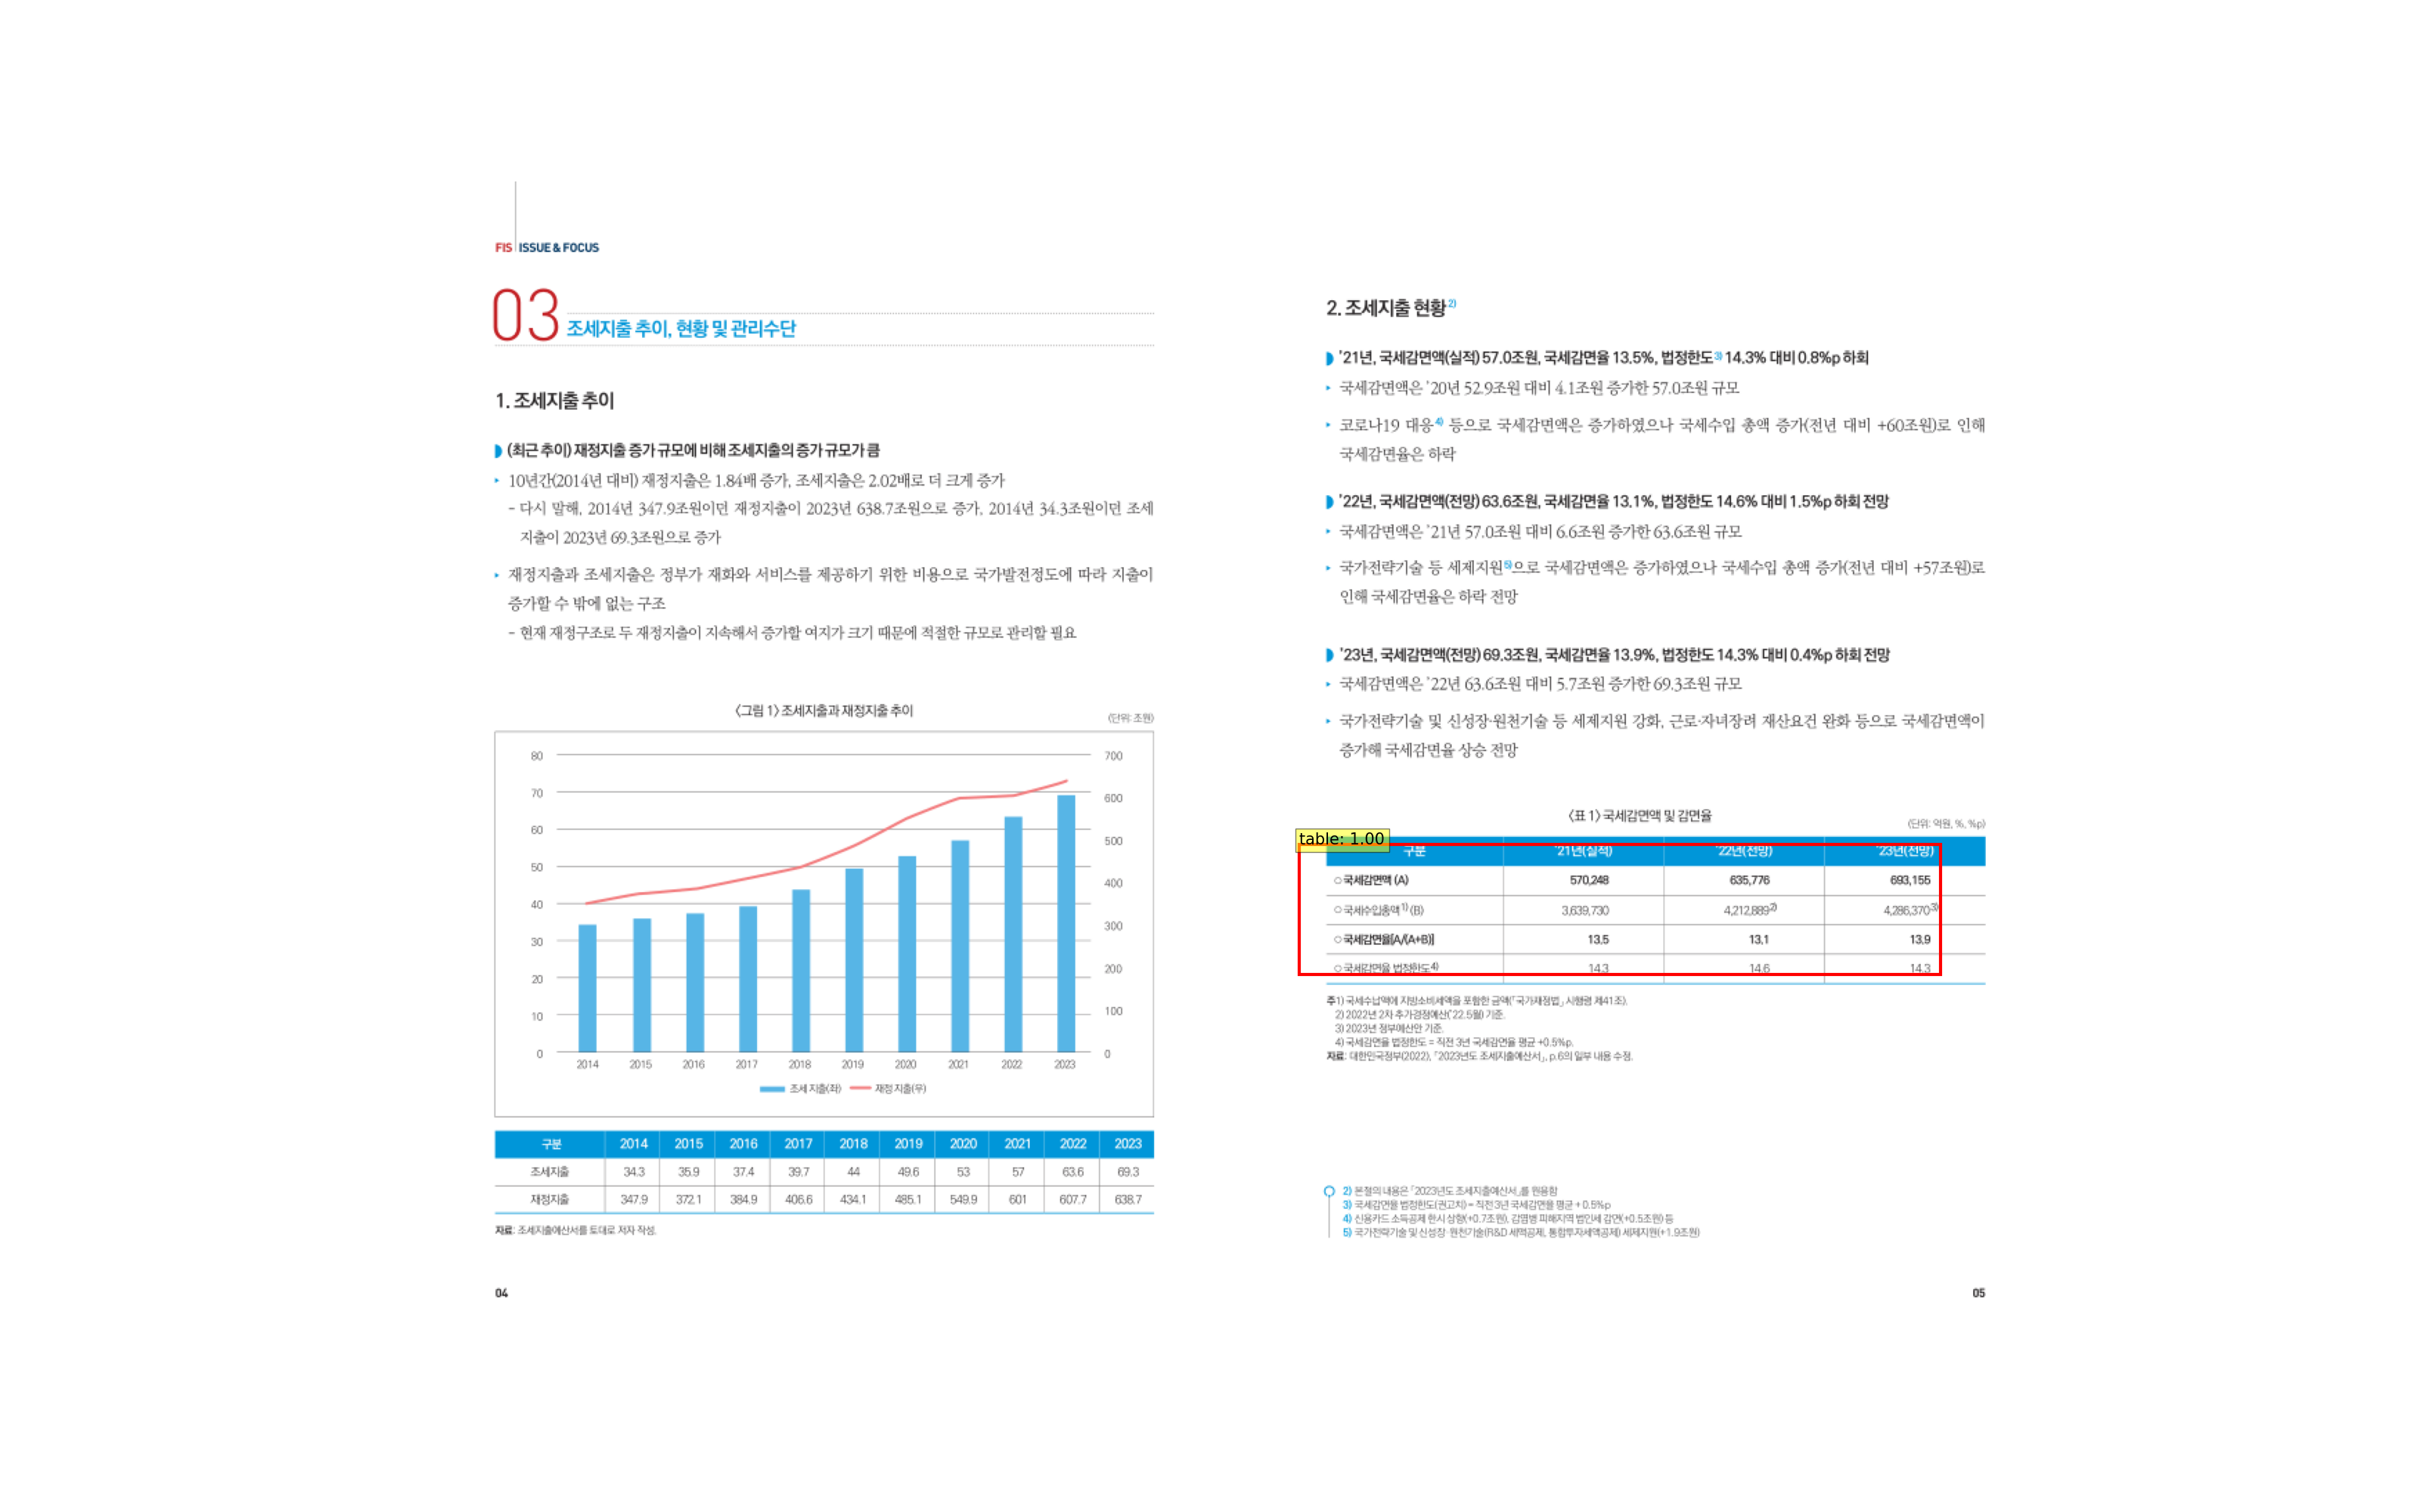

In [73]:
dt = detected[0]['detected']
dt.visualize()

In [98]:
def show_image(item, title=""):
    """Display a pixmap.

    Just to display Pixmap image of "item" - ignore the man behind the curtain.

    Args:
        item: any PyMuPDF object having a "get_pixmap" method.
        title: a string to be used as image title

    Generates an RGB Pixmap from item using a constant DPI and using matplotlib
    to show it inline of the notebook.
    """
    DPI = 450  # use this resolution
    import numpy as np
    import matplotlib.pyplot as plt

    # %matplotlib inline
    pix = item.get_pixmap(dpi=DPI)
    img = np.ndarray([pix.h, pix.w, 3], dtype=np.uint8, buffer=pix.samples_mv)
    plt.figure(dpi=DPI)  # set the figure's DPI
    plt.title(title)  # set title of image
    _ = plt.imshow(img, extent=(0, pix.w * 72 / DPI, pix.h * 72 / DPI, 0))

In [95]:
detected

[{'bbox': (637.7354736328125,
   479.2198486328125,
   1101.4000244140625,
   573.2767333984375),
  'depth': 0,
  'detected': <gmft.detectors.common.CroppedTable at 0x7c33ccb6d450>},
 {'bbox': (49.180999755859375,
   82.06304931640625,
   532.7630615234375,
   99.071044921875),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33d9e6a5c0>},
 {'bbox': (657.7340959821429,
   474.3136850992839,
   1133.8580322265625,
   580.1514892578125),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33d13b69e0>},
 {'bbox': (233.24449920654297,
   654.2186889648438,
   377.57501220703125,
   659.2565002441406),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33ccacd810>},
 {'bbox': (56.7179313659668,
   686.615966796875,
   532.7630615234375,
   746.1434326171875),
  'depth': 0,
  'detected': <pymupdf.table.Table at 0x7c33ccacffa0>},
 {'bbox': (49.180999755859375,
   82.06304931640625,
   532.6629842122396,
   99.071044921875),
  'depth': 1,
  'detected': <pymupdf.table.Table at 0

In [136]:
detected[-1]['detected'].to_markdown()

'|03|Col1|\n|---|---|\n|||\n|||\n\n'

In [129]:
pno=2

0
구분 ’21년(실적) ’22년(전망) ’23년(전망)
○ 국세감면액 (A) 570,248 635,776 693,155
○ 국세수입총액1) (B) 3,639,730 4,212,8892) 4,286,3703)
○ 국세감면율[A/(A+B)] 13.5 13.1 13.9
○ 국세감면율 법정한도4) 14.3 14.6 14.3
0
2
0
2 3
1
|03|Col1|
|---|---|
|||
|||


2
|구분|’21년(실적)|’22년(전망)|’23년(전망)|
|---|---|---|---|
|||||
|||||
|||||
|||||


3
|Col0|Col1|조세 지출(좌) 재정 지출(우)|
|---|---|---|


4
|구분|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|
|---|---|---|---|---|---|---|---|---|---|---|
||||||||||||
||||||||||||


5
|03|Col1|
|---|---|
|||
|||




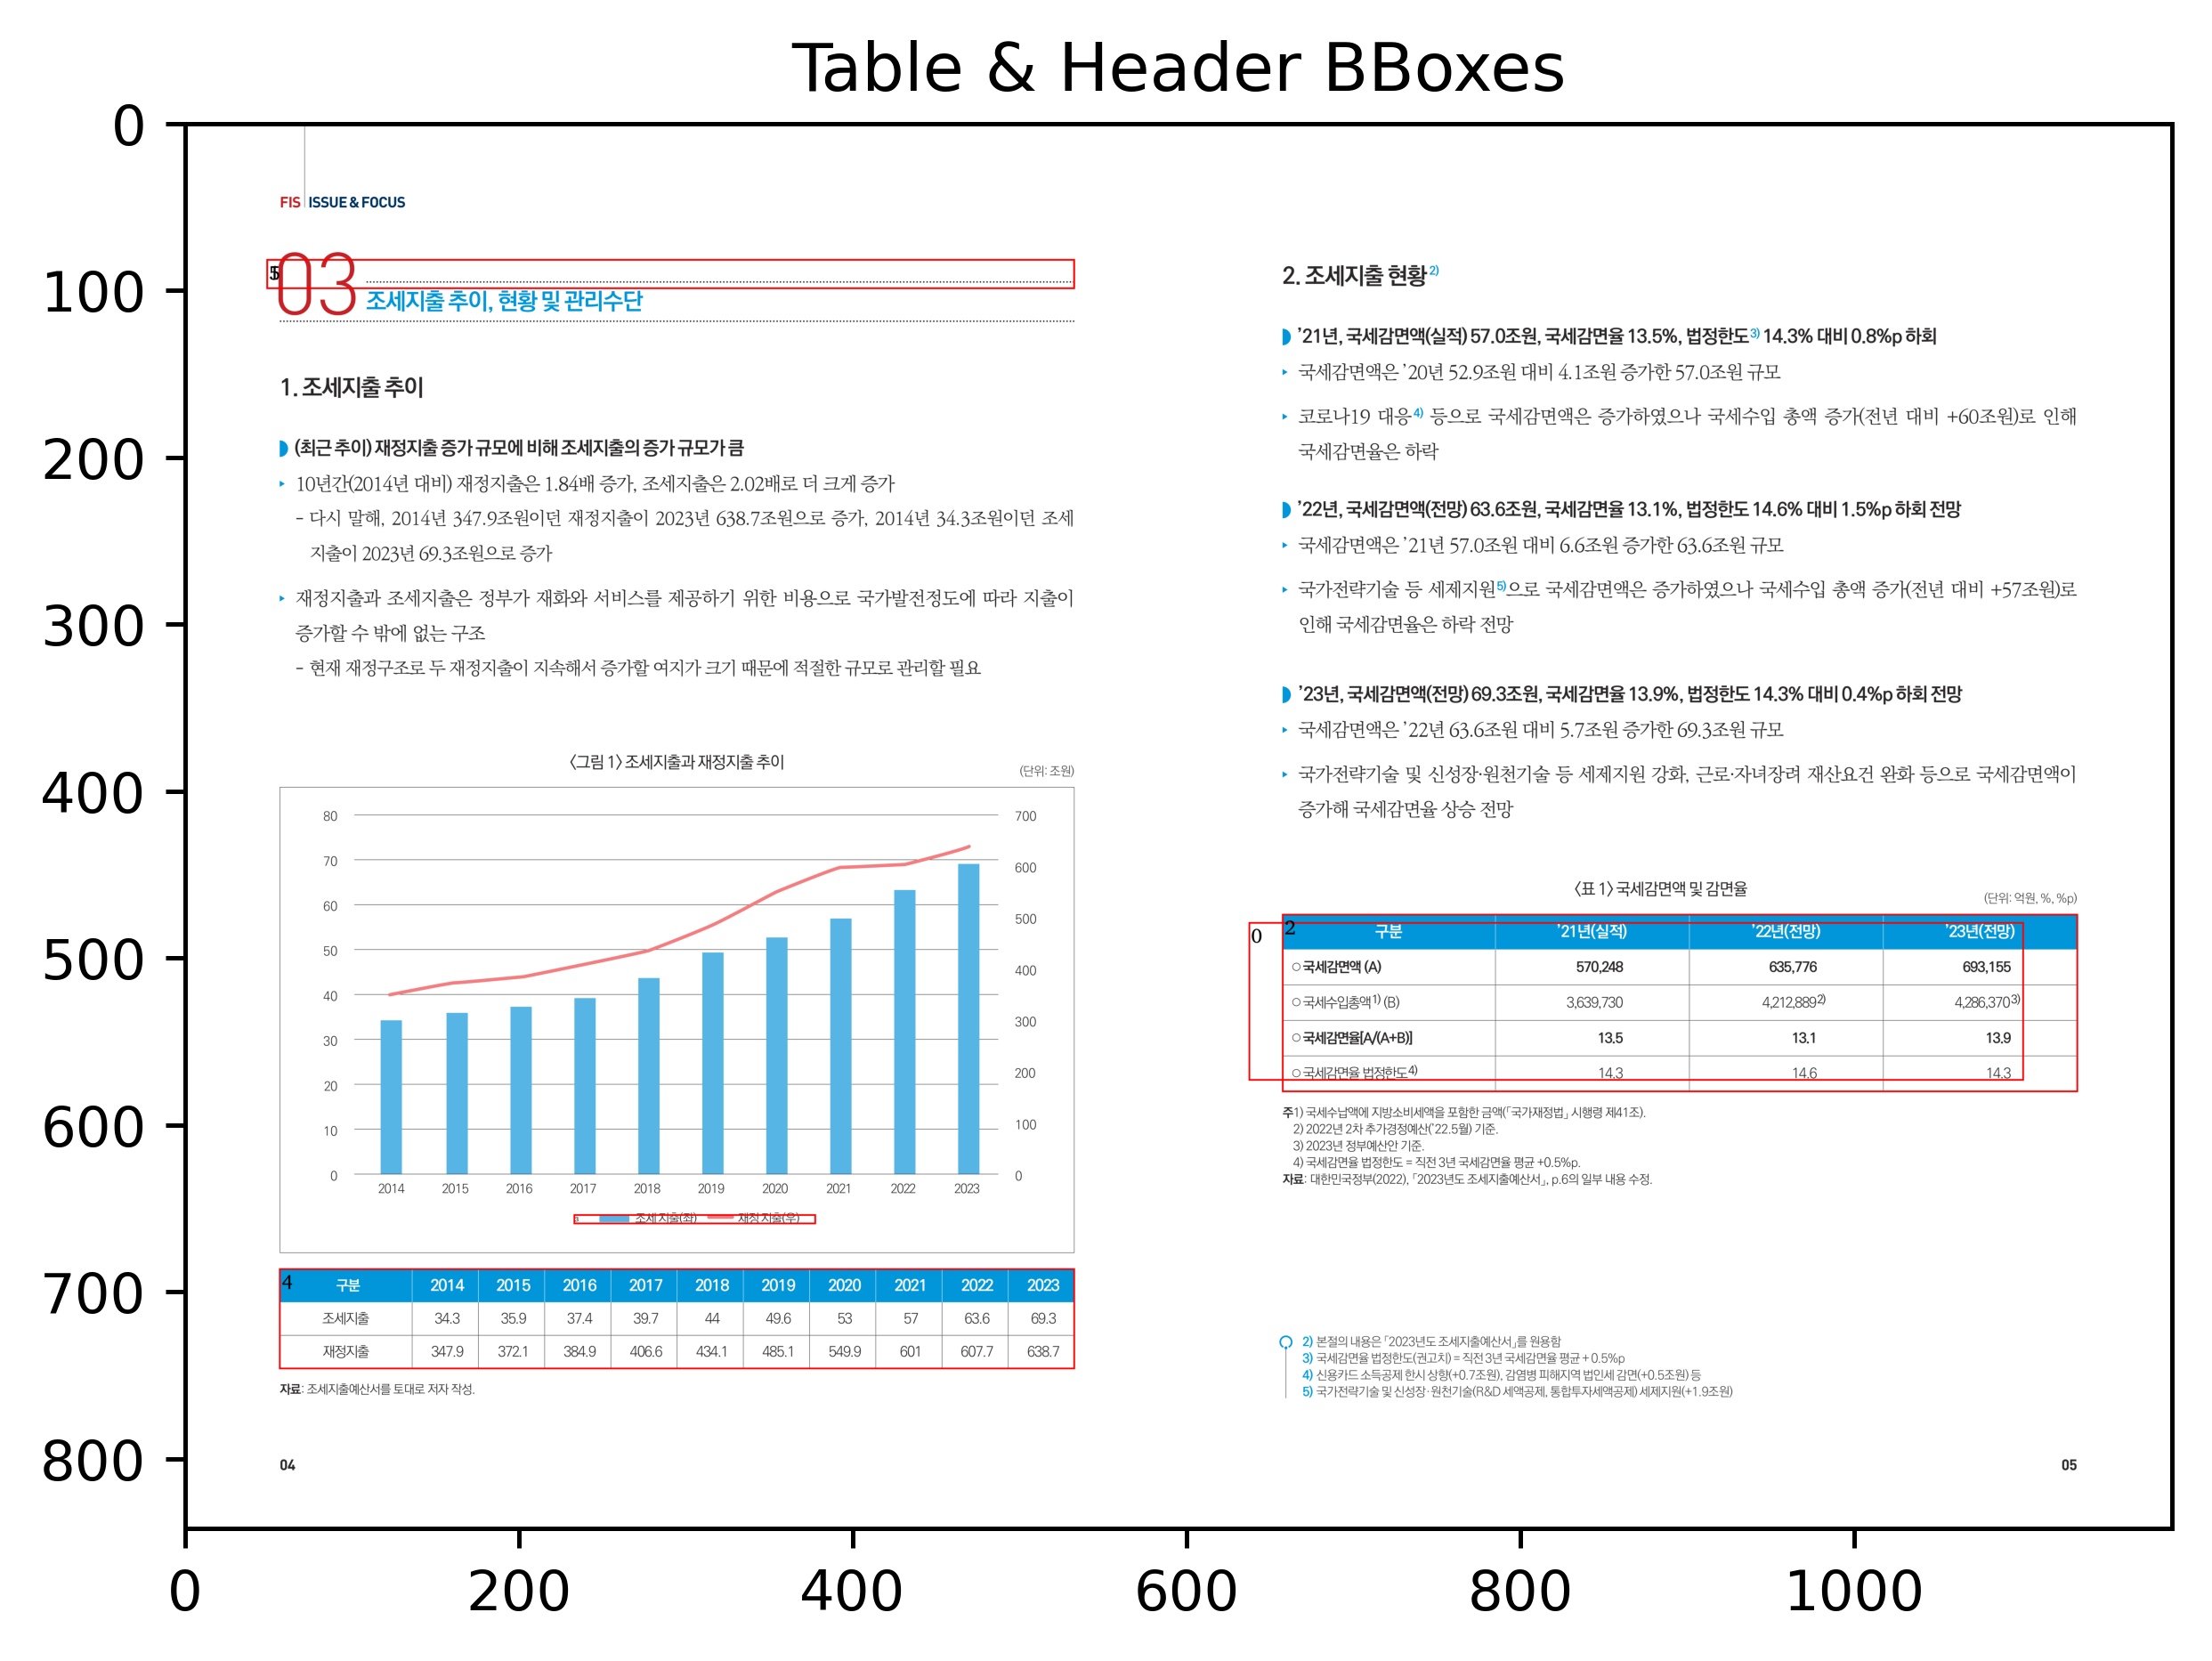

In [137]:
pdf.fullcopy_page(pno)
page_temp = pdf.load_page(-1)

for i,tab in enumerate(detected):  # iterate over all tables
    # for cell in tab.header.cells:
    #     page.draw_rect(cell,color='red',width=0.3)
    area = tab['bbox']
    page_temp.draw_rect(area,color=(1,0,0))
    rc = page_temp.insert_htmlbox(area,str(i),scale_low=0)
    # print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")
    print(i)
    try : print(tab['detected'].text())
    except : print(tab['detected'].to_markdown())

show_image(page_temp, f"Table & Header BBoxes")

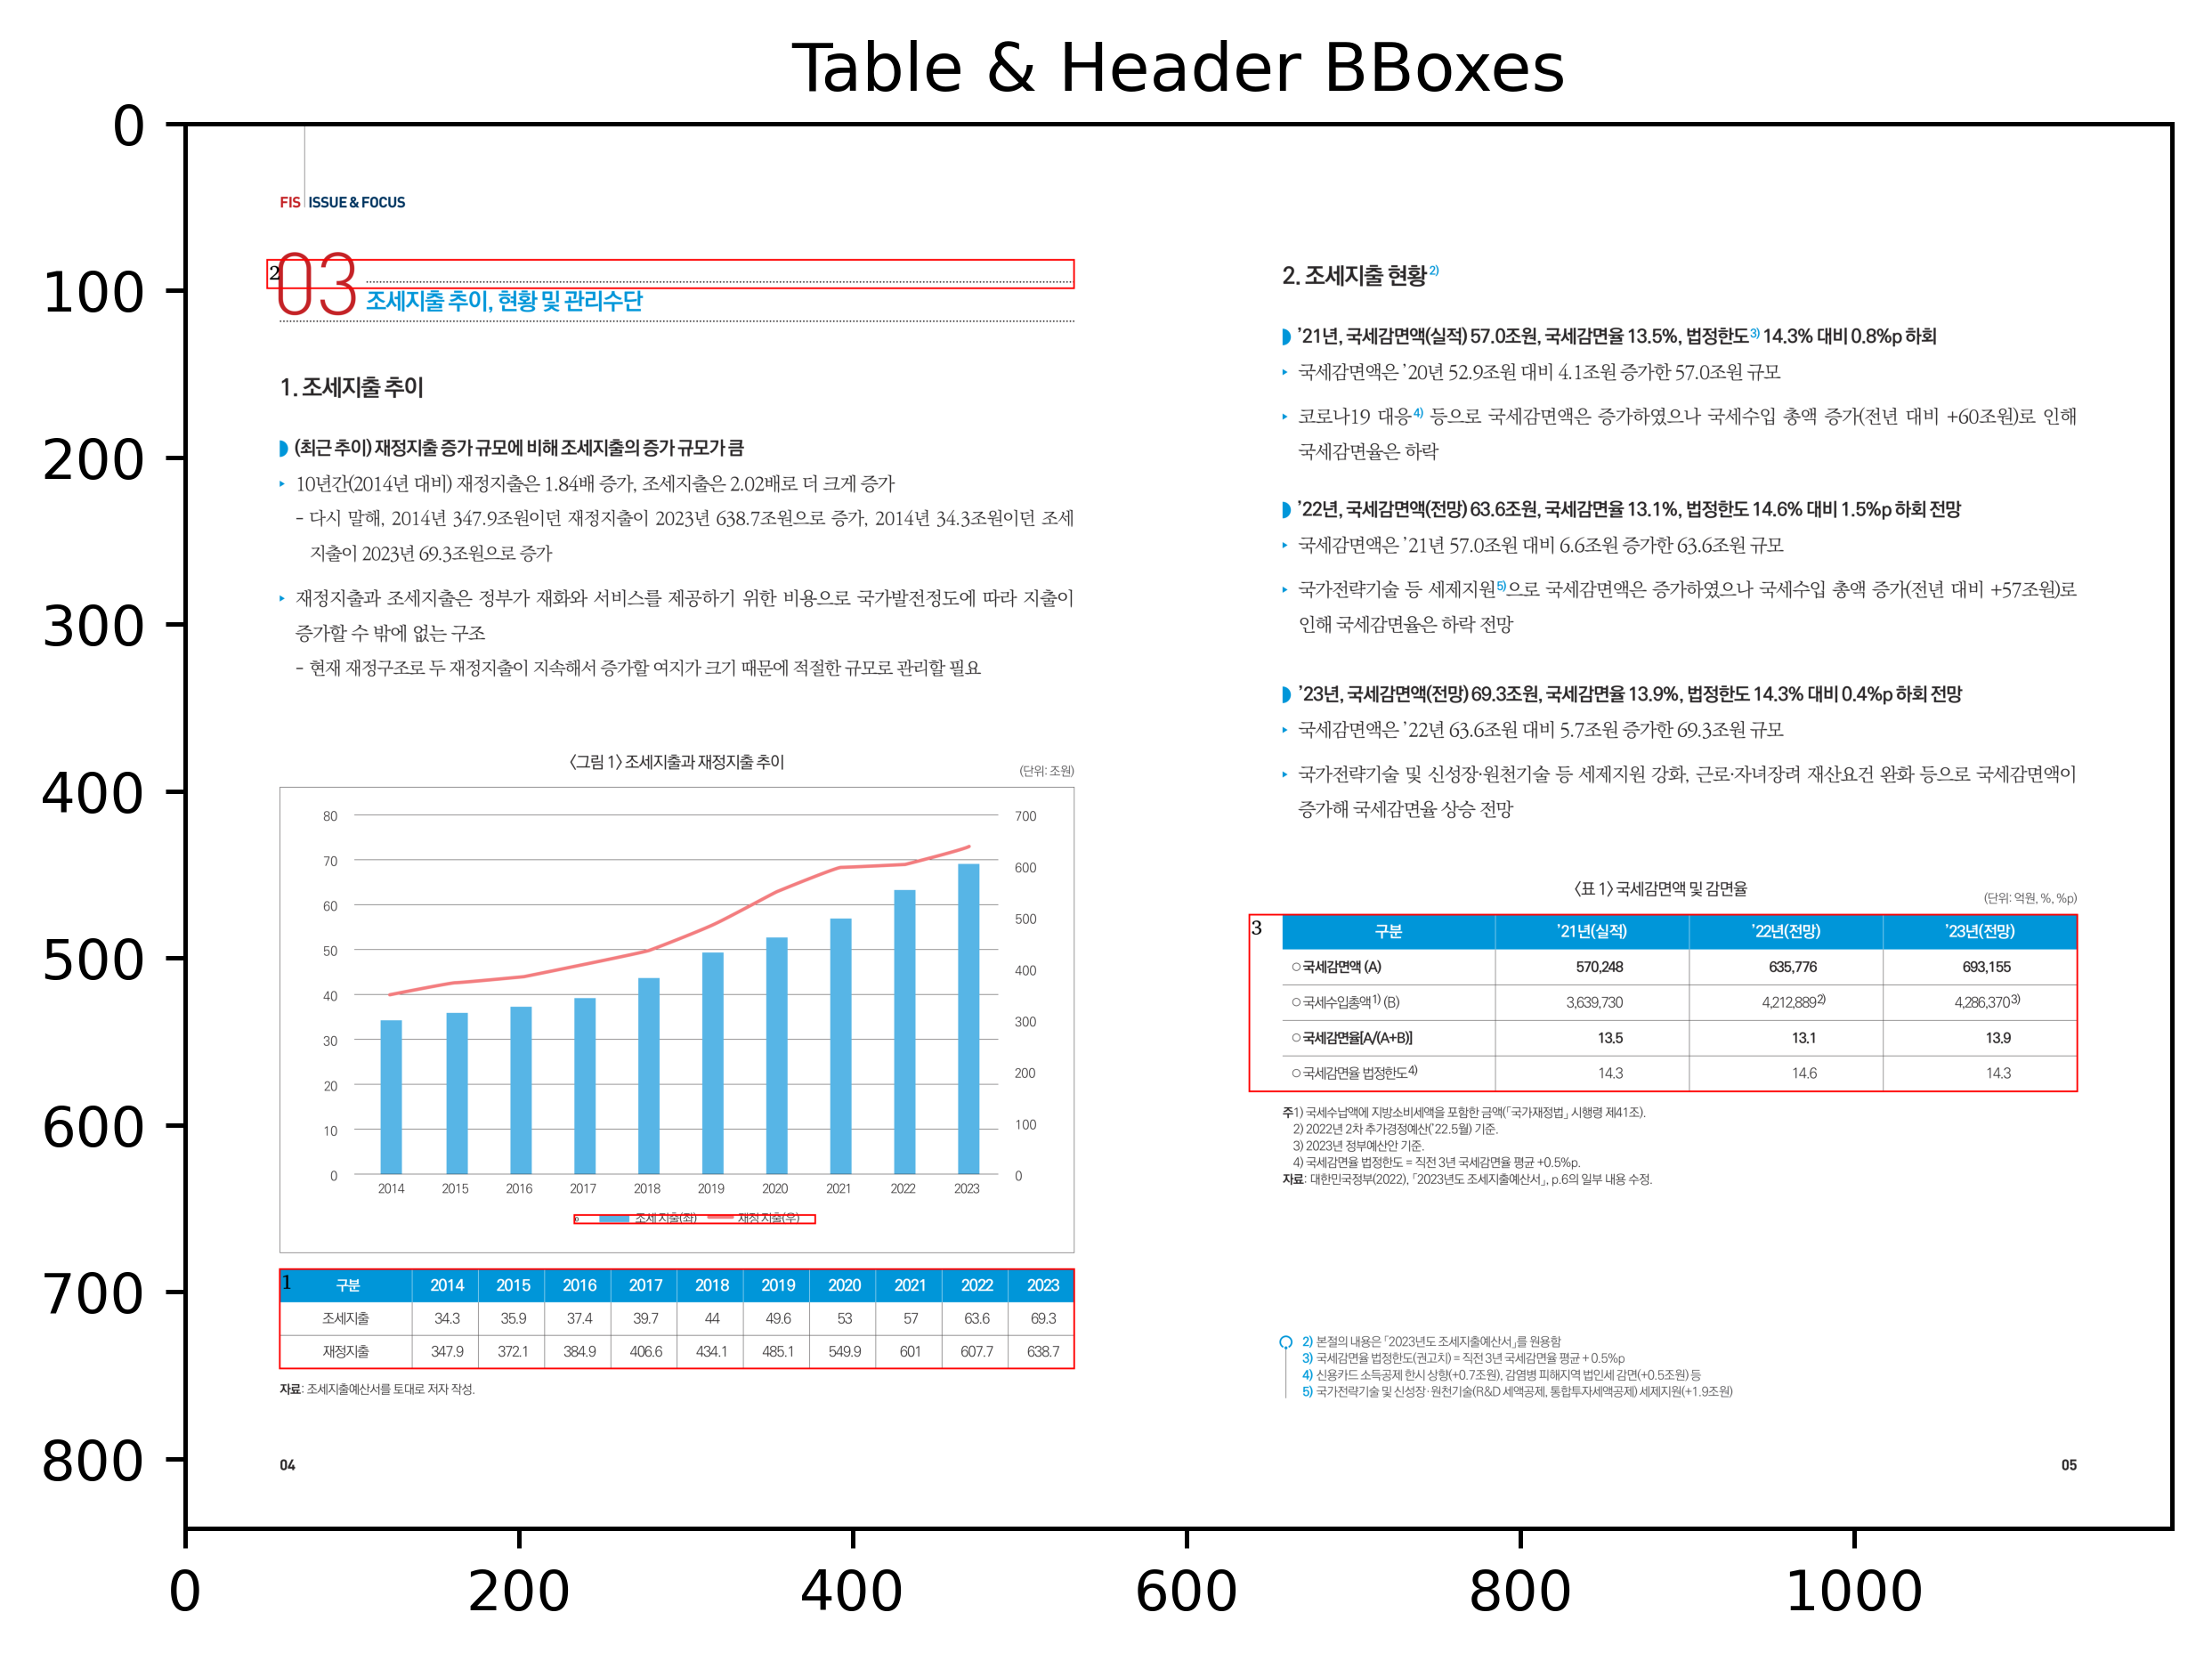

In [130]:
pdf.fullcopy_page(pno)
page_temp = pdf.load_page(-1)

bboxes = list(map(lambda x : x['bbox'],detected))
rslt = organize_box(bboxes,page.mediabox,get_ths(page.mediabox))

for i,tab in enumerate(rslt):  # iterate over all tables
    # for cell in tab.header.cells:
    #     page.draw_rect(cell,color='red',width=0.3)
    page_temp.draw_rect(tab,color=(1,0,0))
    rc = page_temp.insert_htmlbox(tab,str(i),scale_low=0)
    # print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")

show_image(page_temp, f"Table & Header BBoxes")

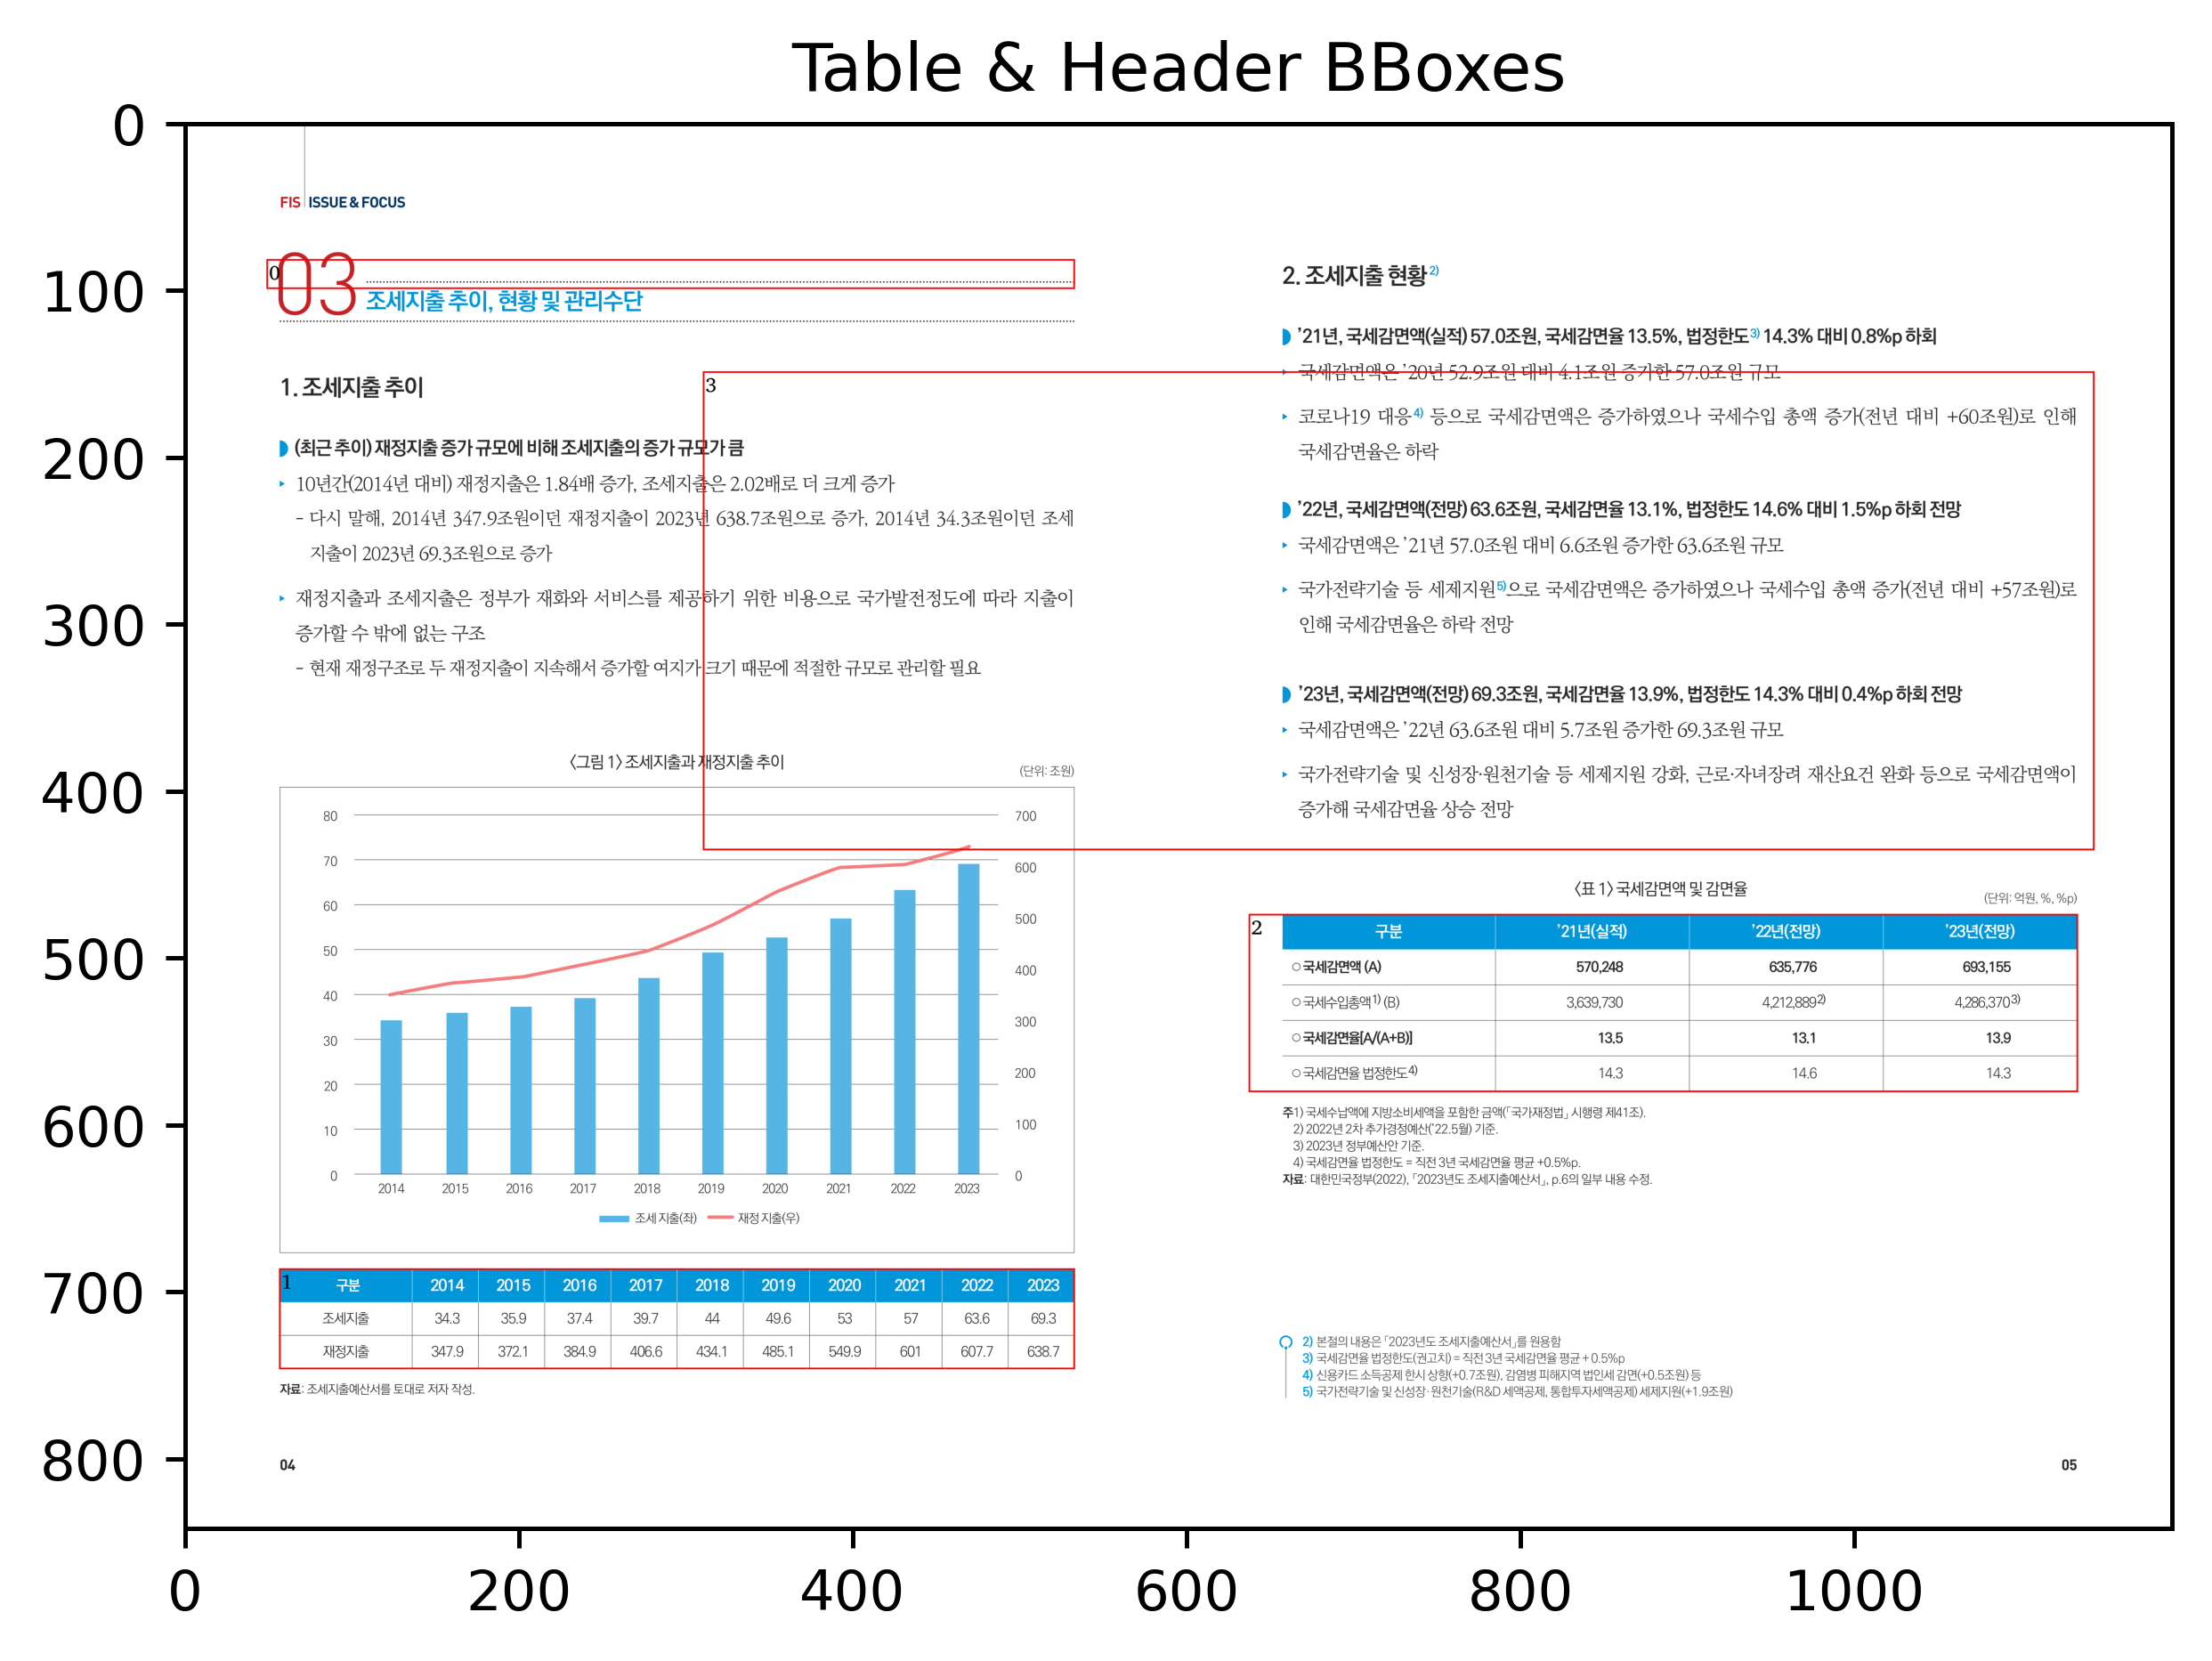

In [140]:
detected = search_page(page,page.mediabox,get_ths(page.mediabox))

pdf.fullcopy_page(pno)
page_temp = pdf.load_page(-1)

for i,tab in enumerate(detected):  # iterate over all tables
    # for cell in tab.header.cells:
    #     page.draw_rect(cell,color='red',width=0.3)
    area = tab['bbox']
    page_temp.draw_rect(area,color=(1,0,0))
    rc = page_temp.insert_htmlbox(area,str(i),scale_low=0)
    # print(f"Table {i} column names: {tab.header.names}, external: {tab.header.external}")

show_image(page_temp, f"Table & Header BBoxes")


In [104]:
rslt

[(233.24449920654297,
  654.2186889648438,
  377.57501220703125,
  659.2565002441406),
 (56.7179313659668, 686.615966796875, 532.7630615234375, 746.1434326171875),
 (49.180999755859375, 82.06304931640625, 532.6629842122396, 99.071044921875),
 (637.7354736328125, 474.3136850992839, 1133.8580322265625, 580.1514892578125)]

In [50]:
formatter = define_formatter()
a = make_table_debug(detected[3]['bbox'],PyMuPDFPage(page),page.mediabox,formatter)
a

Filling in gap at top of table


{'content':                                           \
 0                                   None   
 1                                  규모가 큼   
 2                   조세지출은 2.02배로 더 크게 증가   
 3  2023년 638.7조원으로 증가, 2014년 34.3조원이던 조세   
 4            제공하기 위한 비용으로 국가발전정도에 따라 지출이   
 5                  크기 때문에 적절한 규모로 관리할 필요   
 6                  크기 때문에 적절한 규모로 관리할 필요   
 7                                재정지출 추이   
 8                               (단위: 조원)   
 9                                    700   
 
            국세감면액은 ’20년 52.9조원 대비 4.1조원 증가한 57.0조원 규모  
 0  코로나19 대응4) 등으로 국세감면액은 증가하였으나 국세수입 총액 증가(전년 대비 ...  
 1                                          국세감면율은 하락  
 2                                               None  
 3  ’22년, 국세감면액(전망) 63.6조원, 국세감면율 13.1%, 법정한도 14.6...  
 4  국가전략기술 등 세제지원5)으로 국세감면액은 증가하였으나 국세수입 총액 증가(전년 ...  
 5                                    인해 국세감면율은 하락 전망  
 6  ’23년, 국세감면액(전망) 69.3조원, 국세감면율 13.9%, 법정한도 14.3...  
 7          국세감면액은 ’22년 63.6조원 대비 5.7조원 증가한 

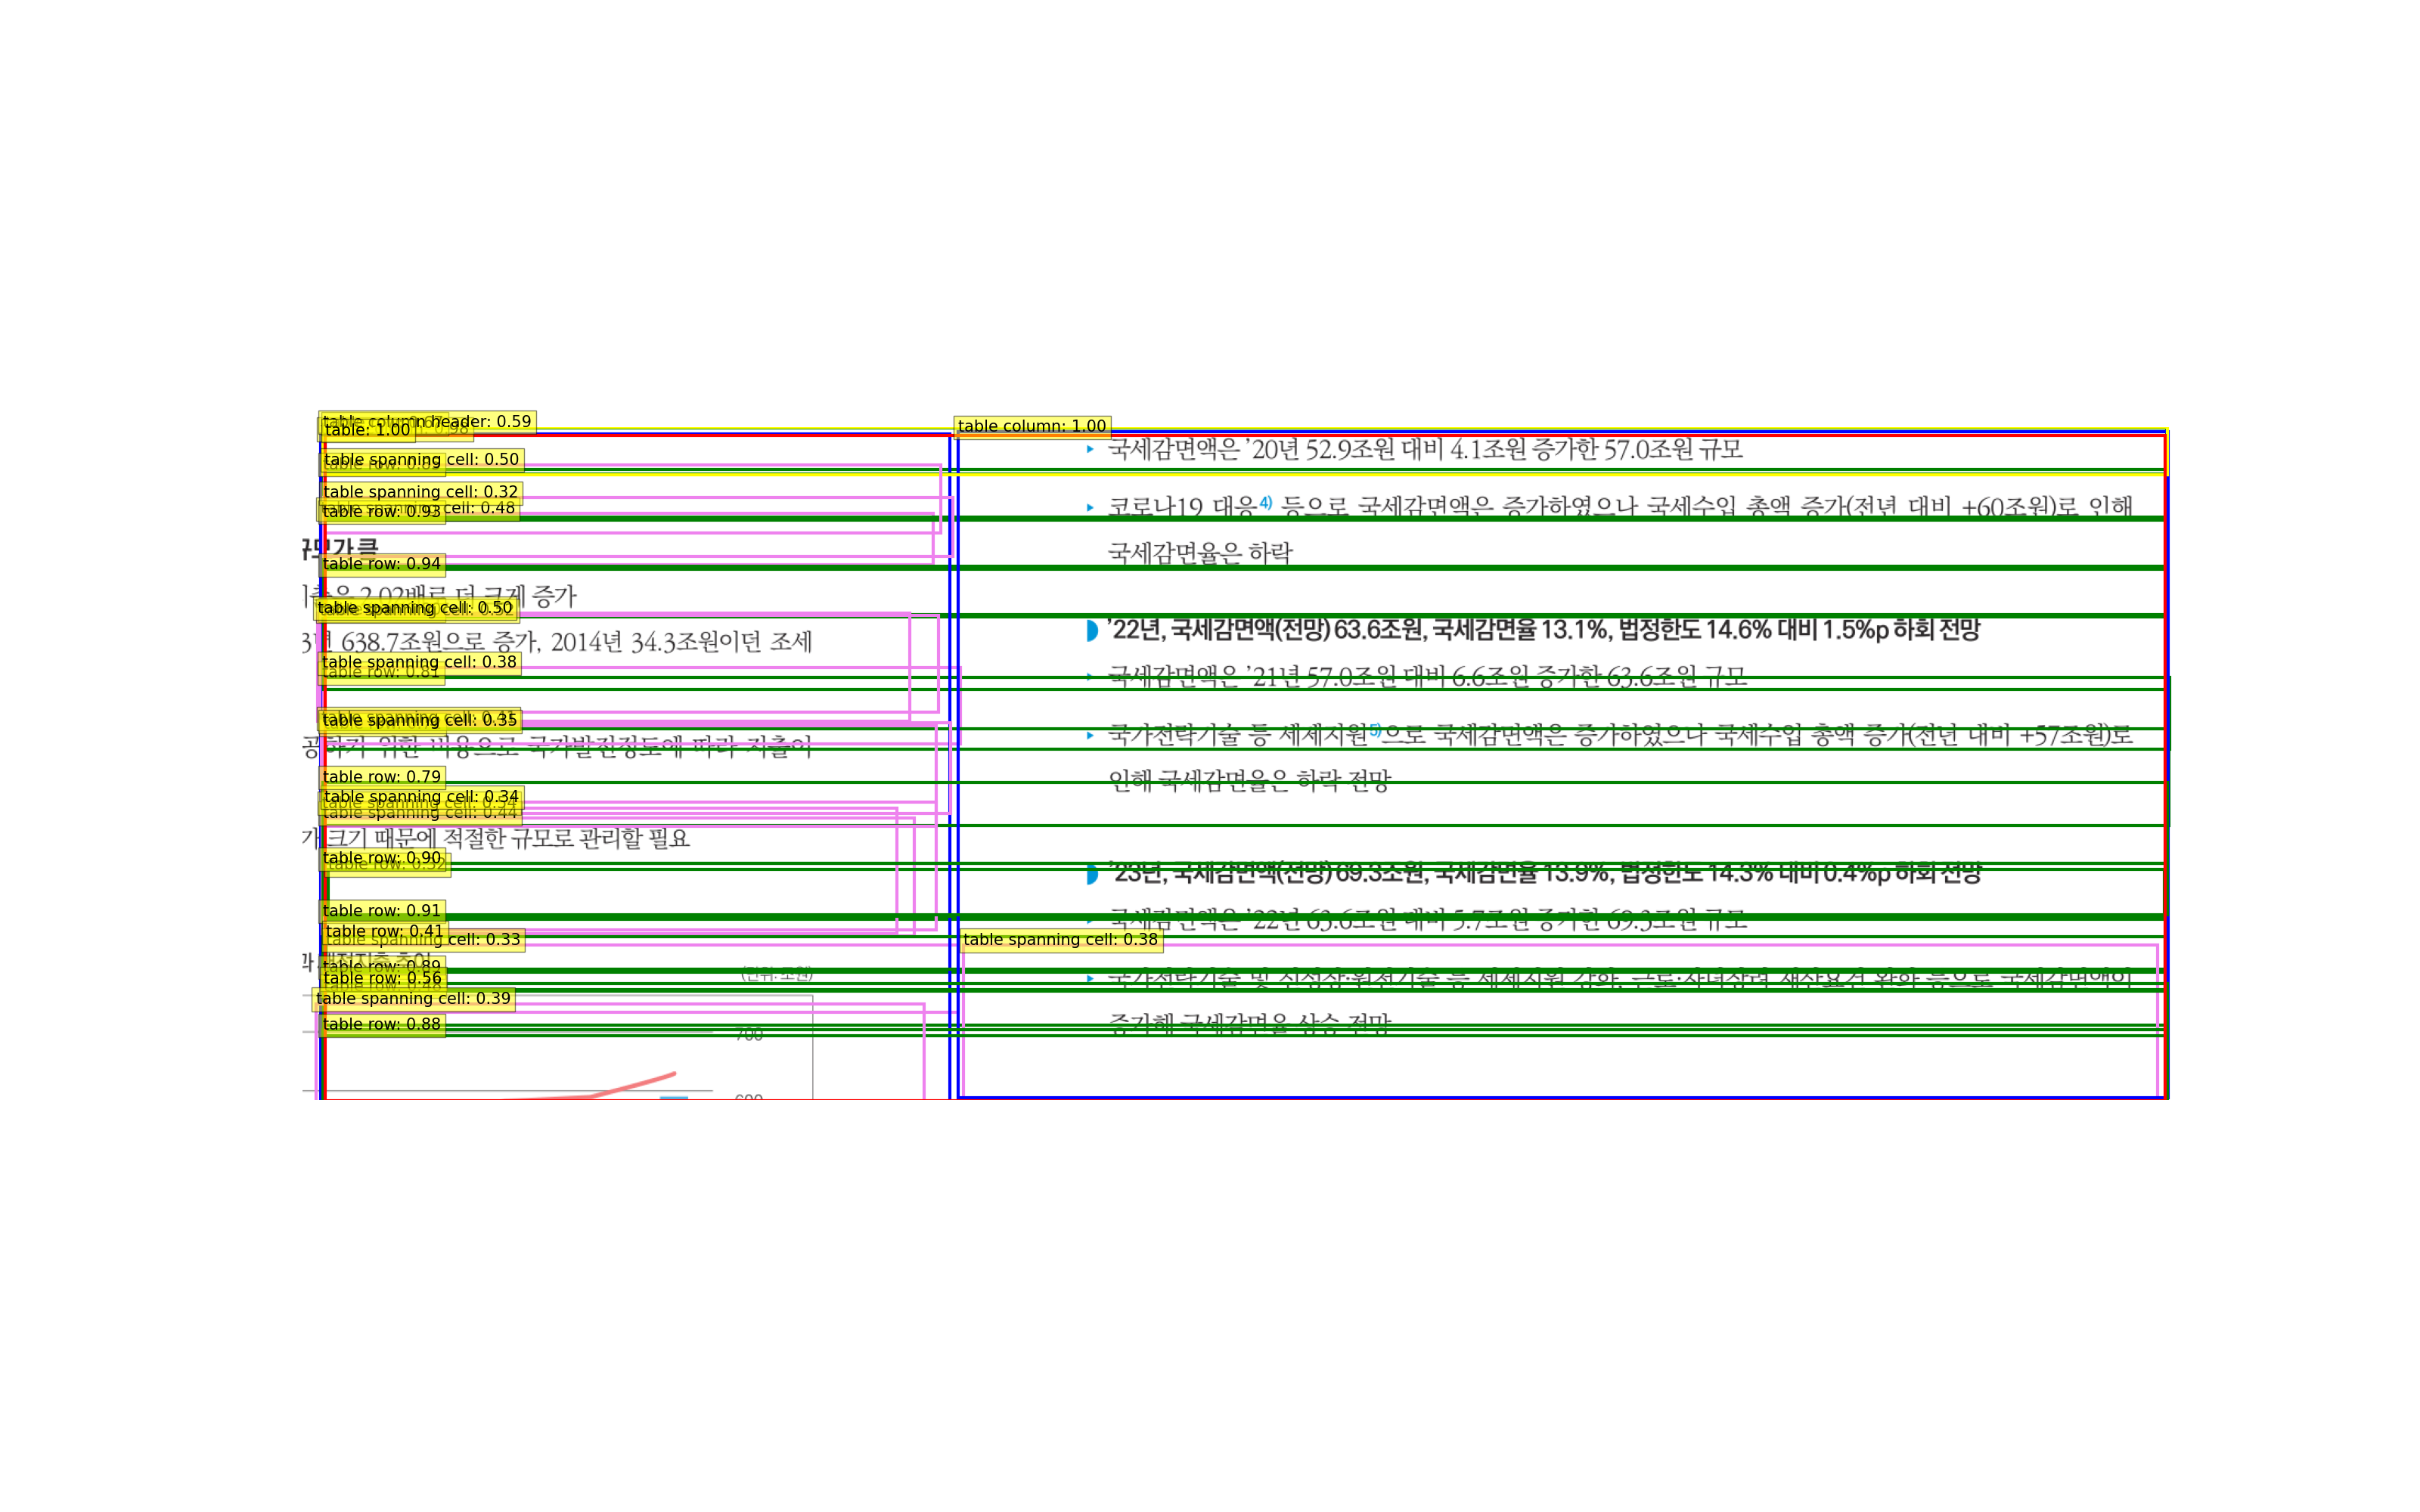

In [51]:
a['ft'].visualize()

In [53]:
a['ft'].df()

\
0                                   None   
1                                  규모가 큼   
2                   조세지출은 2.02배로 더 크게 증가   
3  2023년 638.7조원으로 증가, 2014년 34.3조원이던 조세   
4            제공하기 위한 비용으로 국가발전정도에 따라 지출이   
5                  크기 때문에 적절한 규모로 관리할 필요   
6                  크기 때문에 적절한 규모로 관리할 필요   
7                                재정지출 추이   
8                               (단위: 조원)   
9                                    700   

           국세감면액은 ’20년 52.9조원 대비 4.1조원 증가한 57.0조원 규모  
0  코로나19 대응4) 등으로 국세감면액은 증가하였으나 국세수입 총액 증가(전년 대비 ...  
1                                          국세감면율은 하락  
2                                               None  
3  ’22년, 국세감면액(전망) 63.6조원, 국세감면율 13.1%, 법정한도 14.6...  
4  국가전략기술 등 세제지원5)으로 국세감면액은 증가하였으나 국세수입 총액 증가(전년 ...  
5                                    인해 국세감면율은 하락 전망  
6  ’23년, 국세감면액(전망) 69.3조원, 국세감면율 13.9%, 법정한도 14.3...  
7          국세감면액은 ’22년 63.6조원 대비 5.7조원 증가한 69.3조원 규모  
8  국가전략기술 및 신성장·원천기술 등 세제지원 강화, 근로·자녀장려 재산요건 완화 등...  
9                                               None

In [52]:
get_ft_bbox(a['ft'],a['ft'].rect.bbox)

(310.6787414550781, 149.2873191833496, 1143.699462890625, 435.2646179199219)

In [67]:
get_ft_bbox(a['ft'],page.mediabox)

(81.0404764811198, 271.55999840630426, 446.848627726237, 505.1236504448785)

In [70]:
a['ft'].rect.bbox

(70.86593119303386, 269.732170952691, 453.54400634765625, 511.1343994140625)

In [71]:
print(organize_box(a['ft'].fctn_results['boxes'],page.mediabox,ths)[0])
print(organize_box(a['ft'].fctn_results['boxes'],a['ft'].rect.bbox,ths)[0])
# return infer_bbox_pos(ft.rect.bbox,rslt) #expand_bbox_by_ths(rslt,area,ths)

(10.174545288085938, 1.8278274536132812, 375.9826965332031, 235.3914794921875)
(70.86593119303386, 269.732170952691, 375.9826965332031, 269.732170952691)


\
0            구 분    ’23년    ’24년           None   
1       발달장애인 지원   2,569   3,577   최중증 (2,340명)   
2        장애인활동지원  19,919  22,846             대상   
3       장애아동가족지원   1,757   1,940          장애아돌봄   
4      장애인 고용장려금   2,977   3,234           지원대상   
5  장애인취업성공패키지 지원     210     247         조기취업수당   
6         장애인 연금   8,326   8,787  기초급여 월 부가급여 월   

                                                (단위:   억원)  
0                                                 비고  None  
1               발달장애인 1:1 돌봄 체계 구축 주간활동(1.0 → 1.1만명)  None  
2  11.5 → 12.4만명 가산급여 대상·단가 인상(0.6 → 1.0만명, 월 30 ...  None  
3      발달재활서비스 대상 7.9 → 8.6만명 시간 확대(연 960 → 1,080시간)  None  
4                                  확대(61.1 → 63.3만명)  None  
5                              지원대상(1.1 → 1.3만명), 신설  None  
6                          32.3 → 33.5만원 2~7 → 3~8만원  None

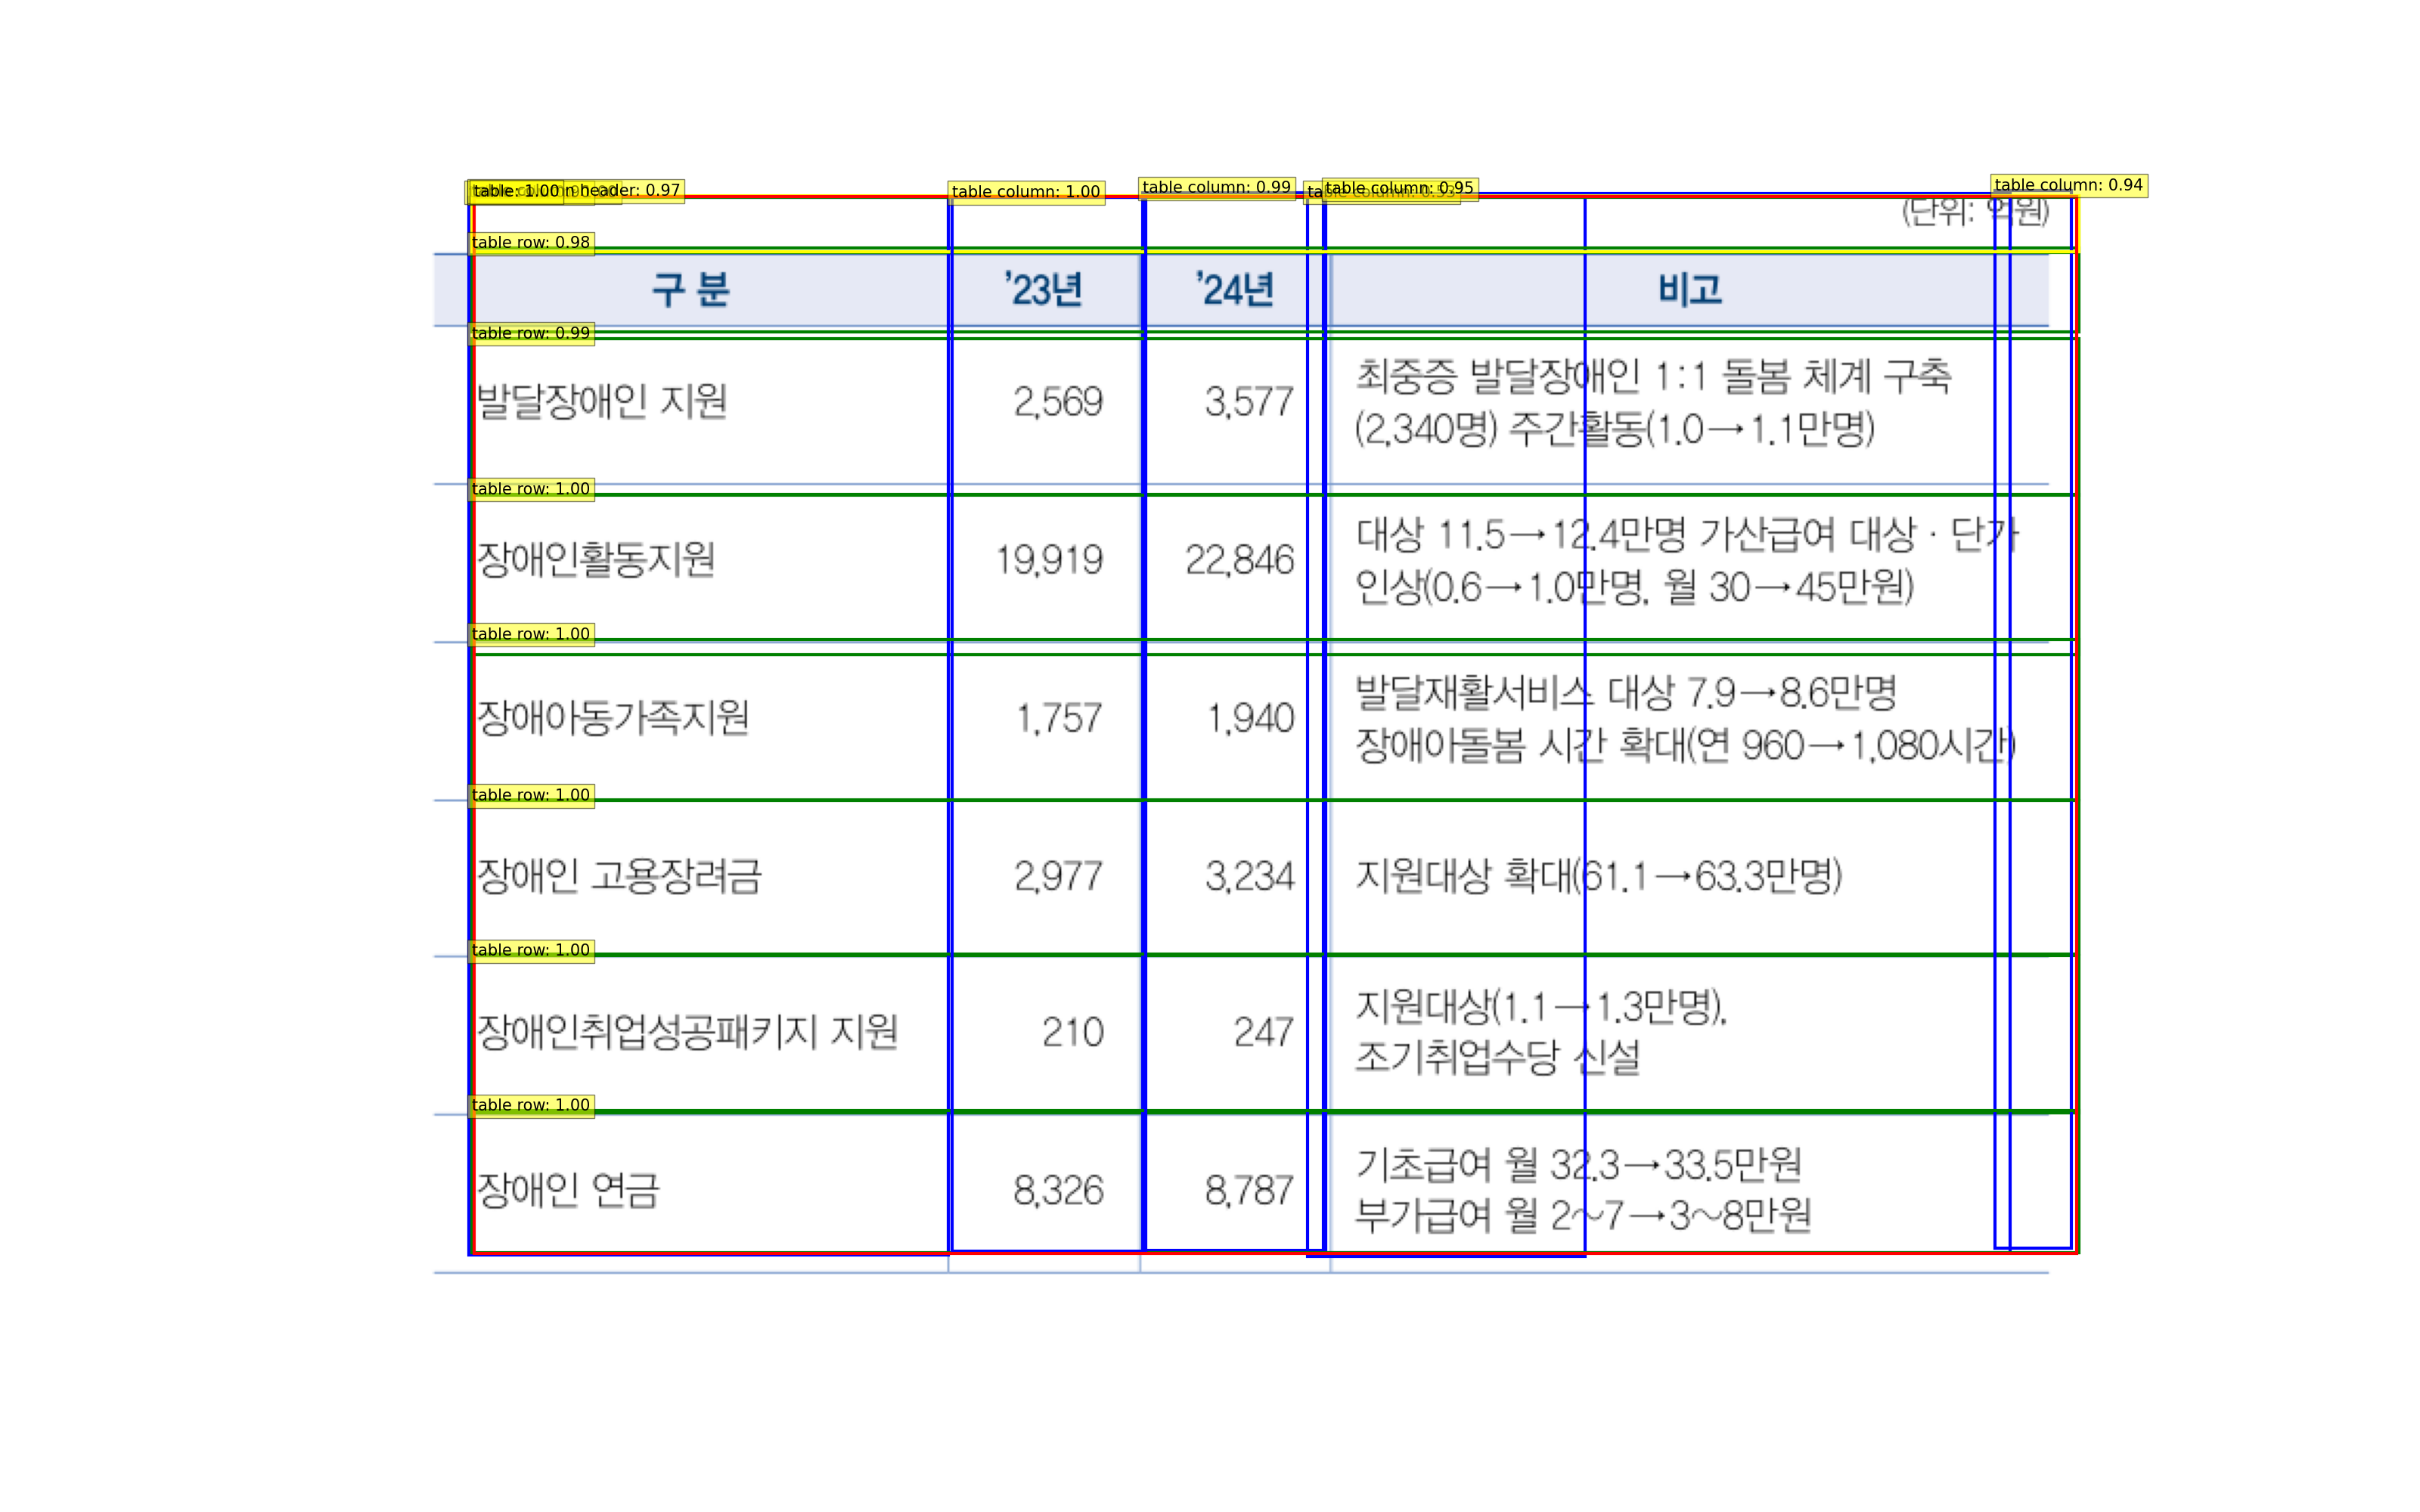

exception :  ('too small area :', (70.86593119303386, 269.732170952691, 453.54400634765625, 511.1343994140625), (80.59500412394206, 262.8042957939996, 460.2627630655925, 269.382527605523), 6.927875158691407)


\
0            구 분    ’23년    ’24년           None   
1       발달장애인 지원   2,569   3,577   최중증 (2,340명)   
2        장애인활동지원  19,919  22,846             대상   
3       장애아동가족지원   1,757   1,940          장애아돌봄   
4      장애인 고용장려금   2,977   3,234           지원대상   
5  장애인취업성공패키지 지원     210     247         조기취업수당   
6         장애인 연금   8,326   8,787  기초급여 월 부가급여 월   

                                                (단위:   억원)  
0                                                 비고  None  
1               발달장애인 1:1 돌봄 체계 구축 주간활동(1.0 → 1.1만명)  None  
2  11.5 → 12.4만명 가산급여 대상·단가 인상(0.6 → 1.0만명, 월 30 ...  None  
3      발달재활서비스 대상 7.9 → 8.6만명 시간 확대(연 960 → 1,080시간)  None  
4                                  확대(61.1 → 63.3만명)  None  
5                              지원대상(1.1 → 1.3만명), 신설  None  
6                          32.3 → 33.5만원 2~7 → 3~8만원  None

In [72]:
make_table_debug(detected[1],PyMuPDFPage(page),page.mediabox,formatter,get_ths(page.mediabox))

In [56]:
a['ft'].__dict__

{'_df':              구 분    ’23년    ’24년  \
 0       발달장애인 지원   2,569   3,577   
 1        장애인활동지원  19,919  22,846   
 2       장애아동가족지원   1,757   1,940   
 3      장애인 고용장려금   2,977   3,234   
 4  장애인취업성공패키지 지원     210     247   
 5         장애인 연금   8,326   8,787   
 
                                                   비고  
 0  최중증 발달장애인 1:1 돌봄 체계 구축 (2,340명) 주간활동(1.0 → 1.1만명)  
 1  대상 11.5 → 12.4만명 가산급여 대상·단가 인상(0.6 → 1.0만명, 월 ...  
 2  발달재활서비스 대상 7.9 → 8.6만명 장애아돌봄 시간 확대(연 960 → 1,0...  
 3                             지원대상 확대(61.1 → 63.3만명)  
 4                       지원대상(1.1 → 1.3만명), 조기취업수당 신설  
 5            기초급여 월 32.3 → 33.5만원 부가급여 월 2~7 → 3~8만원  ,
 'page': <gmft_pymupdf.bindings_mu.PyMuPDFPage at 0x7aeed1e2ab60>,
 'rect': <gmft.common.Rect at 0x7aef660cae60>,
 'confidence_score': 0.85,
 '_img': <PIL.Image.Image image mode=RGB size=919x636>,
 '_img_dpi': 144,
 '_img_padding': (76, 76, 76, 76),
 '_img_margin': None,
 'label': 0,
 '_word_height': 8.796458435058593,
 '_captions': ('[표

In [66]:
bbox,doc,area,ths = detected[1],PyMuPDFPage(page),page.mediabox,get_ths(page.mediabox)
rect = gmft.common.Rect(expand_bbox_by_ths(bbox,area,ths))
temp = gmft.table_detection.CroppedTable(doc,rect,0.85) #confidence level 조정이 표 인식에 영향 있을지도
ft = formatter.extract(temp)
#display(ft.rect.bbox,ft.visualize())
tab_box = get_ft_bbox(ft,area,ths)

print(tab_box)

caption = '\t'.join(ft.captions()) if 'captions' in ft.__dir__() else ''
df_tab = ft.df()
if not larger_v_ths(tab_box,ths) : print('too small area :',bbox,tab_box,ths)

(80.59500412394206, 262.8042957939996, 460.2627630655925, 269.382527605523)
too small area : (70.86593119303386, 269.732170952691, 453.54400634765625, 511.1343994140625) (80.59500412394206, 262.8042957939996, 460.2627630655925, 269.382527605523) 6.927875158691407


In [ ]:
#check_table_df_soundness(detected[0])
df_temp = detected[0].replace(to_replace=[None], value=0).astype(str)
df_temp = df_temp.fillna('').astype(str)
val = '0'
cols =range(len(df_temp.columns))
df_temp.columns =cols
cond = df_temp == val
for col in cols:
  display(np.sum(cond[col]))
#target = list(filter(lambda col : np.sum(cond[col]) != len(cond),cols))
#erase_constant_rowcol(df_temp,'0')

In [ ]:
ls {PROCESSEDDIR}/train_source

In [ ]:
errs = load_pkl(os.path.join(PROCESSEDDIR,'train_source','err_1-1 2024 주요 재정통계 1권.pkl'))
len(errs)

In [ ]:
errs[6]

In [ ]:
def check_table_df_soundness(df,ths=0.5):
  if len(df) < 1 : return False
  df_temp = df.replace(to_replace=None, value=0).astype(str)
  if maybe_numeric_table(df_temp) : return True
  df_temp = df.replace(to_replace=None, value='PD_NONE')
  cols = list(df.columns.astype(np.string_))
  cols = list(map(lambda x : '' if x is None else str(x),cols))
  cols = list(map(lambda x : re.sub(r'[\s]*','',x),cols))
  null_col = list(filter(lambda x: len(x)<1,cols))
  if len(null_col) > len(cols) * ths : return False
  if np.sum(df_temp=='PD_NONE') > len(df)*len(cols)*ths : return False
  return True


def maybe_numeric_table(df,ths=0.35):
  df_temp = df.fillna('').astype(str)
  df_temp = df.replace(r'(?:(\d+?)),(\d+?)',r'\1\2',regex=True)
  df_temp = df_temp[list(df_temp.columns)].apply(pd.to_numeric,errors='coerce')
  rslt = ~df_temp.isna()
  rowwise = rslt.apply(sum,axis=1)
  colwise = rslt.apply(sum,axis=0)
  if np.sum(rowwise == len(rslt)) > 0 : return True
  if np.sum(colwise== len(rslt.columns)) > 0 : return True
  if np.sum(rslt.values) > len(rslt)*len(rslt.columns)*ths : return True
  return False

In [ ]:
bad = [{"index":0,"":"2018년부터 발간한 ｢주요 재정통계｣는 디지털예산회계시스템의 재정정보를"},{"index":1,"":"계에 따른 시계열 통계로 구성･제공하고 있습니다. 아울러 중앙-지방정부 등 여러"},{"index":2,"":"산재되어 있는 재정통계를 수록하여 재정분석의 기초자료로 활용될 수 있도록"},{"index":3,"":"다. 또한 단순 정보전달에 그치지 않고, 일반 국민도 쉽게 이해할 수 있도록 재정통계의 가독성을 높이고자 노력하였습니다."},{"index":4,"":"특히, 올해부터는 한권으로 제공되던 ｢주요 재정통계｣를 Ⅰ, Ⅱ 권으로 분권하여,"},{"index":5,"":"편의성을 제고하고자 하였습니다. <제Ⅰ권>에서 우리나라의 재정체계, 주요 재정지표"},{"index":6,"":"재정 전반에 대한 이해를 돕기 위해 주요 재정 제도의 설명과 함께 관련 통계를 수록하였고,"},{"index":7,"":"OECD, IMF 회원국 간 재정 동향을 비교･분석할 수 있는 통계로 구성하였습니다."},{"index":8,"":"<제Ⅱ권>에서는 예산체계에 따른 16대 분야별 재정 구조와 추이, 사업유형별 주요사업 정보를 담아 각 분야별 재정지출에 대한 이해도를 높일 수 있도록 구성하였습니다. 이와 함께, 부록에서는 국내 핵심 재정 통계를 선정하여 10년 이상의 장기 시계열"},{"index":9,"":"표를 추가 제공하였습니다."},{"index":10,"":"한국재정정보원은 ｢2024 주요 재정통계｣가 국민들의 재정에 대한 이해도를"},{"index":11,"":"재정당국에게는 재정정책 수립의 기초자료로 활용되길 바랍니다. 앞으로 시의적절함과"},{"index":12,"":"동시에 정합성을 담보한 다양한 재정자료를 지속적으로 제공할 수 있도록 최선을 습니다."},{"index":13,"":"2024년"}]
df = pd.DataFrame(bad)
df_temp = df.replace(to_replace=[None], value=0).astype(str)
df_temp = df_temp.fillna('').astype(str)
df_temp = df.replace(r'(?:(\d+?)),(\d+?)',r'\1\2',regex=True)
df_temp = df_temp[list(df_temp.columns)].apply(pd.to_numeric,errors='coerce')
rslt = ~df_temp.isna()
rowwise = rslt.apply(sum,axis=1)
colwise = rslt.apply(sum,axis=0)

In [ ]:
np.sum(rowwise)

In [ ]:
cols

In [ ]:
rslt

In [ ]:
np.sum(rslt)

In [ ]:
df_temp = df.replace(to_replace=[None], value=0).astype(str)
if maybe_numeric_table(df_temp) : print(True)

In [ ]:
file_path